# Connect Forest Management Model with Forest Carbon Budget Model

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
import ws3.forest
import time
import gurobipy as grb
import pickle
import libcbm
import os
from util_opt import compile_events, cbm_report, compile_scenario_maxstock, plot_scenario_maxstock, run_cbm_emissionstock, run_scenario, plugin_c_curves, cbm_report_both, compare_ws3_cbm, compare_ws3_cbm_both, track_system_stock, track_system_emission, compile_scenario_minemission, plot_scenario_minemission, kpi_age, kpi_species, cmp_c_ss, cmp_c_se, results_scenarios, bootstrap_ogi, compare_kpi_age

In [2]:
base_year = 2020
horizon = 10
period_length = 10
max_age = 1000
n_steps = 100
tvy_name = 'totvol'
max_harvest = 1.0

In [3]:
# Define scenario options based on case study
scenario_options = {
    'redchris': ['no_cons','evenflow_cons', 'redchrs_AAC_90%', 'redchrs_AAC_80%', 'redchrs_AAC_70%', 'redchrs_AAC_60%', 'redchrs_AAC_50%', 'redchrs_AAC_40%', 'redchrs_AAC_30%', 'redchrs_AAC_20%', 'redchrs_AAC_10%' ],
    'goldenbear': ['no_cons', 'evenflow_cons', 'gldbr_AAC_90%', 'gldbr_AAC_80%', 'gldbr_AAC_70%', 'gldbr_AAC_60%', 'gldbr_AAC_50%', 'gldbr_AAC_40%', 'gldbr_AAC_30%', 'gldbr_AAC_20%', 'gldbr_AAC_10%'],
    'equitysilver': [ 'no_cons','evenflow_cons', 'eqtslvr_AAC_90%', 'eqtslvr_AAC_80%', 'eqtslvr_AAC_70%', 'eqtslvr_AAC_60%', 'eqtslvr_AAC_50%', 'eqtslvr_AAC_40%', 'eqtslvr_AAC_30%', 'eqtslvr_AAC_20%', 'eqtslvr_AAC_10%'],
    'test': ['no_cons', 'evenflow_cons', 'bau_redchrs']
}

# Function to handle case study selection and update scenario dropdown
def select_case_study(case_study):
    print(f"Selected case study: {case_study}")
    # Update the scenario dropdown based on the selected case study
    scenario_dropdown.options = scenario_options.get(case_study, [])
    scenario_dropdown.value = scenario_options[case_study][0]  # Set a default value

# Case study dropdown
case_study_dropdown = widgets.Dropdown(
    options=['redchris', 'goldenbear', 'equitysilver', 'test'],
    value='redchris',
    description='Case Study:'
)
case_study_dropdown.observe(lambda change: select_case_study(change['new']), names='value')
display(case_study_dropdown)

# Function to handle scenario selection
def select_scenario(scenario_name):
    print(f"Selected scenario: {scenario_name}")

# Scenario dropdown
scenario_dropdown = widgets.Dropdown(
    options=scenario_options['redchris'],  # Set initial options based on default case study
    value=scenario_options['redchris'][1],  # Set initial value
    description='Scenario:'
)
scenario_dropdown.observe(lambda change: select_scenario(change['new']), names='value')
display(scenario_dropdown)

# Function to handle objective functon
def select_obj(obj_mode):
    print(f"Selected objective: {obj_mode}")
obj_dropdown = widgets.Dropdown(
    options=['max_hv', 'min_ha', 'max_st', 'min_em'],
    value='min_em',
    description='Objective:'
)
display(obj_dropdown)
obj_dropdown.observe(lambda change: select_obj(change['new']), names='value')

Dropdown(description='Case Study:', options=('redchris', 'goldenbear', 'equitysilver', 'test'), value='redchri…

Dropdown(description='Scenario:', index=1, options=('no_cons', 'evenflow_cons', 'redchrs_AAC_90%', 'redchrs_AA…

Dropdown(description='Objective:', index=3, options=('max_hv', 'min_ha', 'max_st', 'min_em'), value='min_em')

In [4]:
# Initialize main widget components 
hwp_pool_effect = widgets.FloatSlider(min=0, max=1, step=1, description='HWP_effect', value=1, layout=widgets.Layout(margin='10px 0'))
release_immediately = widgets.FloatSlider(min=0, max=1, step=1, description='Release immediately', value=1, layout=widgets.Layout(margin='10px 0'))
displacement_effect = widgets.FloatSlider(min=0, max=1, step=1, description='Displacement', value=1, layout=widgets.Layout(margin='10px 0'))
clt_percentage = widgets.FloatSlider(min=0, max=1, step=0.1, description='CLT_percent:', value=0.5, layout=widgets.Layout(margin='10px 0'))
credibility = widgets.FloatSlider(min=0, max=1, step=0.1, description='Credibility:', value=1, layout=widgets.Layout(margin='10px 0'))
# max_harvest = widgets.FloatSlider(min=0, max=1, step=0.05, description='Max_harvest:', value=1.0, layout=widgets.Layout(margin='10px 0'))
budget_input = widgets.FloatText(value=10000000, description='Budget:', layout=widgets.Layout(margin='10px 0'))

release_immediately.layout.display = 'none' if hwp_pool_effect.value != 0 else 'block'
displacement_effect.layout.display = 'block' if hwp_pool_effect.value != 0 else 'none'
clt_percentage.layout.display = 'block' if hwp_pool_effect.value != 0 and displacement_effect.value != 0 else 'none'
credibility.layout.display = 'block' if hwp_pool_effect.value != 0 and displacement_effect.value != 0 else 'none'

container = widgets.VBox([
    hwp_pool_effect, release_immediately, displacement_effect, clt_percentage, credibility, budget_input  
    # ,max_harvest
])

display(container)

def update_widgets(change):
    hwp_pool_effect_value = hwp_pool_effect.value
    displacement_effect_value = displacement_effect.value

    release_immediately.layout.display = 'block' if hwp_pool_effect_value == 0 else 'none'
    displacement_effect.layout.display = 'block' if hwp_pool_effect_value != 0 else 'none'

    clt_percentage.layout.display = 'block' if hwp_pool_effect_value != 0 and displacement_effect_value != 0 else 'none'
    credibility.layout.display = 'block' if hwp_pool_effect_value != 0 and displacement_effect_value != 0 else 'none'

hwp_pool_effect.observe(update_widgets, names='value')
displacement_effect.observe(update_widgets, names='value')

In [5]:
#Start Calculating the Running Time
Start = time.time()

In [6]:
case_study = case_study_dropdown.value
scenario_name = scenario_dropdown.value
obj_mode = obj_dropdown.value
hwp_pool_effect_value = hwp_pool_effect.value
release_immediately_value = release_immediately.value if hwp_pool_effect_value == 0 else 0
displacement_effect = displacement_effect.value if hwp_pool_effect_value != 0 else 0
clt_percentage = clt_percentage.value if displacement_effect != 0 else 0
credibility = credibility.value if displacement_effect != 0 else 0
# max_harvest = max_harvest.value
budget_input = budget_input.value

In [7]:
# Define case study mappings and retrieve model details based on case study
case_study_options = {
    'redchris': {
        'model_name': 'redchris',
        'model_path': './data/woodstock_model_files_redchris'
    },
    'goldenbear': {
        'model_name': 'goldenbear',
        'model_path': './data/woodstock_model_files_goldenbear'
    },
    'equitysilver': {
        'model_name': 'equitysilver',
        'model_path': './data/woodstock_model_files_equitysilver'
    },
    'test': {
        'model_name': 'redchris',
        'model_path': './data/woodstock_model_files_redchris_test'
    }
}

model_info = case_study_options.get(case_study)

if model_info:
    model_name = model_info['model_name']
    model_path = model_info['model_path']
else:
    print('The case study name is not valid')


In [8]:
# Create and Run `ForestModel` instance
fm = ws3.forest.ForestModel(model_name=model_name,
                            model_path=model_path,
                            base_year=base_year,
                            horizon=horizon,
                            period_length=period_length,
                            max_age=max_age)
fm.import_landscape_section()
fm.import_areas_section()
fm.import_yields_section()
fm.import_actions_section()
fm.import_transitions_section()
fm.initialize_areas()
fm.add_null_action()
fm.reset_actions()
fm.grow()

In [9]:
# Flag 'harvest' as a harvesting action in the ws3 model
harvest_acode='harvest'
fm.actions[harvest_acode].is_harvest = True

In [10]:
# Read curves
file_directory = "./inputs/curves"
file_names = [f"{case_study}_c_curves_p.pkl", f"{case_study}_c_curves_f.pkl"]
loaded_data = {}

for filename in file_names:
    file_path = os.path.join(file_directory, filename)
    with open(file_path, 'rb') as file:
        loaded_data[filename] = pickle.load(file)
    print(f"Loaded data from {file_path}")

c_curves_p = loaded_data.get(f"{case_study}_c_curves_p.pkl")
c_curves_f = loaded_data.get(f"{case_study}_c_curves_f.pkl")

Loaded data from ./inputs/curves/redchris_c_curves_p.pkl
Loaded data from ./inputs/curves/redchris_c_curves_f.pkl


In [11]:
# Plug carbon and old groth yield curves into forest model
plugin_c_curves(fm, c_curves_p, c_curves_f)
bootstrap_ogi(fm)

Running for redchris_min_em_no_cons...
running no_cons scenario
Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-09
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3667 rows, 34533 columns and 34533 nonzeros
Model fingerprint: 0xa1463e51
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-02, 1e+07]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 3667 rows and 34533 columns
Presolve time: 0.02s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.0078678e+07   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.03 seconds (0.01 work units)
Optimal objective -8.007867786e+07


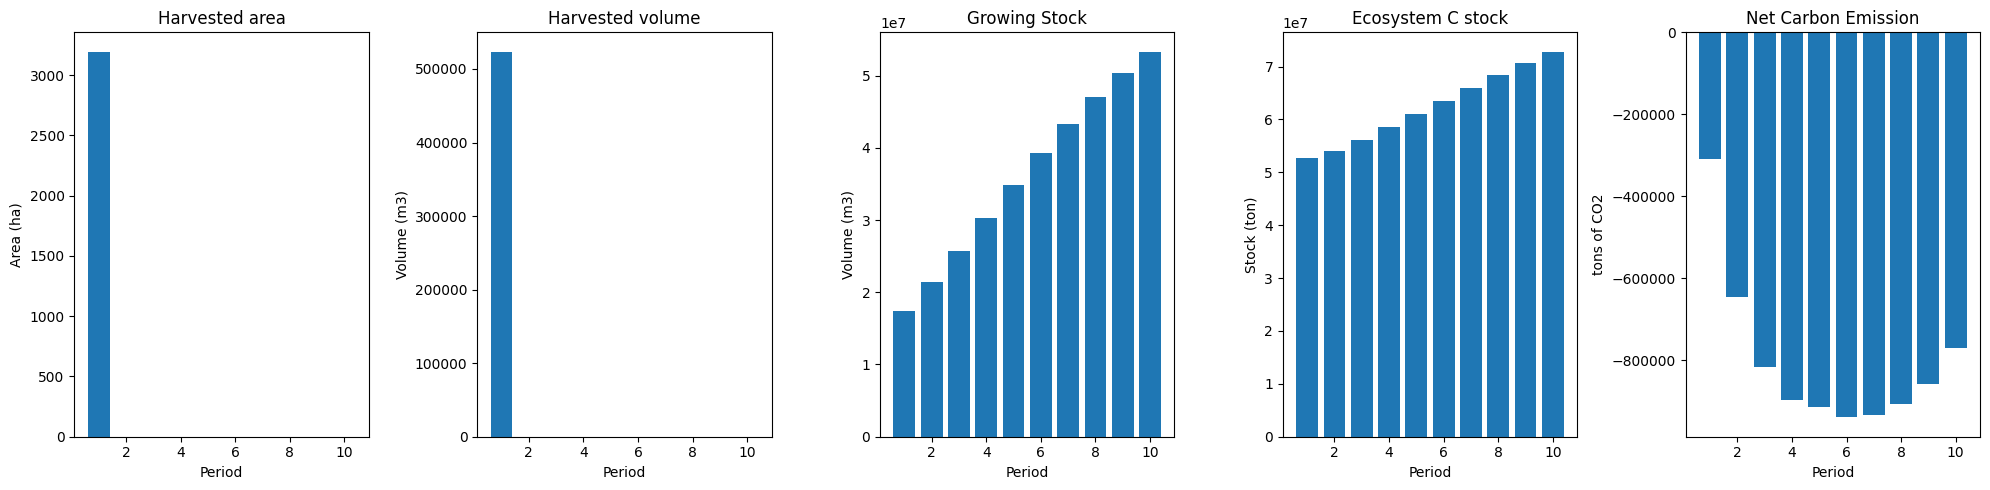

Plot saved to ./outputs/fig/redchris/redchris_min_em_no_cons_scheduling_minemission.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  553
The economic indicator (the provincial government revenues) is:  18879
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


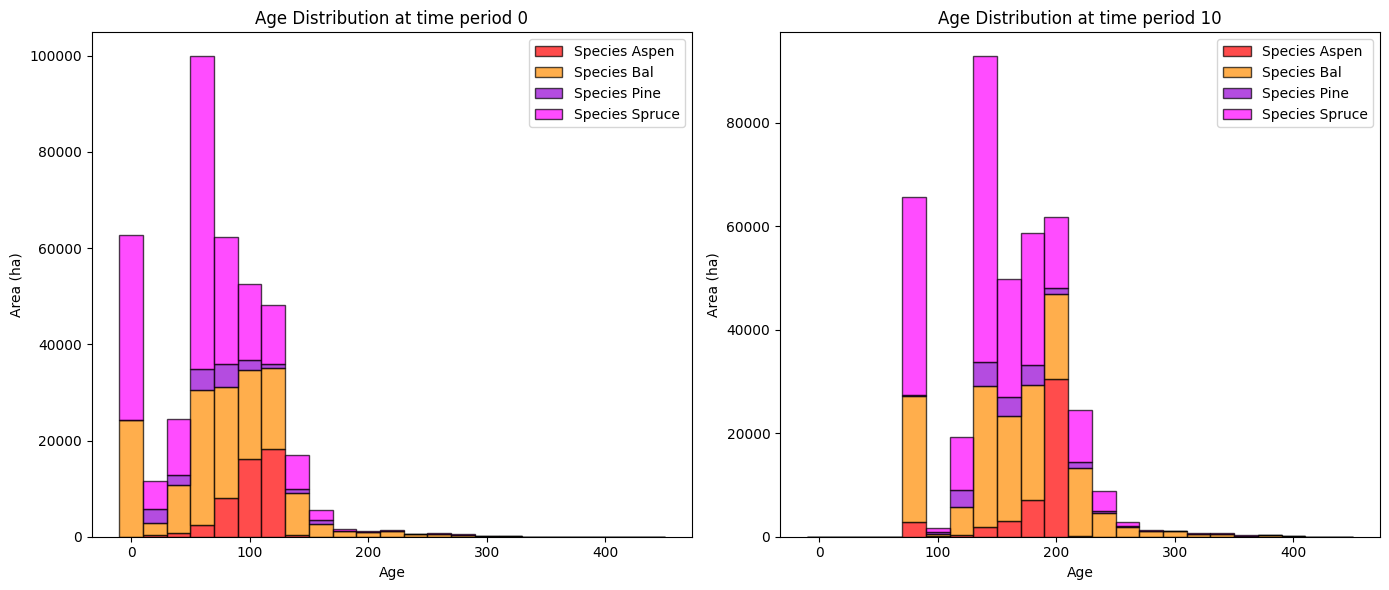

Plot saved to ./outputs/fig/redchris/redchris_min_em_no_cons_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  41723.467284  40778.153596
Pine     602.782616   9167.195758   8564.413142
Bal     4315.588546  54062.091548  49746.503002
Spruce  1072.814408  42096.061799  41023.247392

Old growth has **increased** by 140112.32 hectares from time period 0 to time period 10.


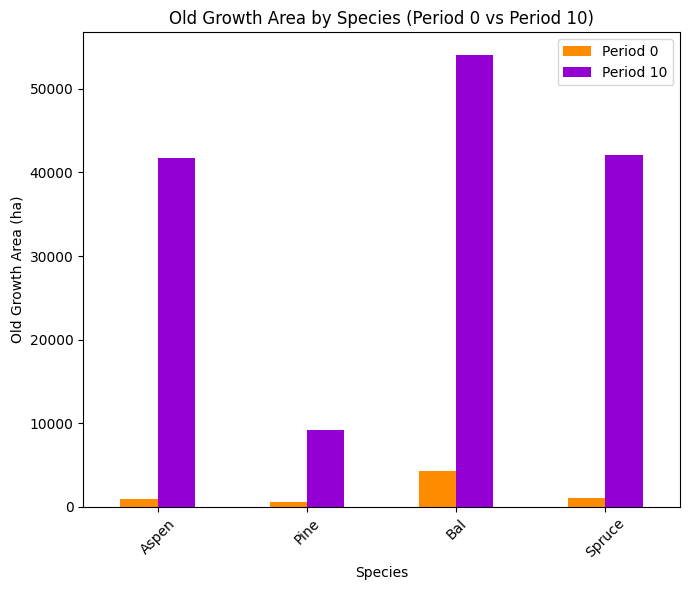

Clustered column plot saved to ./outputs/fig/redchris/redchris_min_em_no_cons_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.8092

Diversity has **decreased** by 7.56% from time 0 to time 10.


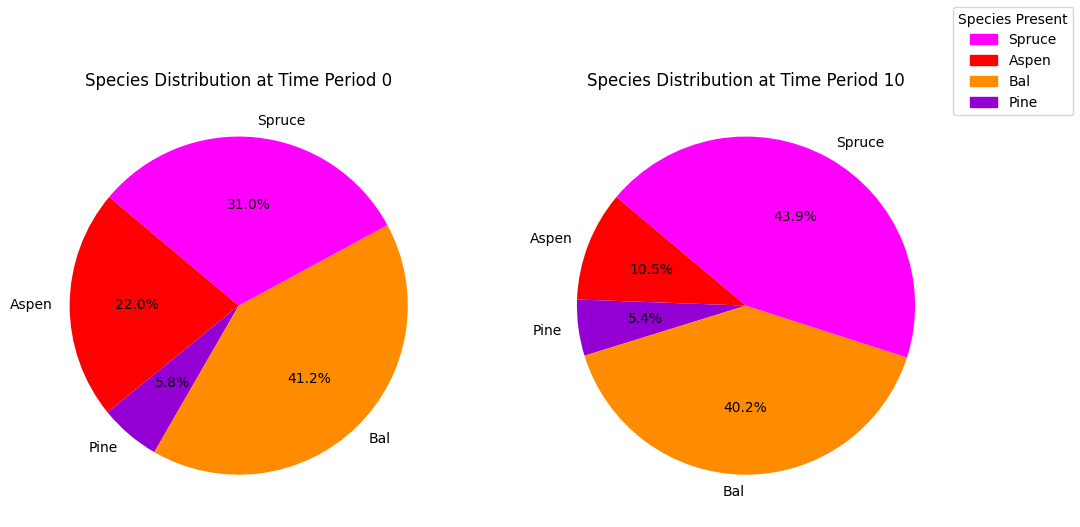

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_em_no_cons_species_pie.pdf
running business as usual scenario for the Red Chris mining site,
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0x50c64669
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [2e-02, 1e+07]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 2005 columns
Presolve time: 0.14s
Presolved: 1699 rows, 32528 columns, 422291 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s



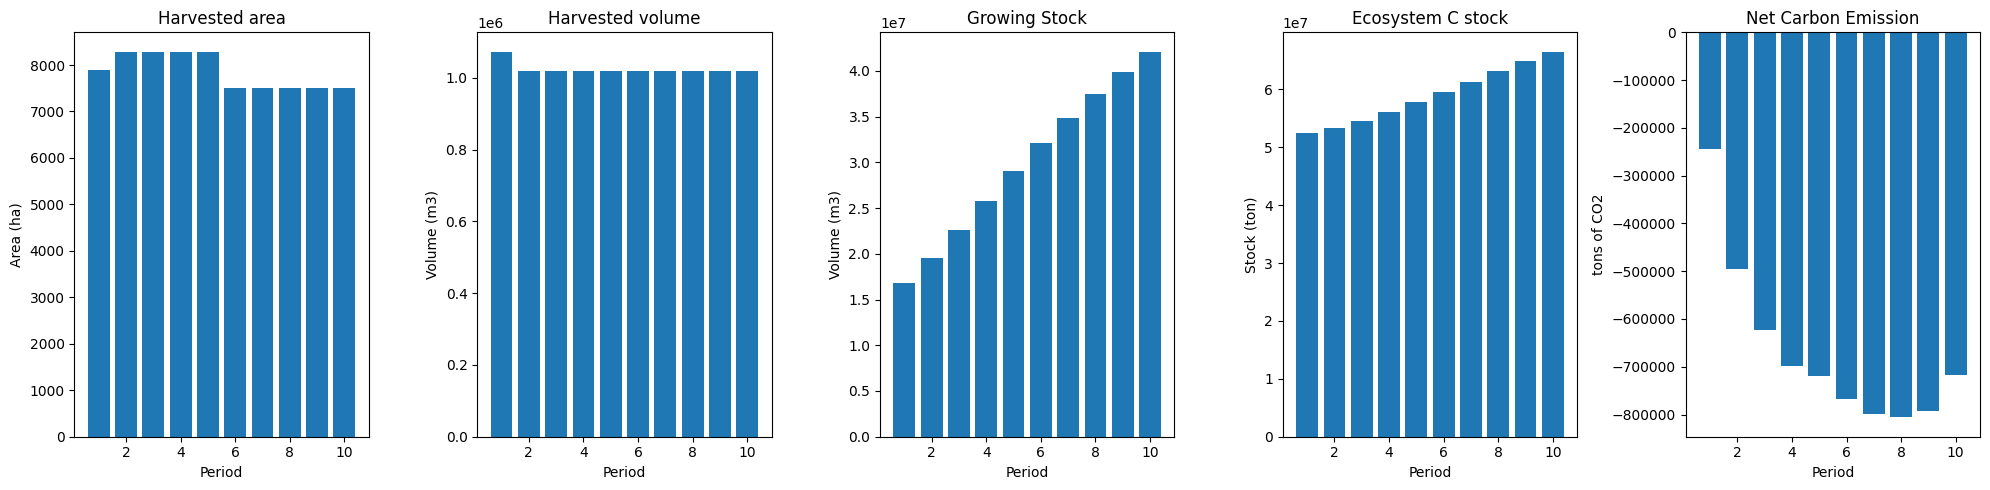

Plot saved to ./outputs/fig/redchris/redchris_min_em_bau_redchrs_scheduling_minemission.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  10831
The economic indicator (the provincial government revenues) is:  369393
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


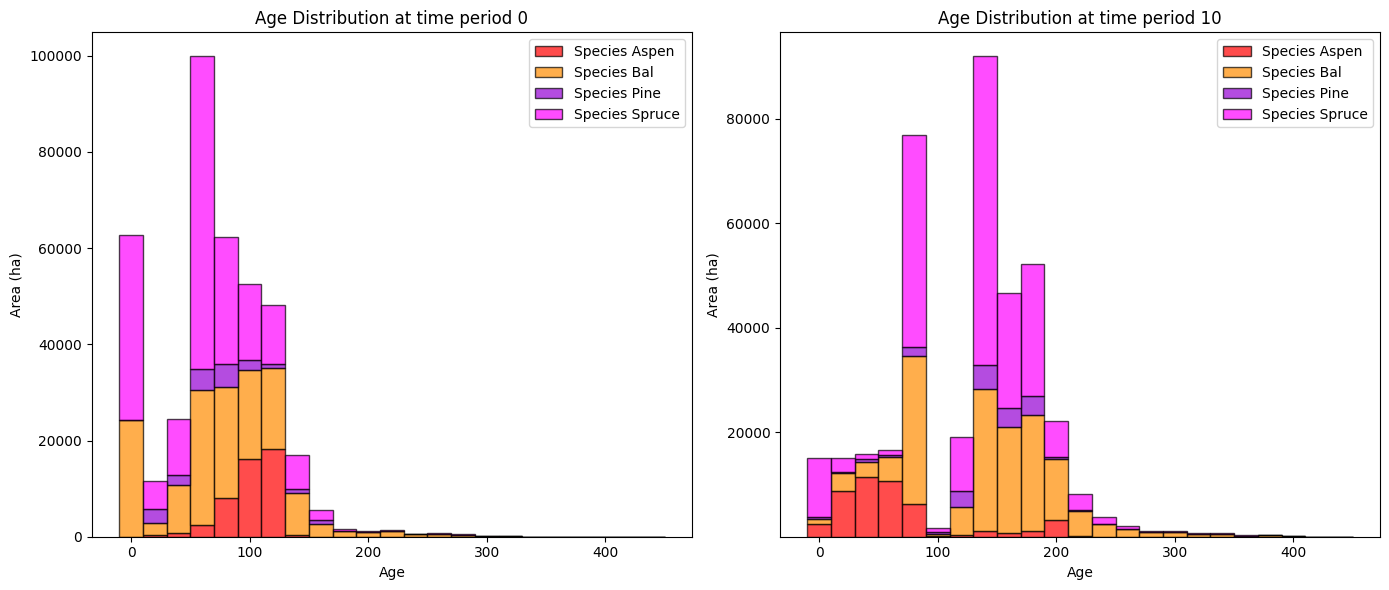

Plot saved to ./outputs/fig/redchris/redchris_min_em_bau_redchrs_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688   5435.179883   4489.866195
Pine     602.782616   6472.028996   5869.246380
Bal     4315.588546  38717.863313  34402.274766
Spruce  1072.814408  26003.989976  24931.175569

Old growth has **increased** by 69692.56 hectares from time period 0 to time period 10.


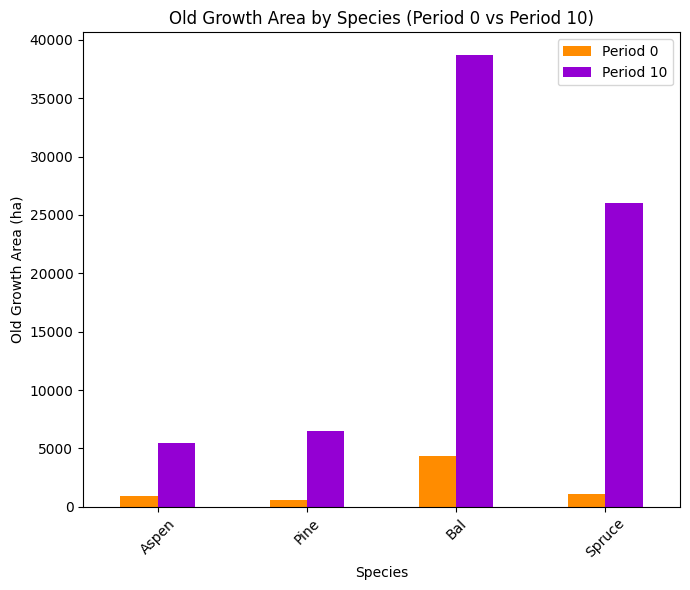

Clustered column plot saved to ./outputs/fig/redchris/redchris_min_em_bau_redchrs_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.7207

Diversity has **decreased** by 16.41% from time 0 to time 10.


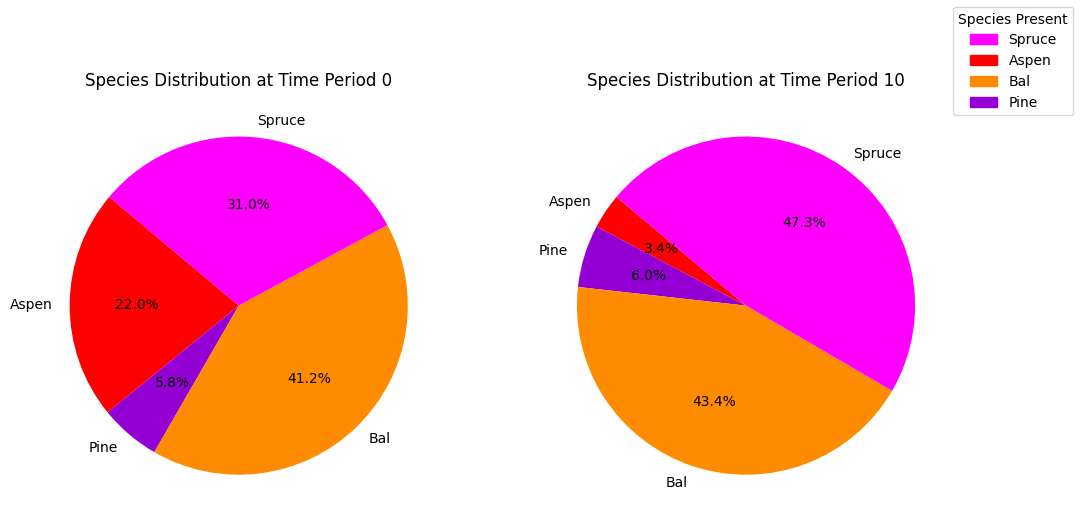

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_em_bau_redchrs_species_pie.pdf


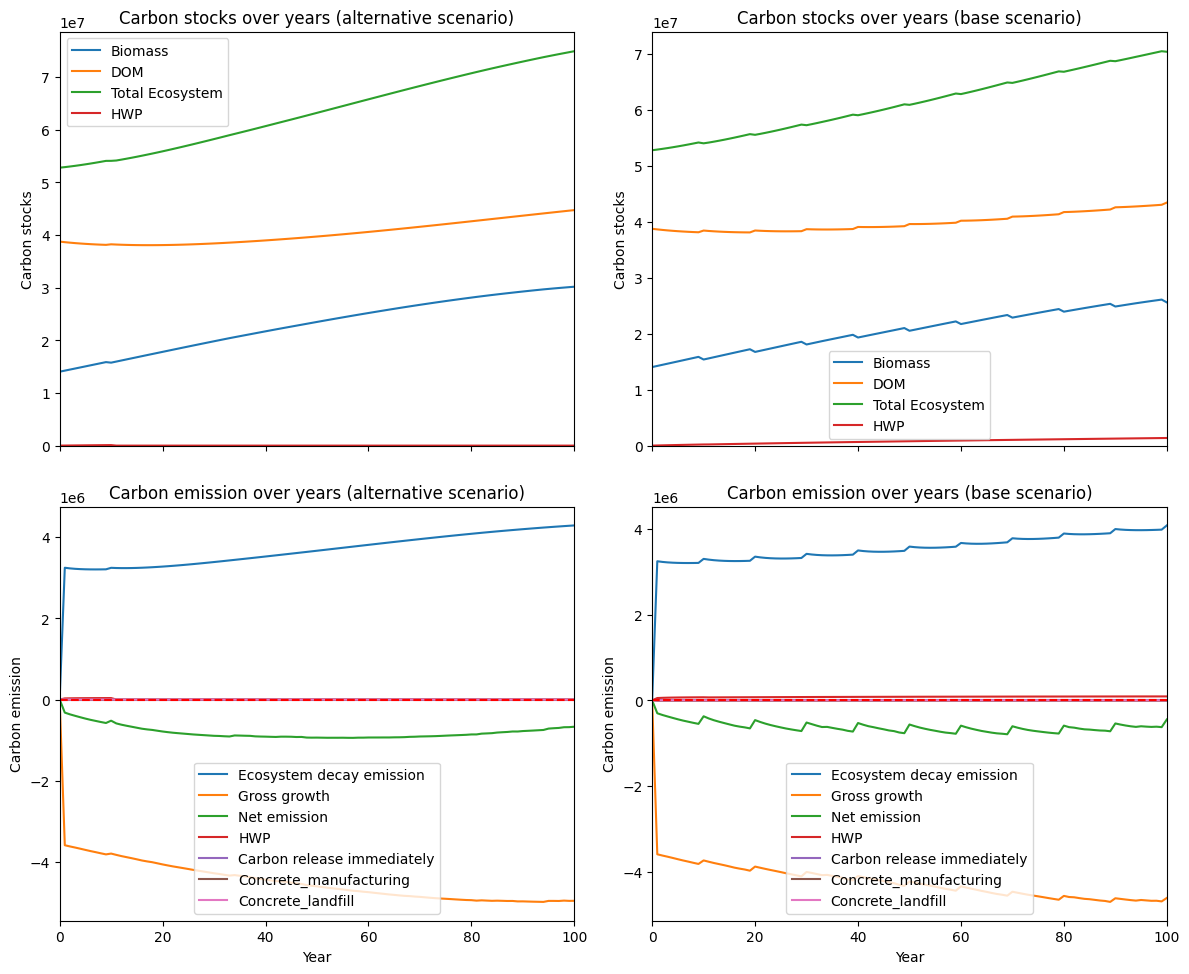

---------------------------------------------------------------------------------------
Net emission difference -19026990.407345925
Net emission base scenario -62345424.357902035
Net emission alternative scenario -81372414.76524797
dollar_per_ton is:  0.5255691933359681
Comparison of Old Growth Areas (Alternative - Base)
          0            10    Difference
Aspen   0.0  36288.287401  36288.287401
Pine    0.0   2695.166761   2695.166761
Bal     0.0  15344.228236  15344.228236
Spruce  0.0  16092.071823  16092.071823

Overall, the old growth area has **increased** by 70419.75 hectares in the alternative scenario compared to the base scenario.


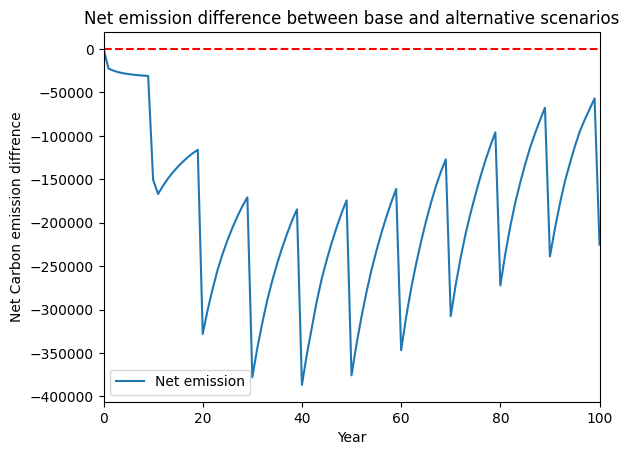

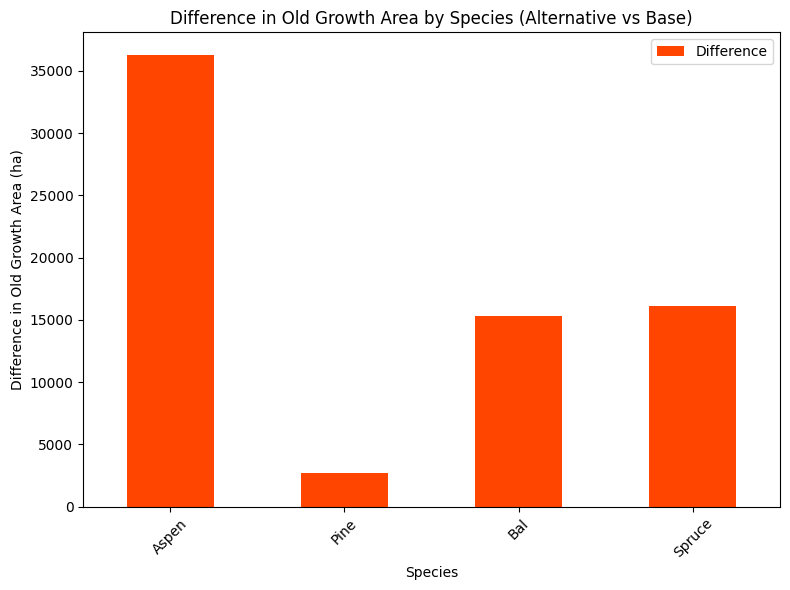

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/redchris/redchris_min_em_kpi_age_difference.pdf


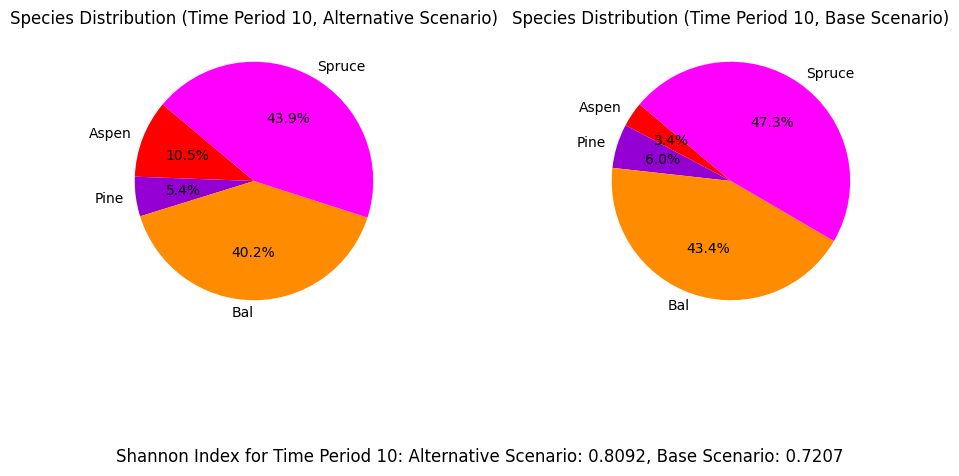

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_em_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for redchris_min_em_evenflow_cons...
running even flow constraints scenario
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3707 rows, 34533 columns and 445161 nonzeros
Model fingerprint: 0xe6ac3303
Coefficient statistics:
  Matrix range     [1e-02, 1e+06]
  Objective range  [2e-02, 1e+07]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 2009 rows and 2005 columns
Presolve time: 0.10s
Presolved: 1698 rows, 32528 columns, 415336 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.

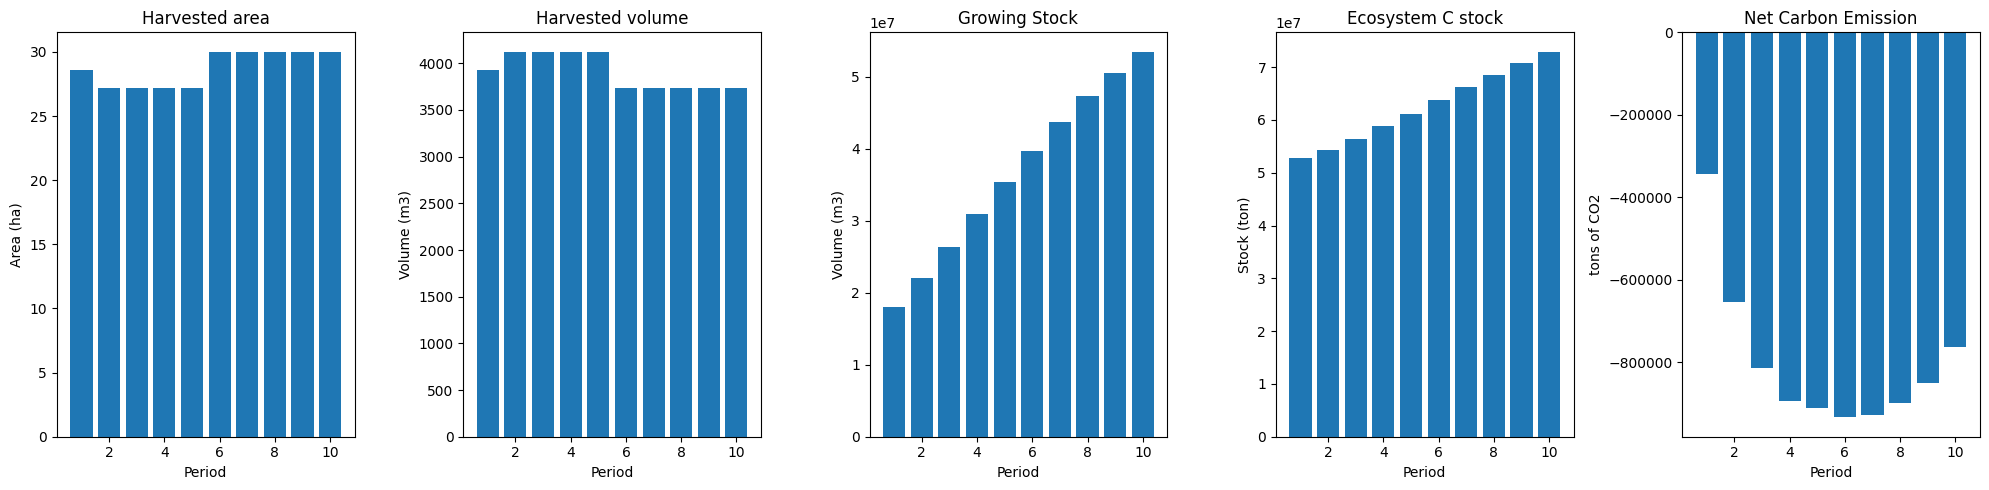

Plot saved to ./outputs/fig/redchris/redchris_min_em_evenflow_cons_scheduling_minemission.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  41
The economic indicator (the provincial government revenues) is:  1409
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


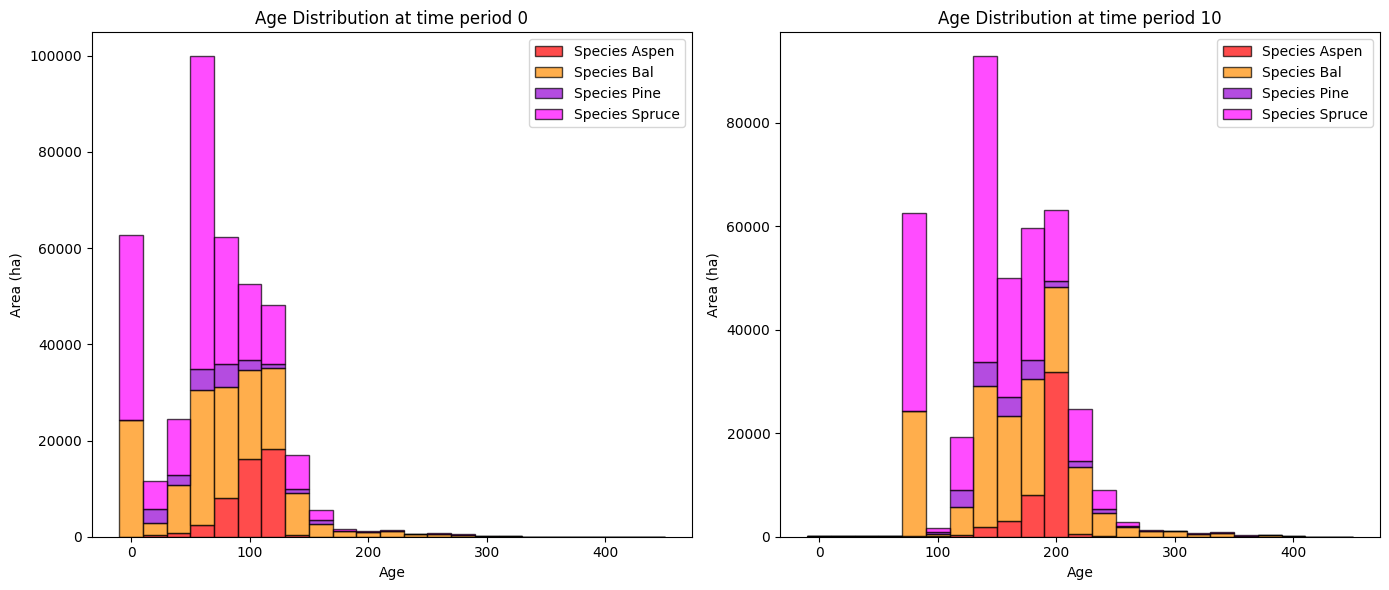

Plot saved to ./outputs/fig/redchris/redchris_min_em_evenflow_cons_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  44237.159387  43291.845700
Pine     602.782616   9389.986273   8787.203656
Bal     4315.588546  54242.845266  49927.256720
Spruce  1072.814408  42096.061799  41023.247392

Old growth has **increased** by 143029.55 hectares from time period 0 to time period 10.


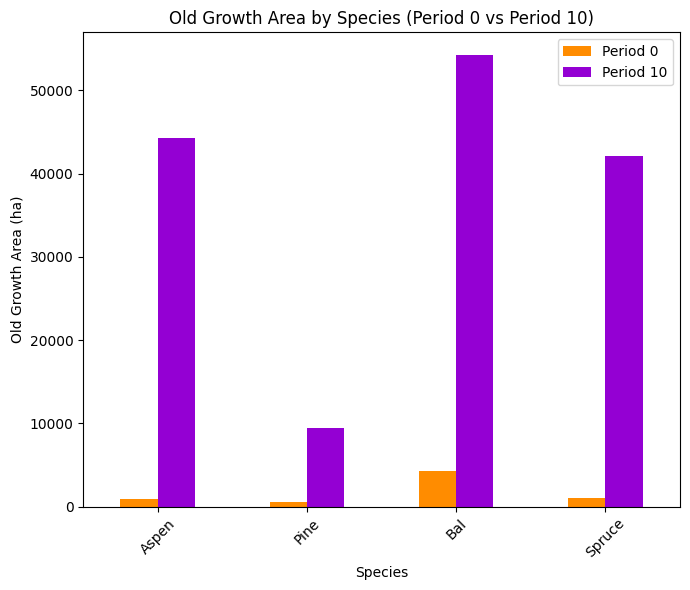

Clustered column plot saved to ./outputs/fig/redchris/redchris_min_em_evenflow_cons_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.8116

Diversity has **decreased** by 7.32% from time 0 to time 10.


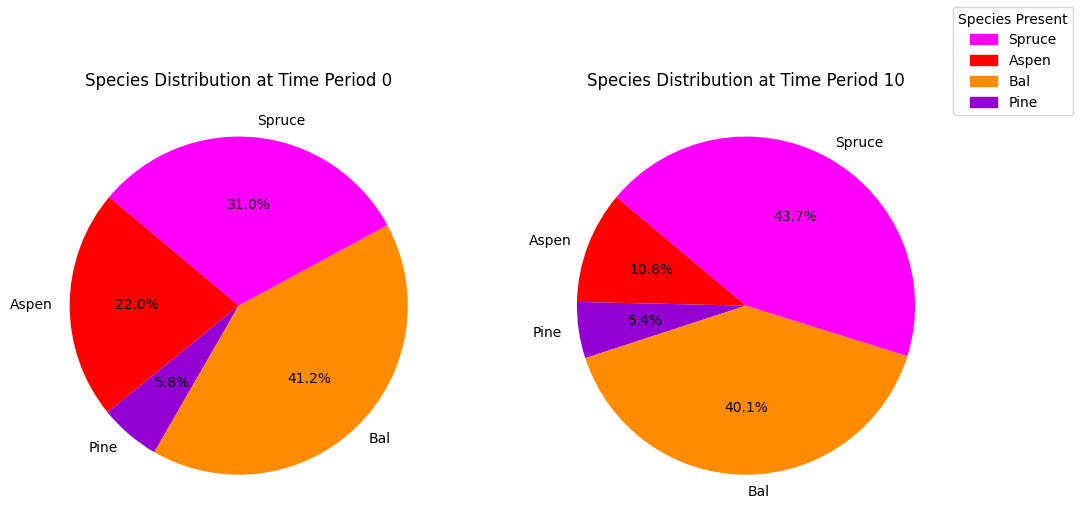

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_em_evenflow_cons_species_pie.pdf
running business as usual scenario for the Red Chris mining site,
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0x50c64669
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [2e-02, 1e+07]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 2005 columns
Presolve time: 0.14s
Presolved: 1699 rows, 32528 columns, 422291 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0

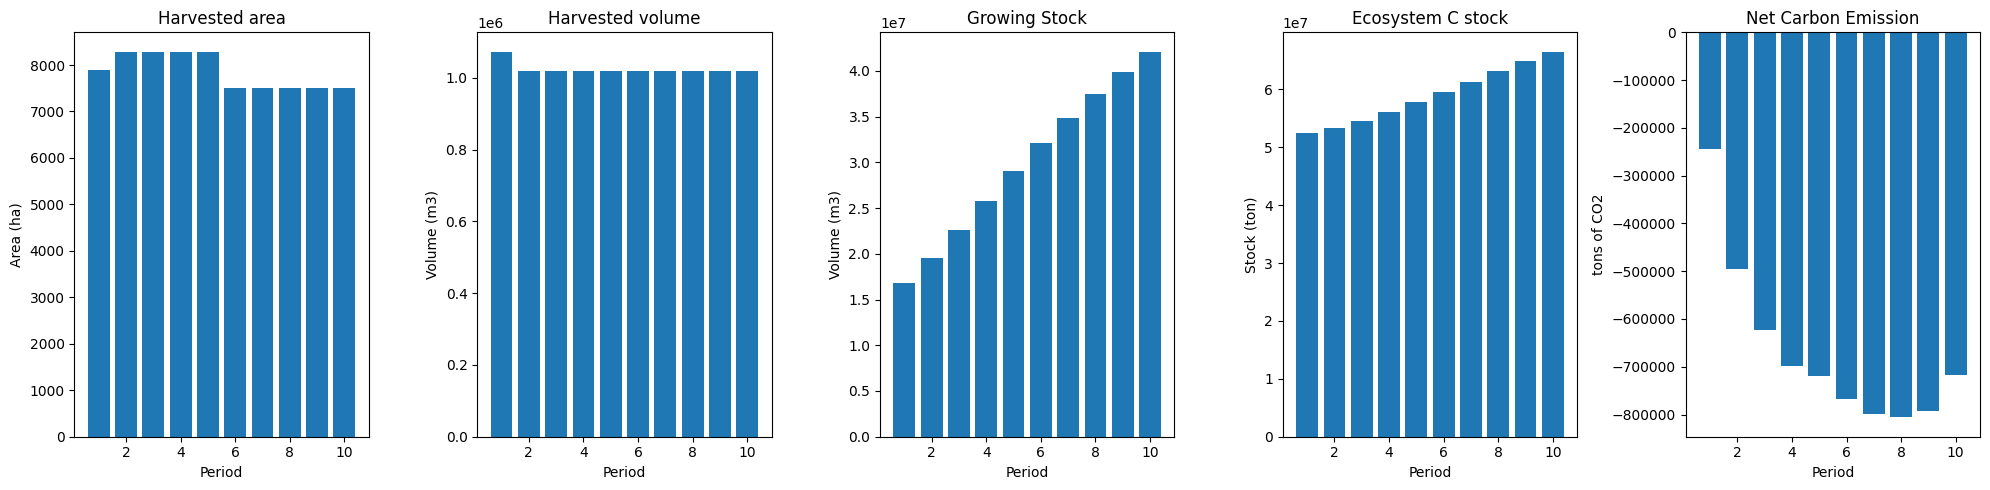

Plot saved to ./outputs/fig/redchris/redchris_min_em_bau_redchrs_scheduling_minemission.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  10831
The economic indicator (the provincial government revenues) is:  369393
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


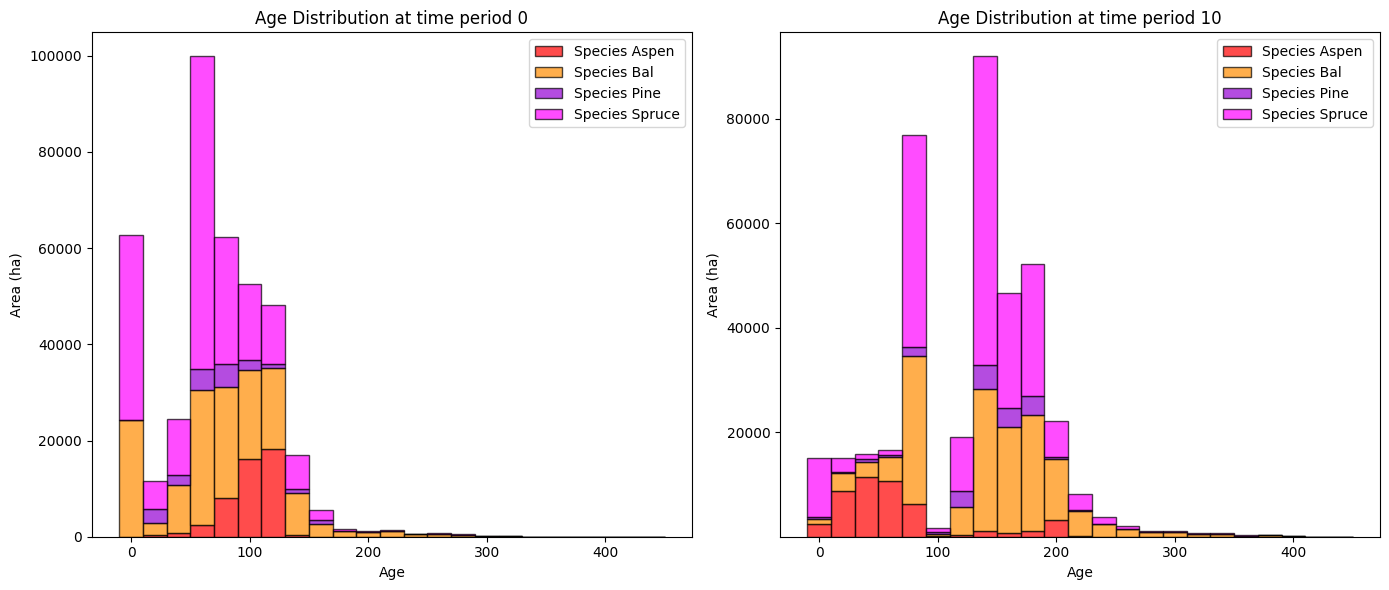

Plot saved to ./outputs/fig/redchris/redchris_min_em_bau_redchrs_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688   5435.179883   4489.866195
Pine     602.782616   6472.028996   5869.246380
Bal     4315.588546  38717.863313  34402.274766
Spruce  1072.814408  26003.989976  24931.175569

Old growth has **increased** by 69692.56 hectares from time period 0 to time period 10.


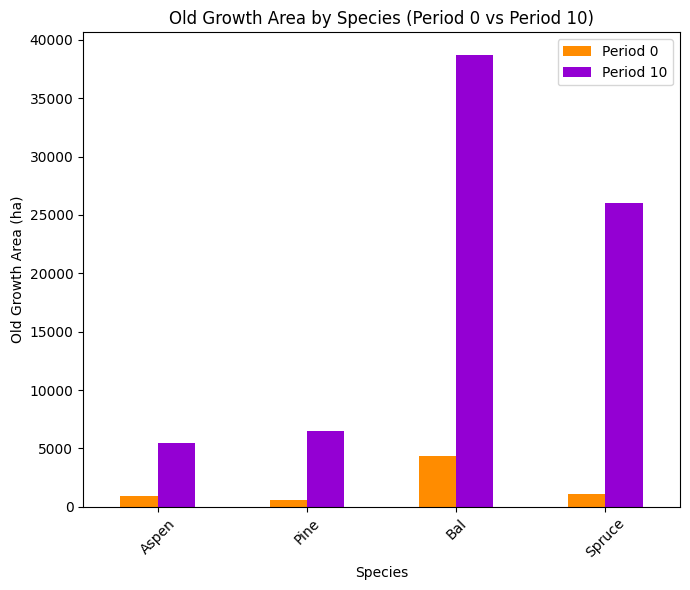

Clustered column plot saved to ./outputs/fig/redchris/redchris_min_em_bau_redchrs_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.7207

Diversity has **decreased** by 16.41% from time 0 to time 10.


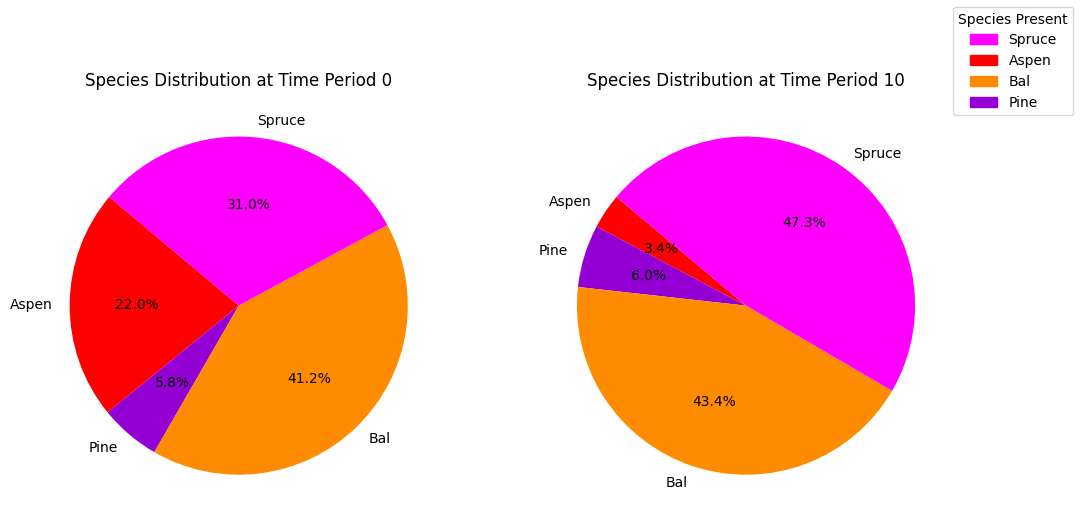

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_em_bau_redchrs_species_pie.pdf


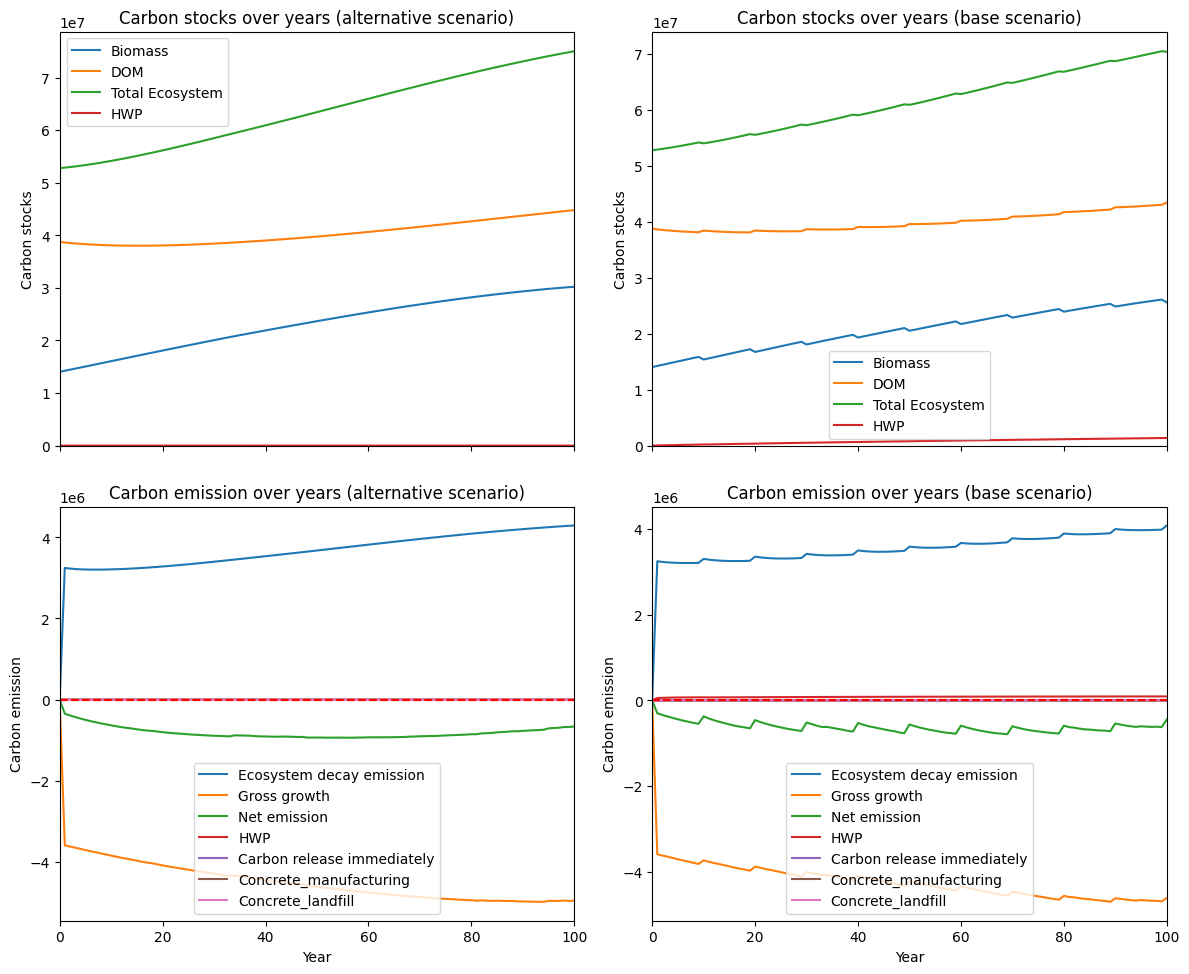

---------------------------------------------------------------------------------------
Net emission difference -19177592.922145832
Net emission base scenario -62345424.357902035
Net emission alternative scenario -81523017.28004785
dollar_per_ton is:  0.5214418744102257
Comparison of Old Growth Areas (Alternative - Base)
          0            10    Difference
Aspen   0.0  38801.979505  38801.979505
Pine    0.0   2917.957276   2917.957276
Bal     0.0  15524.981953  15524.981953
Spruce  0.0  16092.071823  16092.071823

Overall, the old growth area has **increased** by 73336.99 hectares in the alternative scenario compared to the base scenario.


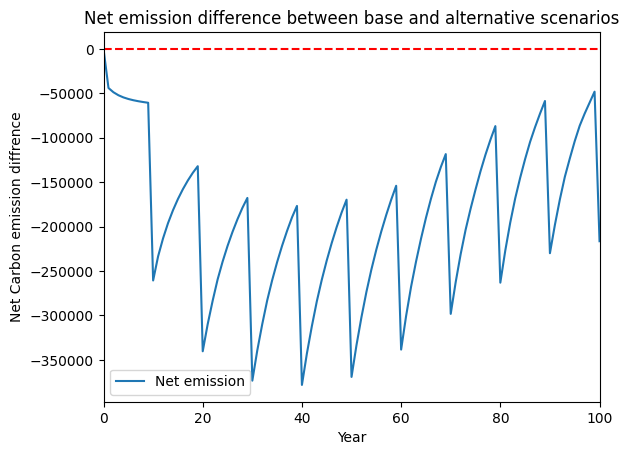

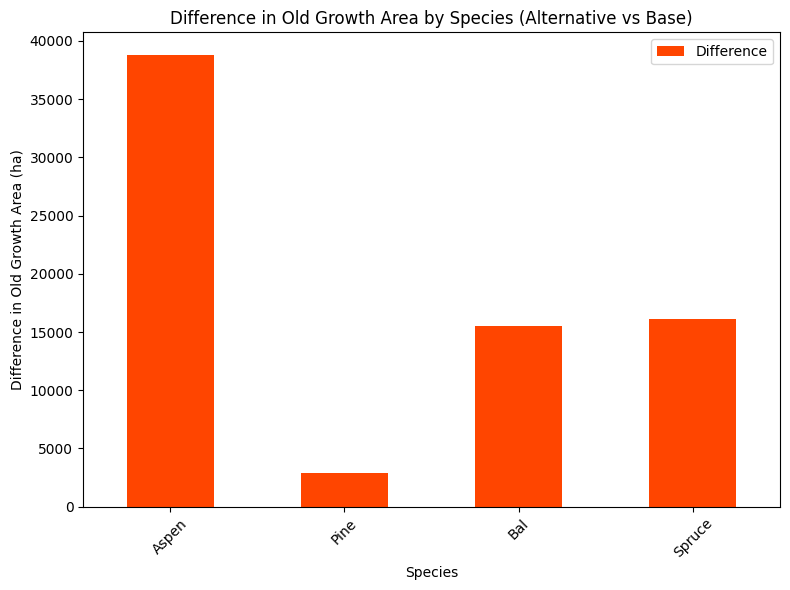

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/redchris/redchris_min_em_kpi_age_difference.pdf


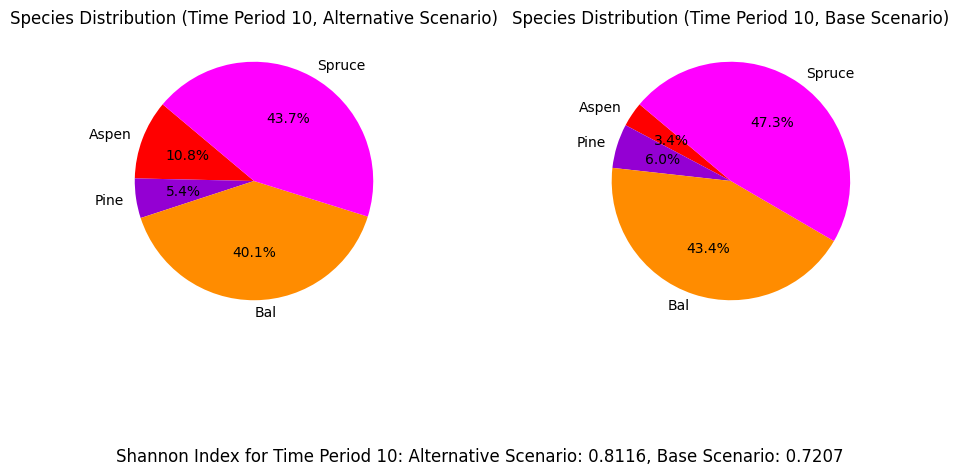

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_em_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for redchris_min_em_redchrs_AAC_90%...
running the scenario for the Red Chris mining site (90%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0xe22120d1
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [2e-02, 1e+07]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 2005 columns
Presolve time: 0.14s
Presolved: 1699 rows, 32529 column

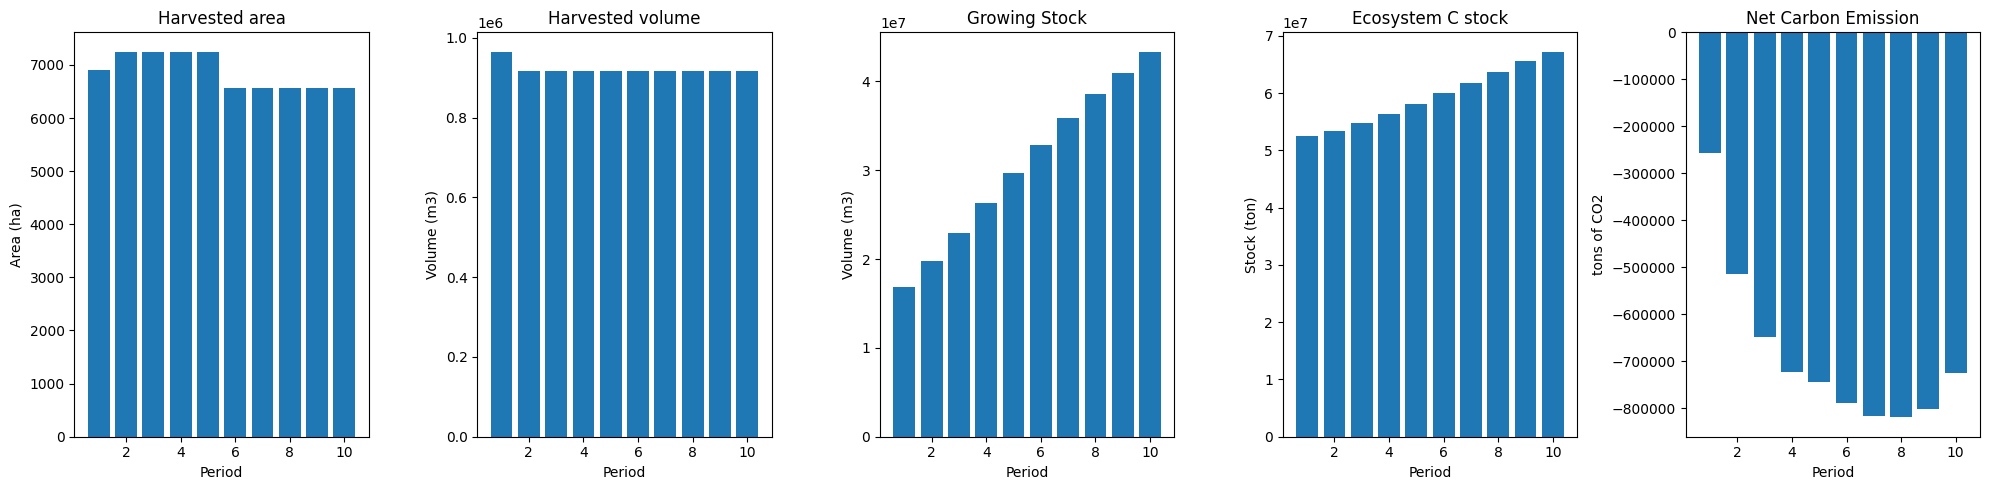

Plot saved to ./outputs/fig/redchris/redchris_min_em_redchrs_AAC_90%_scheduling_minemission.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  9748
The economic indicator (the provincial government revenues) is:  332454
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


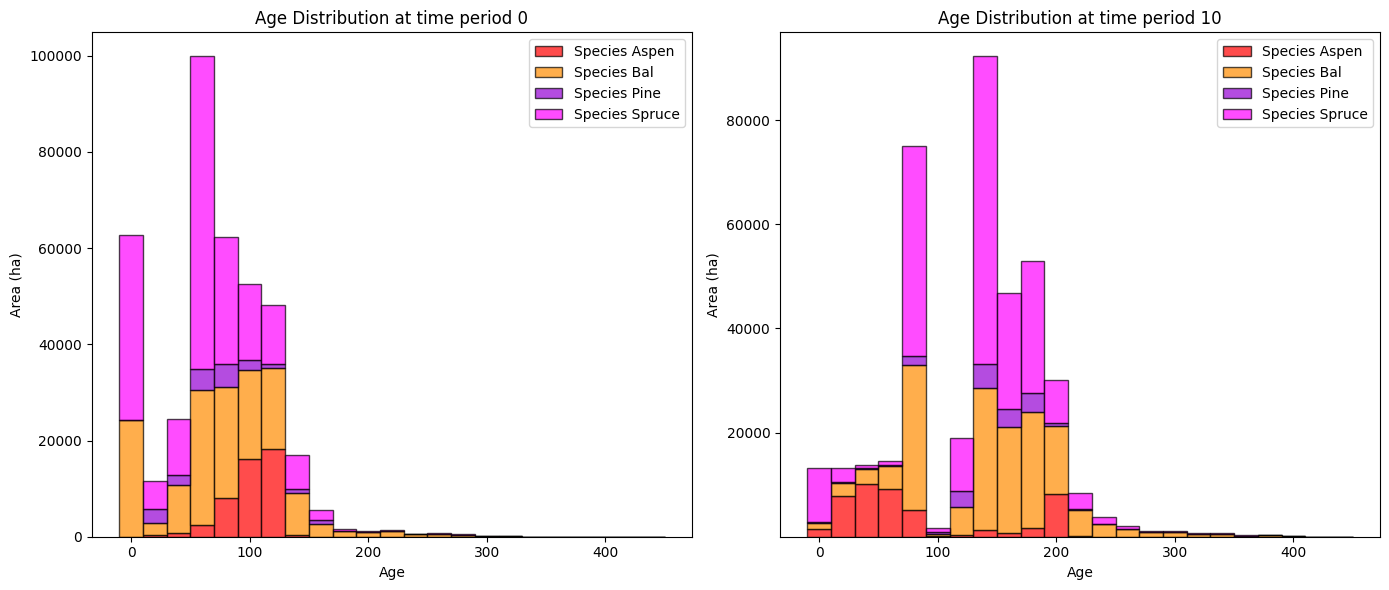

Plot saved to ./outputs/fig/redchris/redchris_min_em_redchrs_AAC_90%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  11223.366767  10278.053079
Pine     602.782616   6982.686167   6379.903551
Bal     4315.588546  39903.375658  35587.787112
Spruce  1072.814408  27076.297887  26003.483479

Old growth has **increased** by 78249.23 hectares from time period 0 to time period 10.


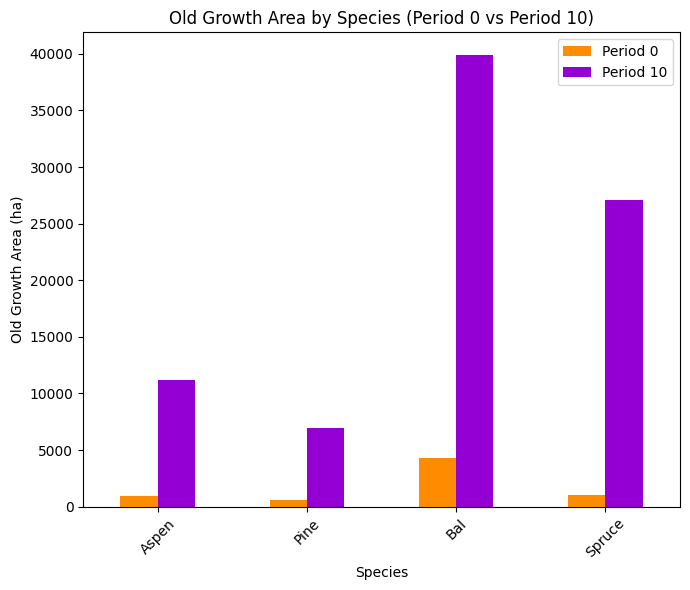

Clustered column plot saved to ./outputs/fig/redchris/redchris_min_em_redchrs_AAC_90%_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.7425

Diversity has **decreased** by 14.23% from time 0 to time 10.


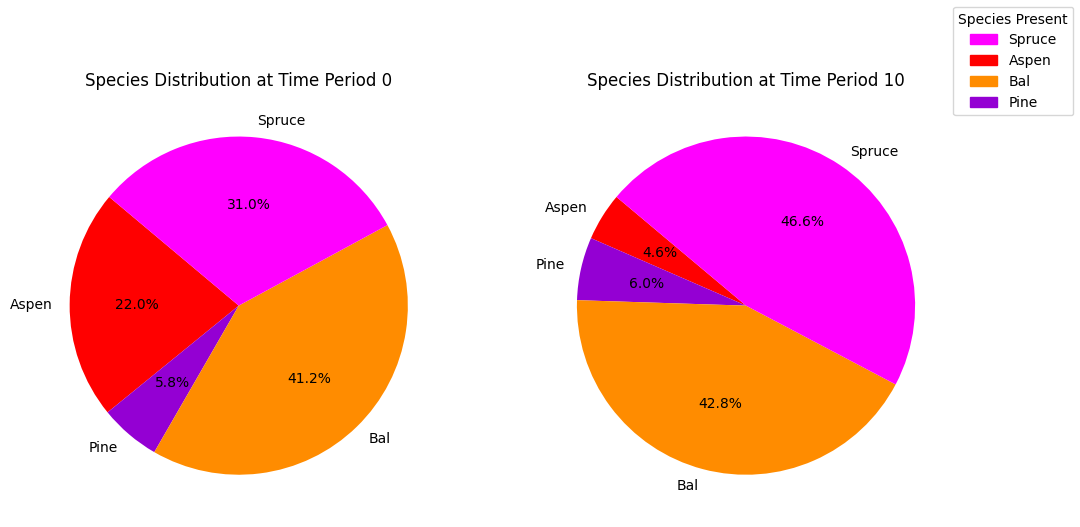

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_em_redchrs_AAC_90%_species_pie.pdf
running business as usual scenario for the Red Chris mining site,
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0x50c64669
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [2e-02, 1e+07]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 2005 columns
Presolve time: 0.13s
Presolved: 1699 rows, 32528 columns, 422291 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time:

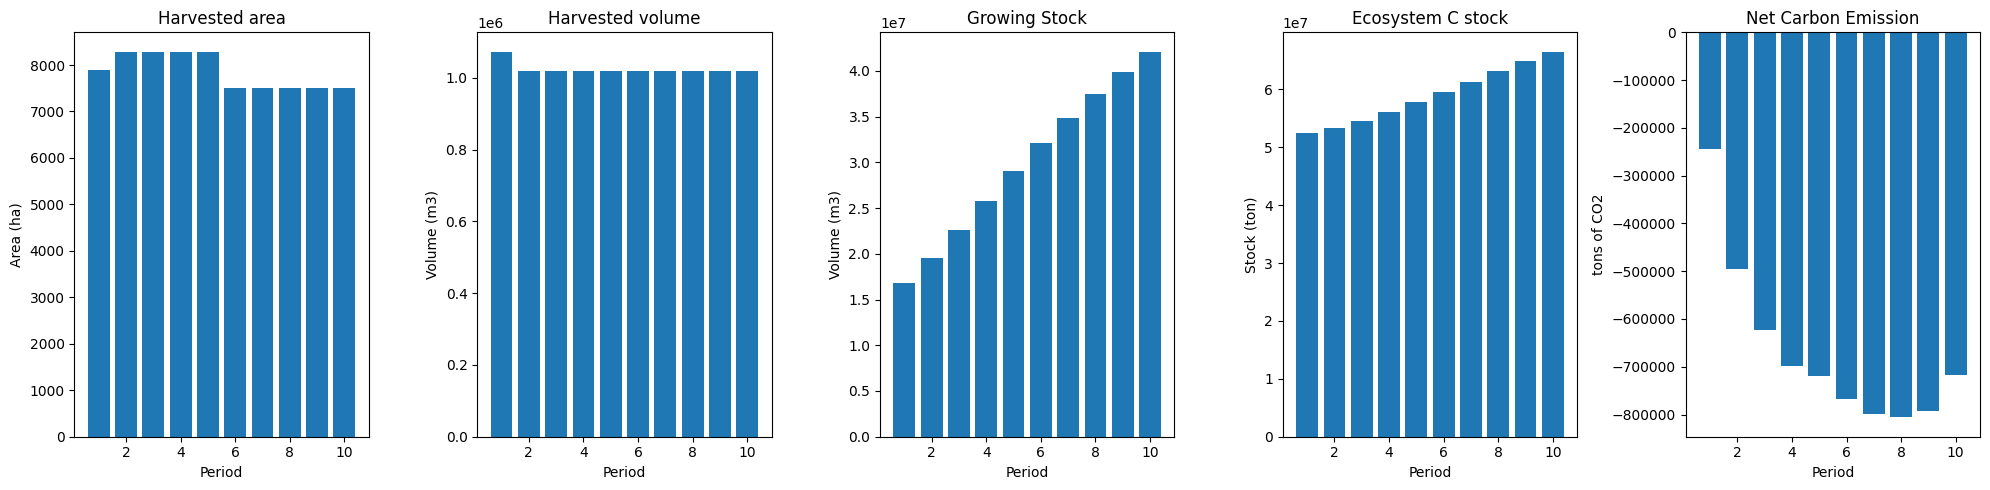

Plot saved to ./outputs/fig/redchris/redchris_min_em_bau_redchrs_scheduling_minemission.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  10831
The economic indicator (the provincial government revenues) is:  369393
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


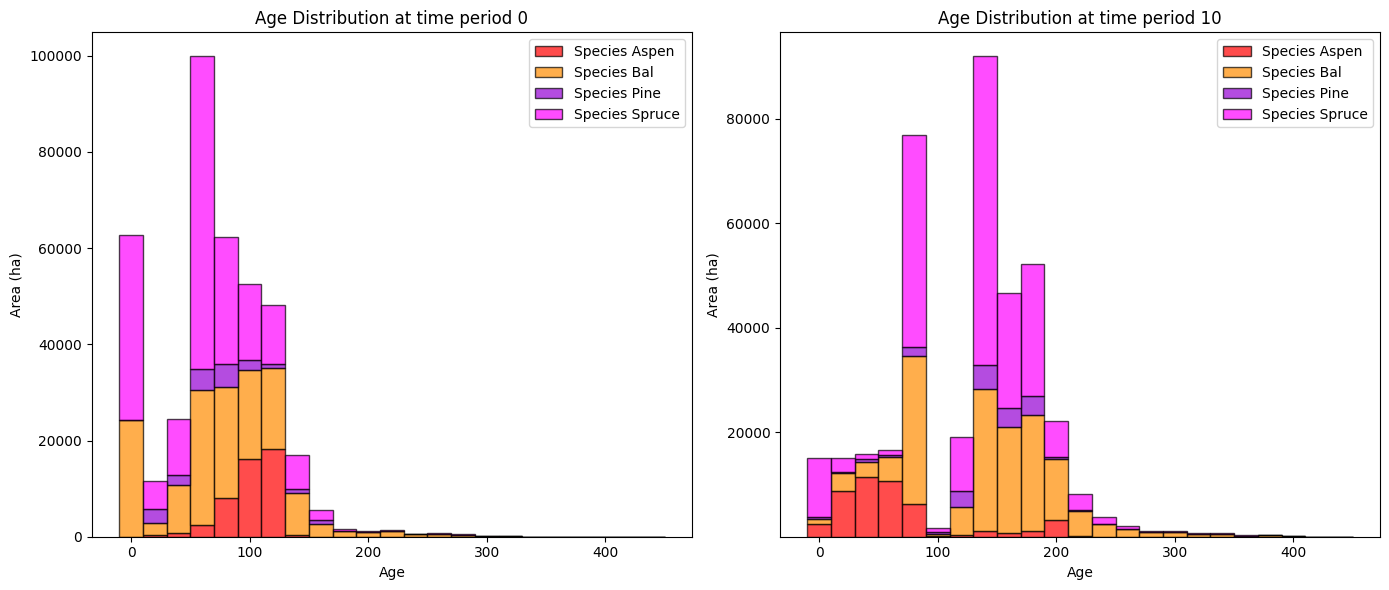

Plot saved to ./outputs/fig/redchris/redchris_min_em_bau_redchrs_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688   5435.179883   4489.866195
Pine     602.782616   6472.028996   5869.246380
Bal     4315.588546  38717.863313  34402.274766
Spruce  1072.814408  26003.989976  24931.175569

Old growth has **increased** by 69692.56 hectares from time period 0 to time period 10.


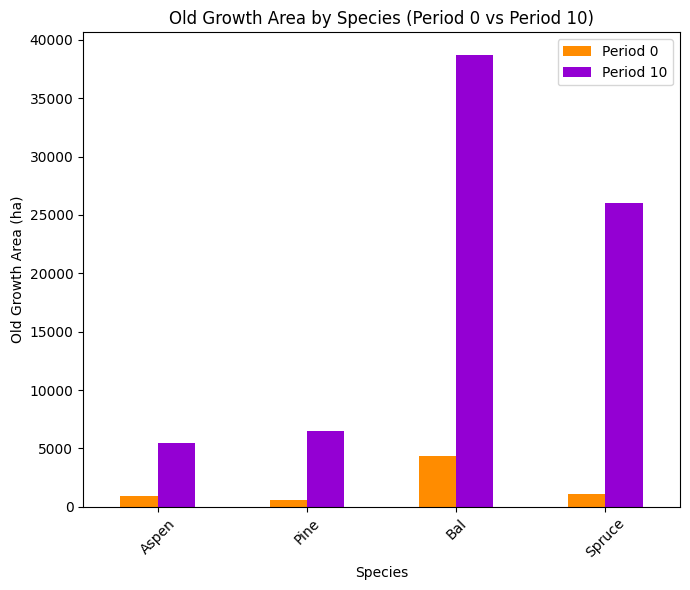

Clustered column plot saved to ./outputs/fig/redchris/redchris_min_em_bau_redchrs_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.7207

Diversity has **decreased** by 16.41% from time 0 to time 10.


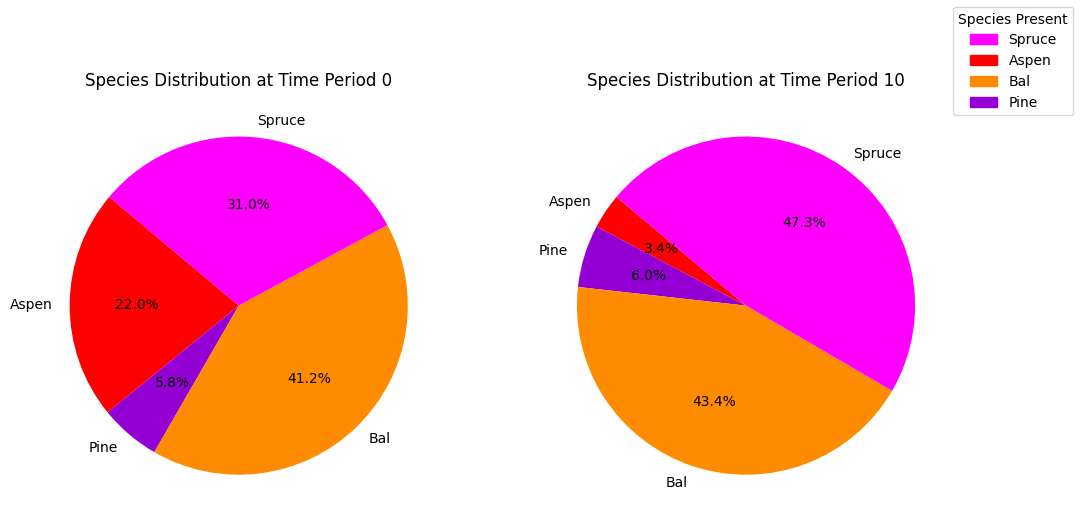

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_em_bau_redchrs_species_pie.pdf


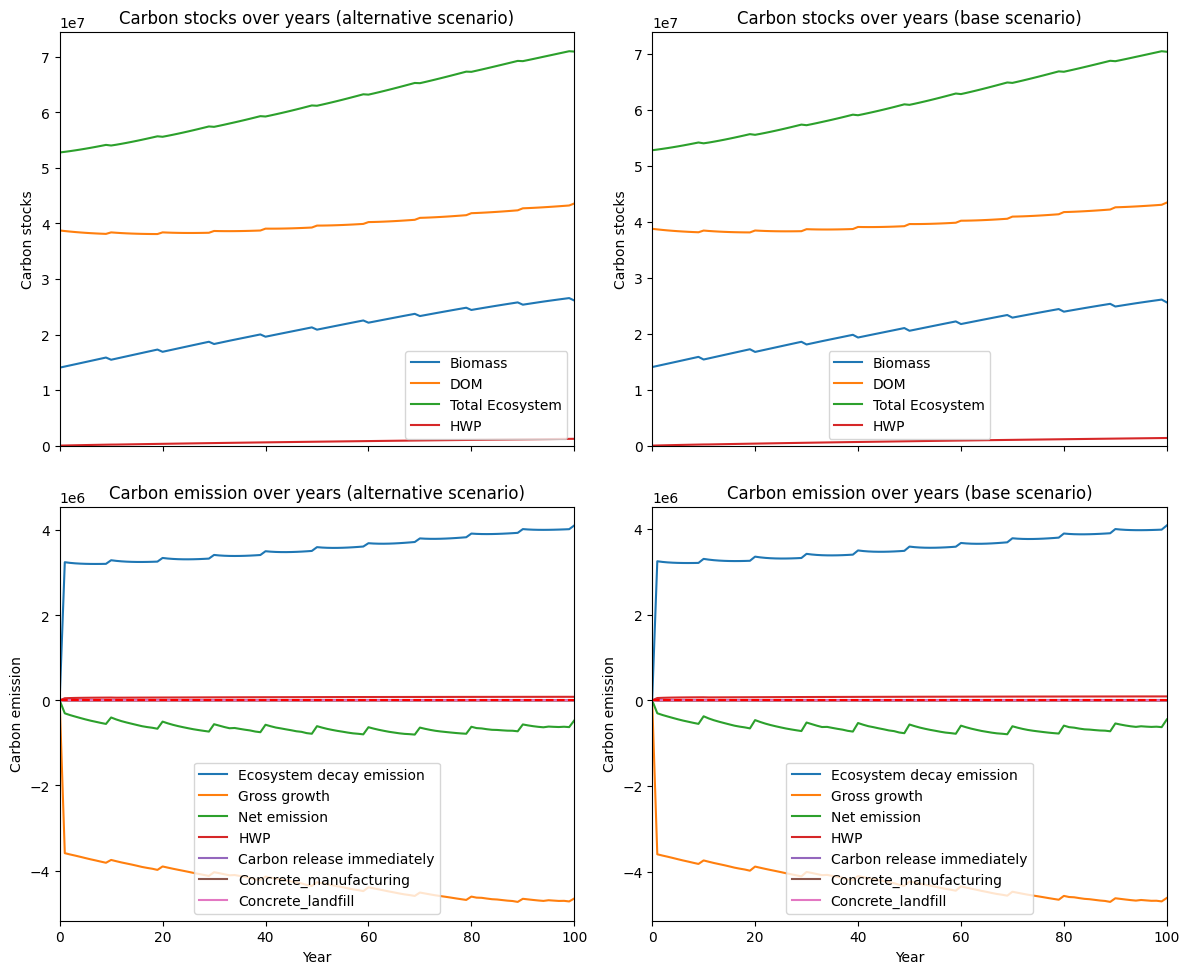

---------------------------------------------------------------------------------------
Net emission difference -2257092.9225402707
Net emission base scenario -62345424.357902035
Net emission alternative scenario -64602517.280442305
dollar_per_ton is:  4.430477761963556
Comparison of Old Growth Areas (Alternative - Base)
          0           10   Difference
Aspen   0.0  5788.186884  5788.186884
Pine    0.0   510.657171   510.657171
Bal     0.0  1185.512345  1185.512345
Spruce  0.0  1072.307910  1072.307910

Overall, the old growth area has **increased** by 8556.66 hectares in the alternative scenario compared to the base scenario.


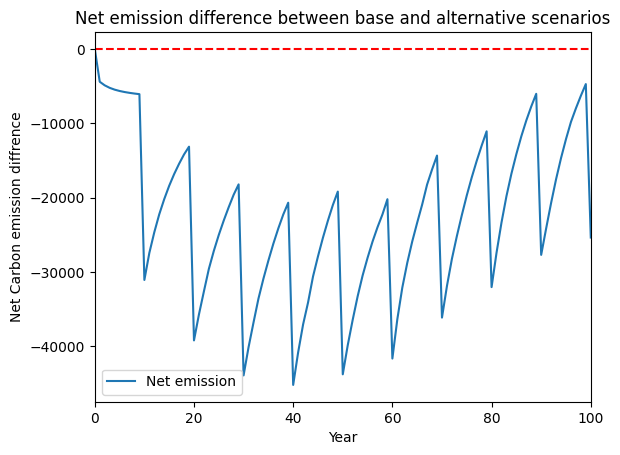

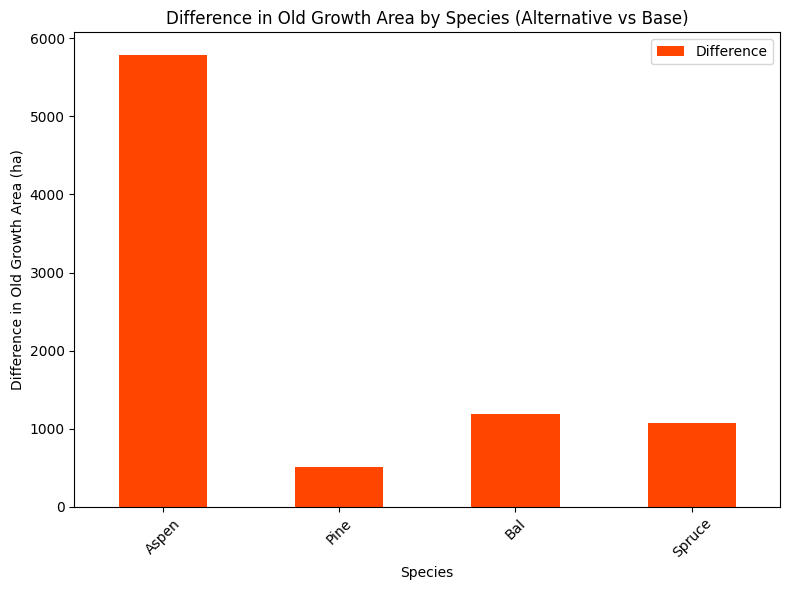

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/redchris/redchris_min_em_kpi_age_difference.pdf


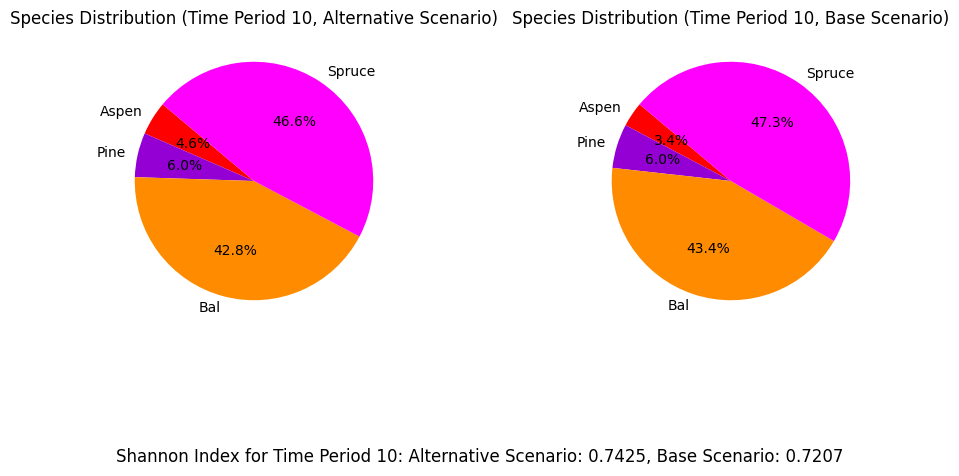

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_em_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for redchris_min_em_redchrs_AAC_80%...
running the scenario for the Red Chris mining site (80%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0x4a12dd94
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [2e-02, 1e+07]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 2005 columns
Presolve time: 0.13s
Presolved: 1699 rows, 32529 column

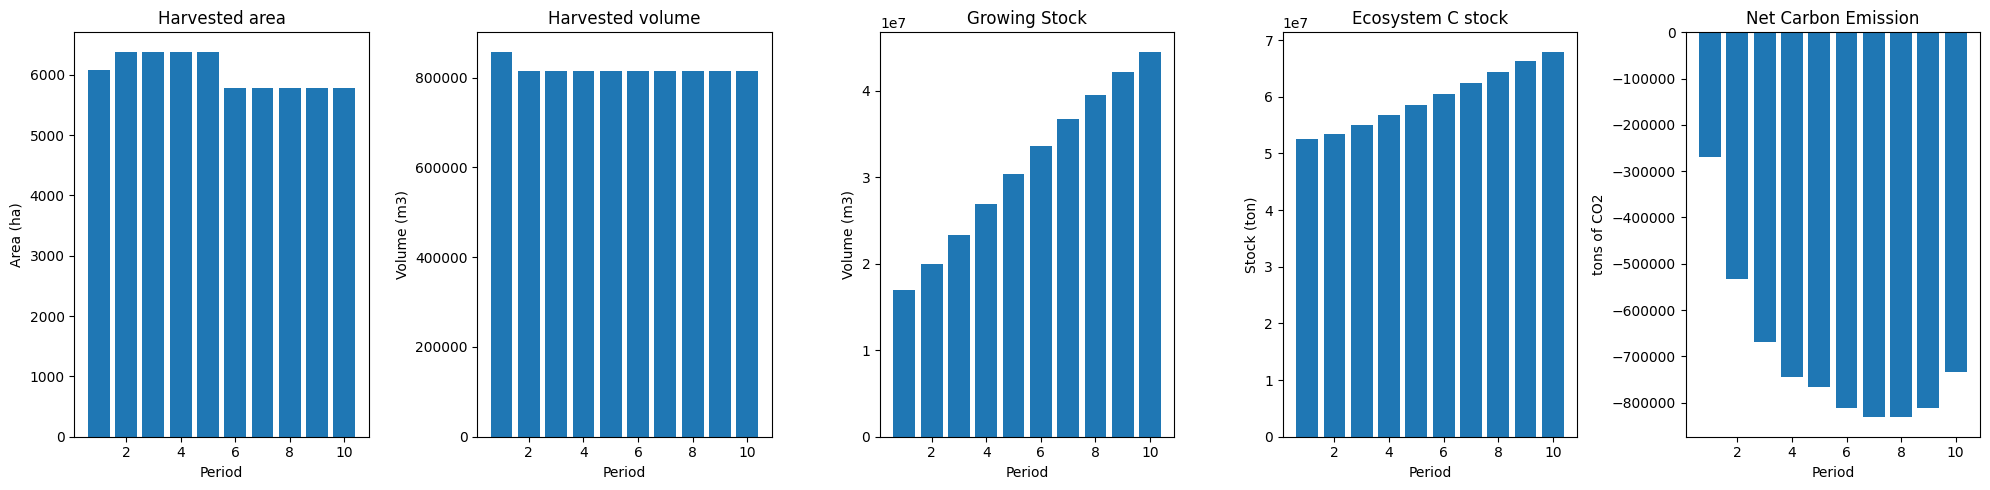

Plot saved to ./outputs/fig/redchris/redchris_min_em_redchrs_AAC_80%_scheduling_minemission.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  8665
The economic indicator (the provincial government revenues) is:  295514
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


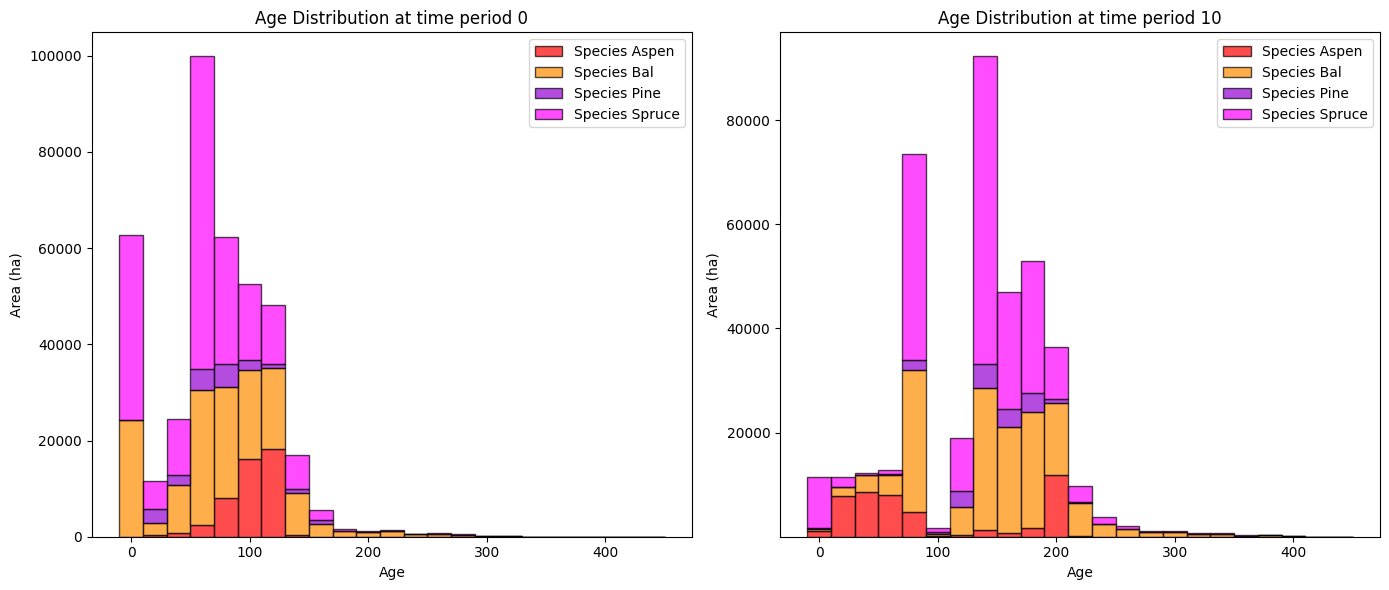

Plot saved to ./outputs/fig/redchris/redchris_min_em_redchrs_AAC_80%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  14976.887185  14031.573497
Pine     602.782616   7123.139124   6520.356508
Bal     4315.588546  41941.162094  37625.573548
Spruce  1072.814408  28714.132306  27641.317899

Old growth has **increased** by 85818.82 hectares from time period 0 to time period 10.


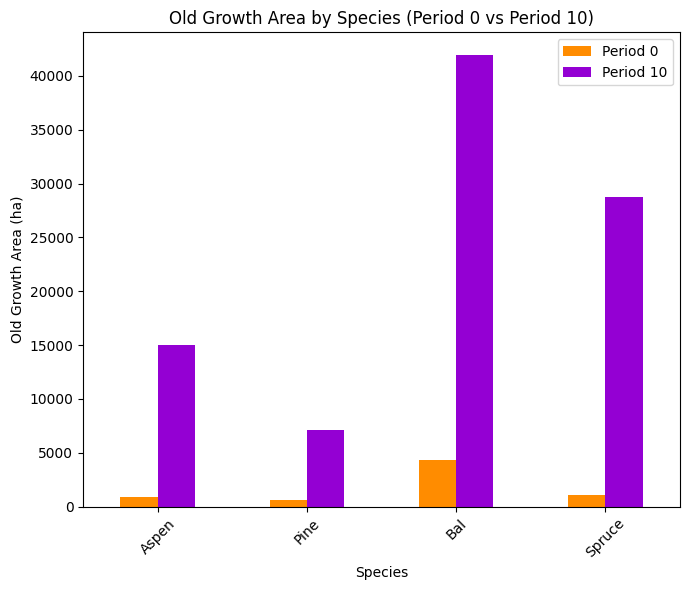

Clustered column plot saved to ./outputs/fig/redchris/redchris_min_em_redchrs_AAC_80%_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.7510

Diversity has **decreased** by 13.39% from time 0 to time 10.


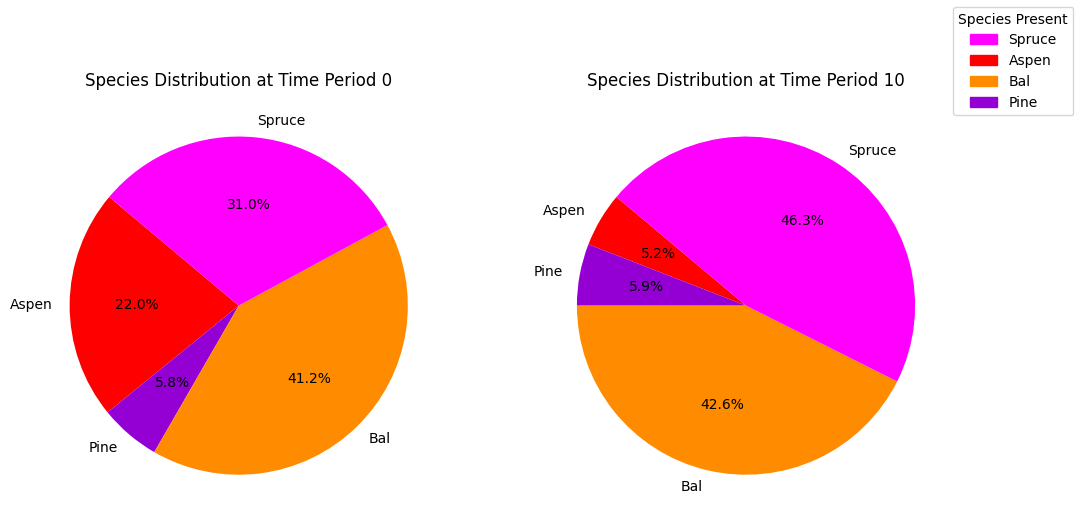

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_em_redchrs_AAC_80%_species_pie.pdf
running business as usual scenario for the Red Chris mining site,
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0x50c64669
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [2e-02, 1e+07]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 2005 columns
Presolve time: 0.15s
Presolved: 1699 rows, 32528 columns, 422291 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time:

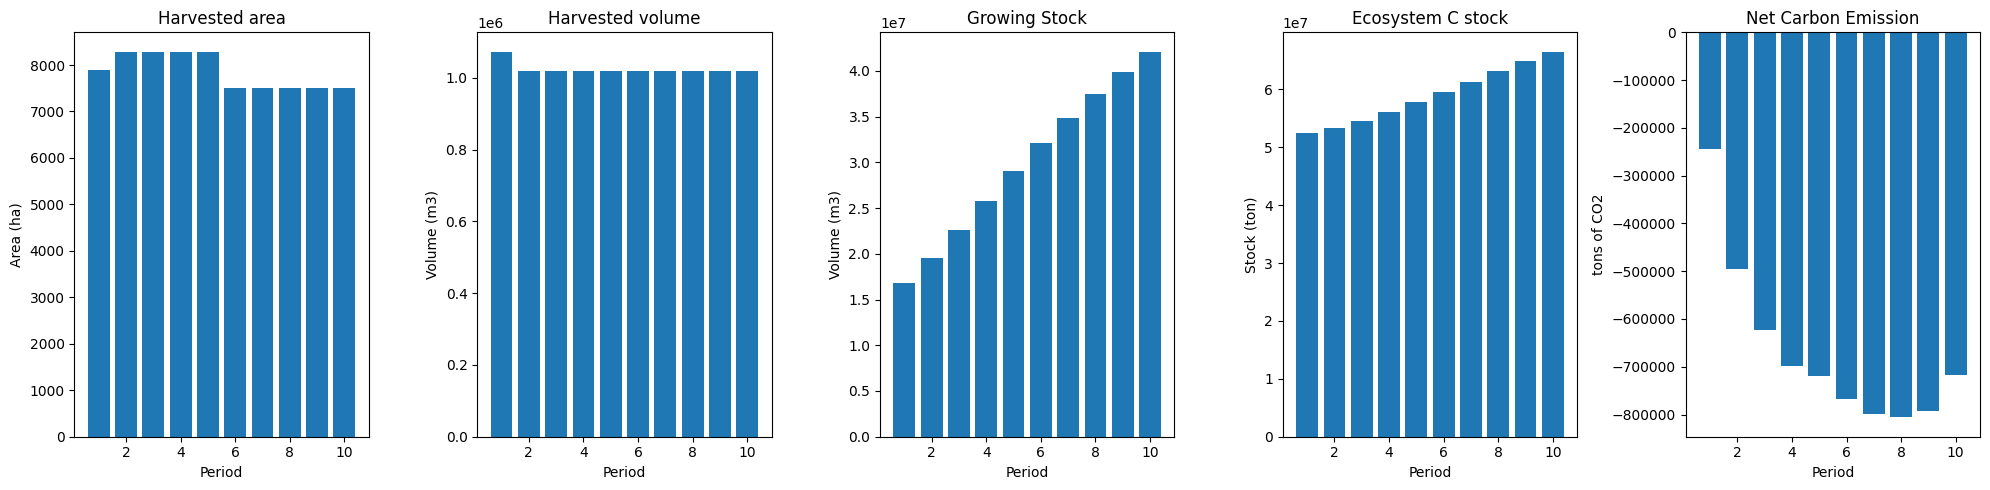

Plot saved to ./outputs/fig/redchris/redchris_min_em_bau_redchrs_scheduling_minemission.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  10831
The economic indicator (the provincial government revenues) is:  369393
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


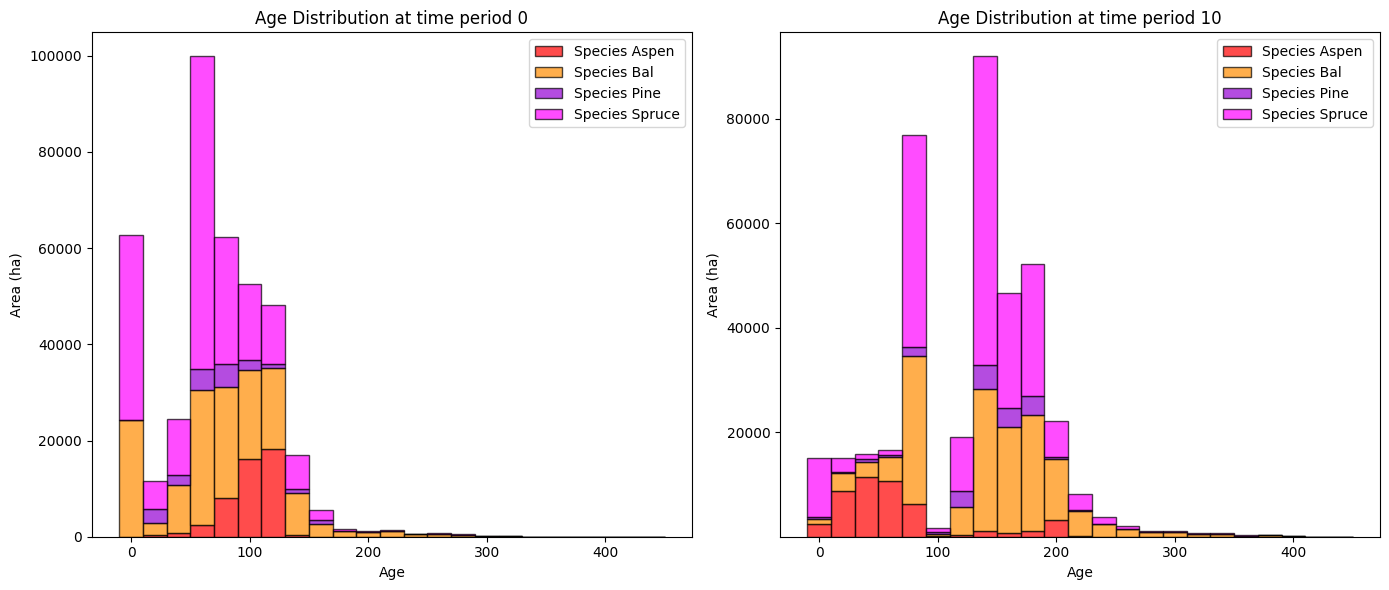

Plot saved to ./outputs/fig/redchris/redchris_min_em_bau_redchrs_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688   5435.179883   4489.866195
Pine     602.782616   6472.028996   5869.246380
Bal     4315.588546  38717.863313  34402.274766
Spruce  1072.814408  26003.989976  24931.175569

Old growth has **increased** by 69692.56 hectares from time period 0 to time period 10.


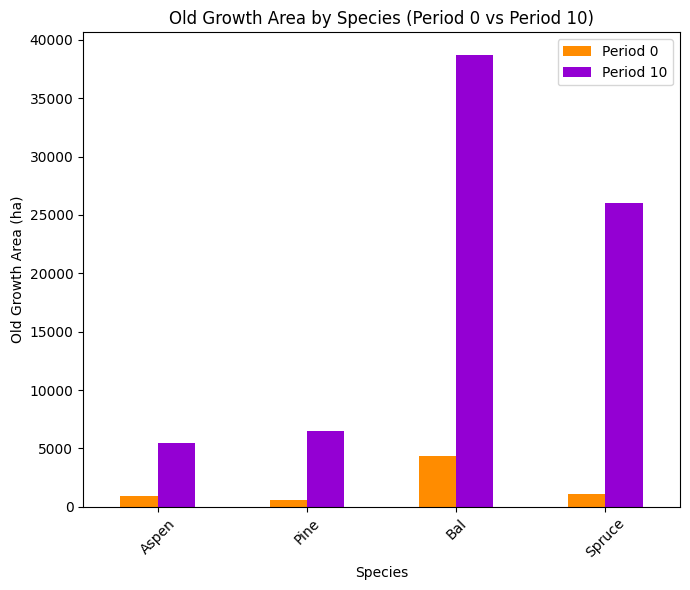

Clustered column plot saved to ./outputs/fig/redchris/redchris_min_em_bau_redchrs_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.7207

Diversity has **decreased** by 16.41% from time 0 to time 10.


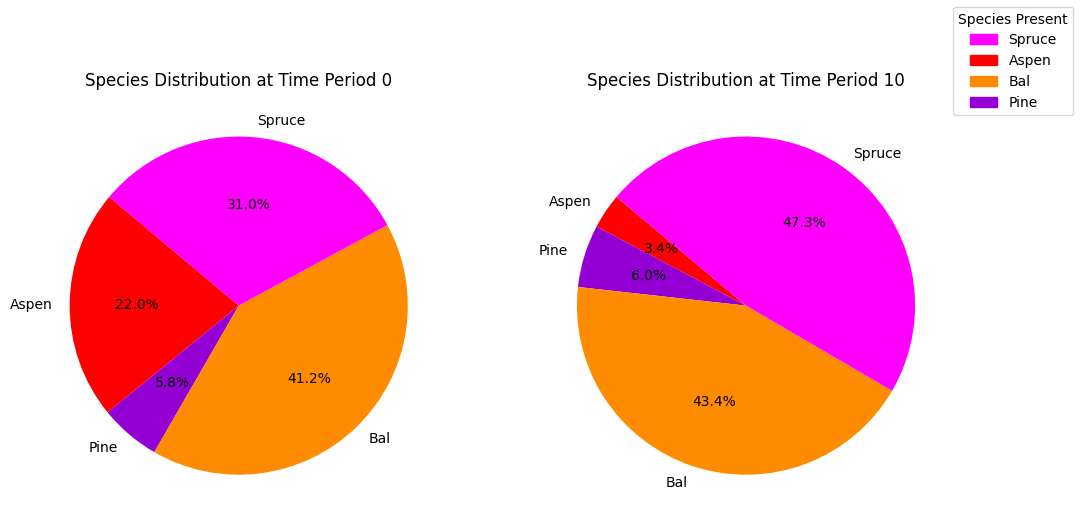

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_em_bau_redchrs_species_pie.pdf


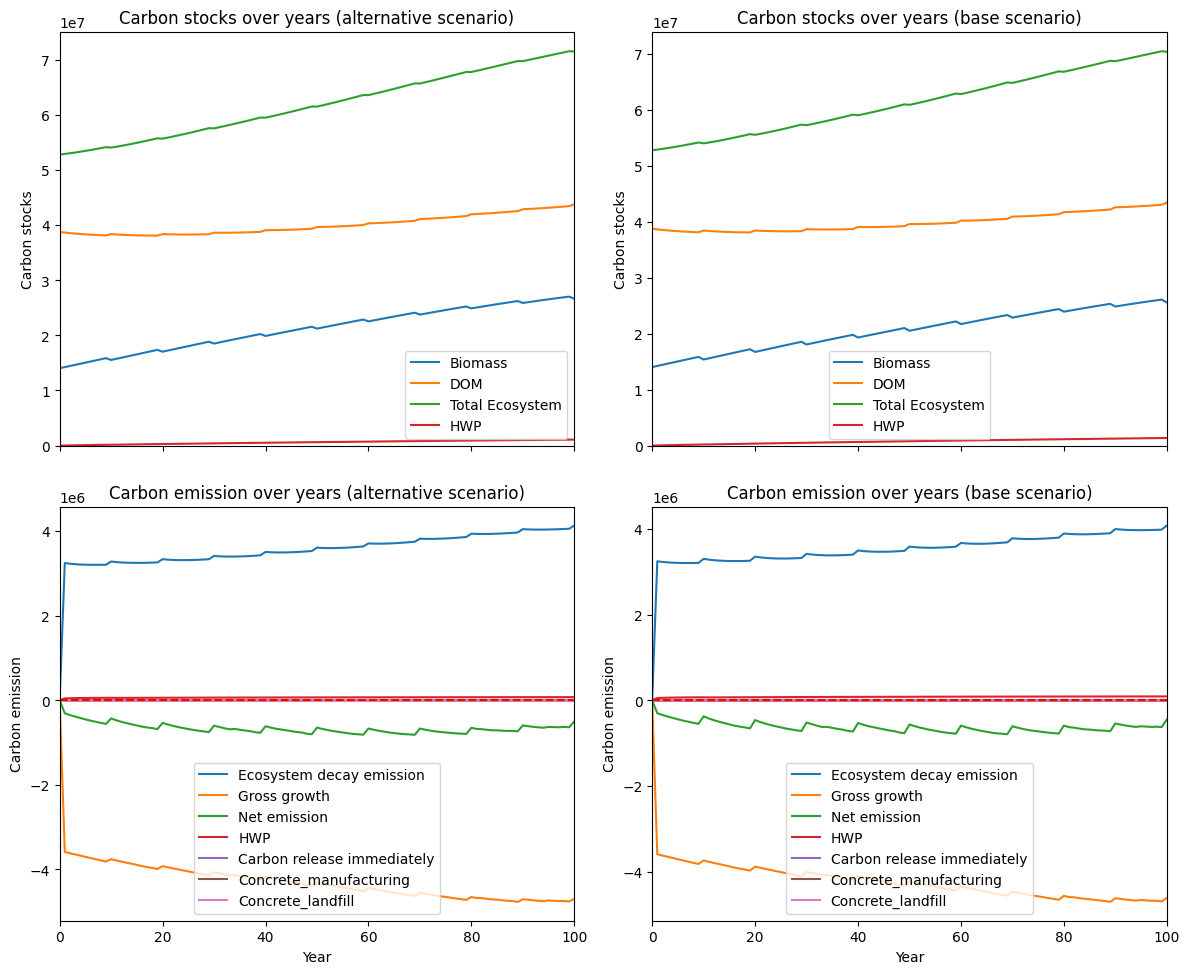

---------------------------------------------------------------------------------------
Net emission difference -4458190.8636864275
Net emission base scenario -62345424.357902035
Net emission alternative scenario -66803615.22158845
dollar_per_ton is:  2.2430623330763173
Comparison of Old Growth Areas (Alternative - Base)
          0           10   Difference
Aspen   0.0  9541.707302  9541.707302
Pine    0.0   651.110127   651.110127
Bal     0.0  3223.298782  3223.298782
Spruce  0.0  2710.142330  2710.142330

Overall, the old growth area has **increased** by 16126.26 hectares in the alternative scenario compared to the base scenario.


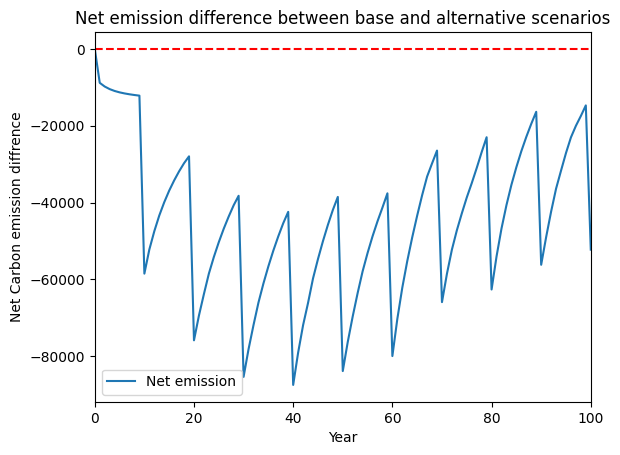

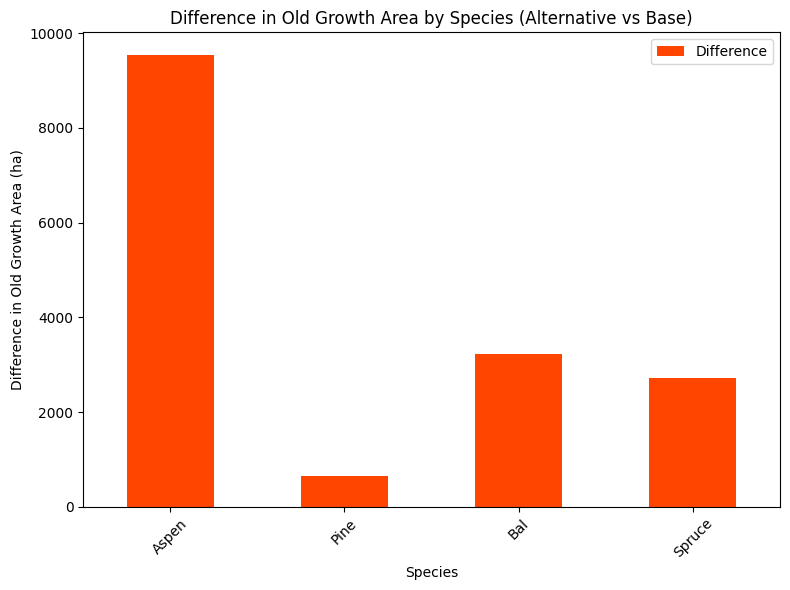

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/redchris/redchris_min_em_kpi_age_difference.pdf


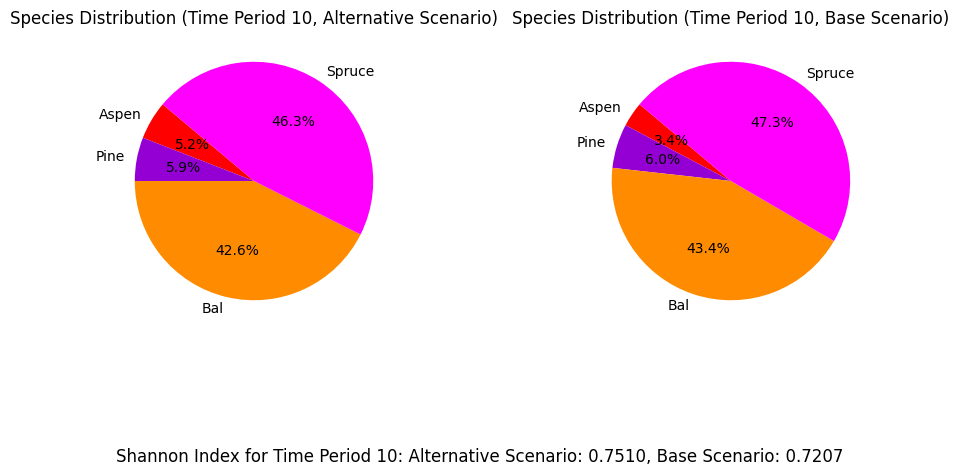

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_em_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for redchris_min_em_redchrs_AAC_70%...
running the scenario for the Red Chris mining site (70%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0x04823ef5
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [2e-02, 1e+07]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 2005 columns
Presolve time: 0.13s
Presolved: 1699 rows, 32529 column

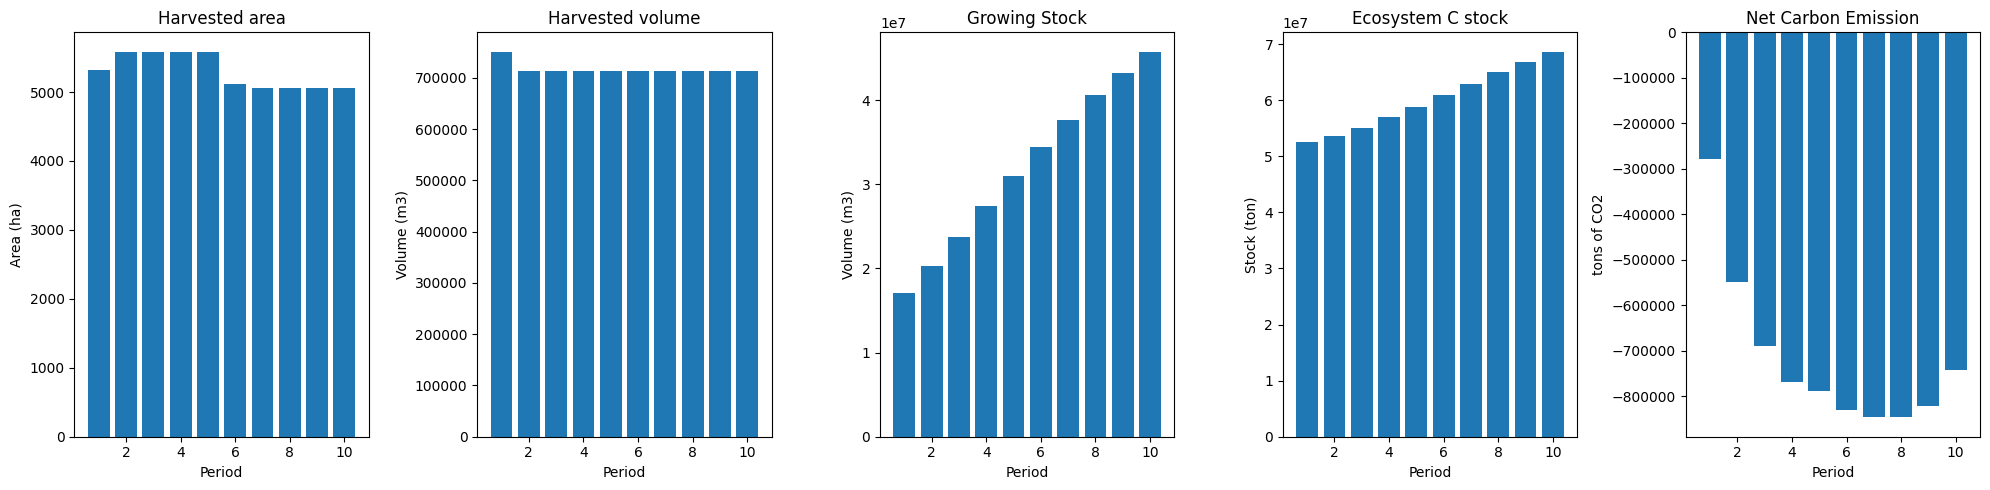

Plot saved to ./outputs/fig/redchris/redchris_min_em_redchrs_AAC_70%_scheduling_minemission.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  7582
The economic indicator (the provincial government revenues) is:  258575
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


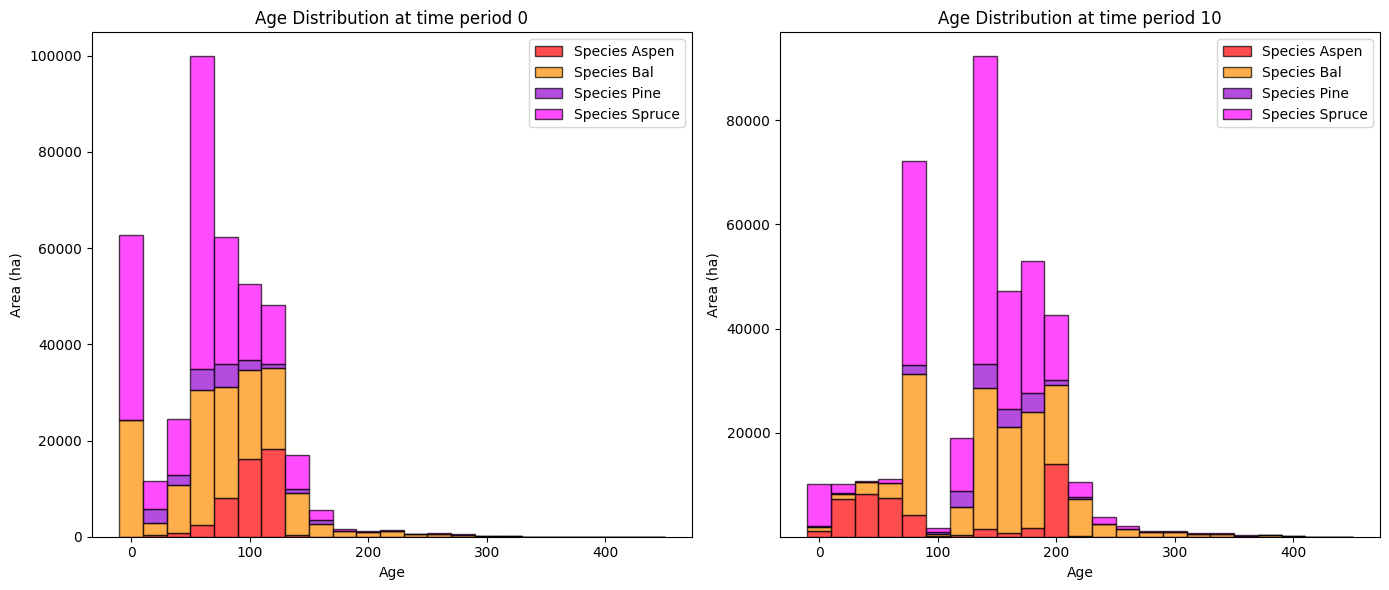

Plot saved to ./outputs/fig/redchris/redchris_min_em_redchrs_AAC_70%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  17029.089255  16083.775567
Pine     602.782616   7354.553582   6751.770966
Bal     4315.588546  44114.008758  39798.420212
Spruce  1072.814408  31027.086114  29954.271706

Old growth has **increased** by 92588.24 hectares from time period 0 to time period 10.


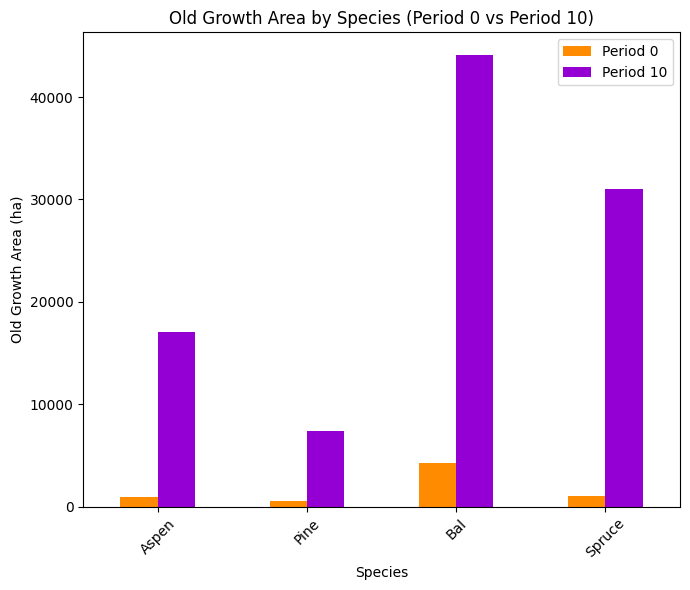

Clustered column plot saved to ./outputs/fig/redchris/redchris_min_em_redchrs_AAC_70%_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.7538

Diversity has **decreased** by 13.10% from time 0 to time 10.


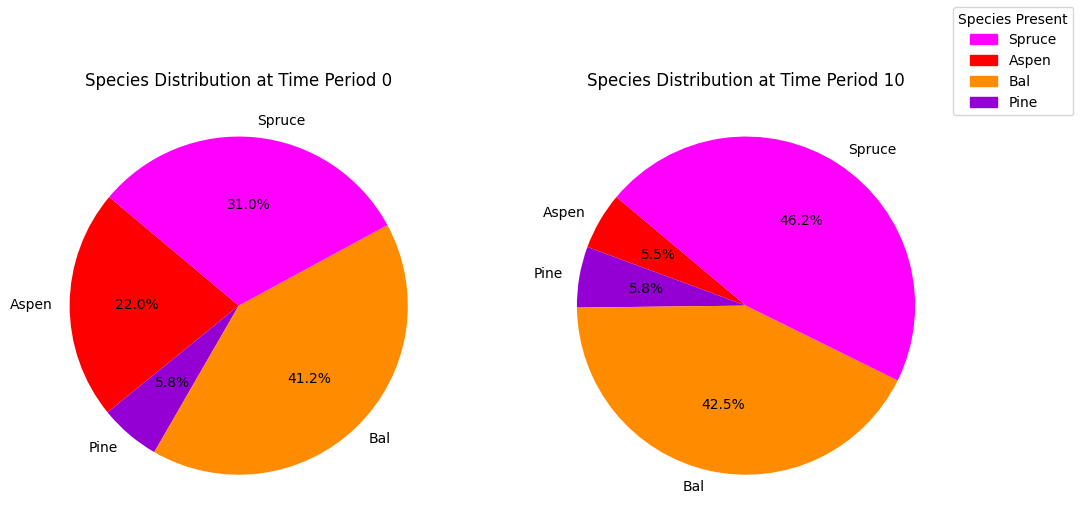

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_em_redchrs_AAC_70%_species_pie.pdf
running business as usual scenario for the Red Chris mining site,
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0x50c64669
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [2e-02, 1e+07]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 2005 columns
Presolve time: 0.12s
Presolved: 1699 rows, 32528 columns, 422291 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time:

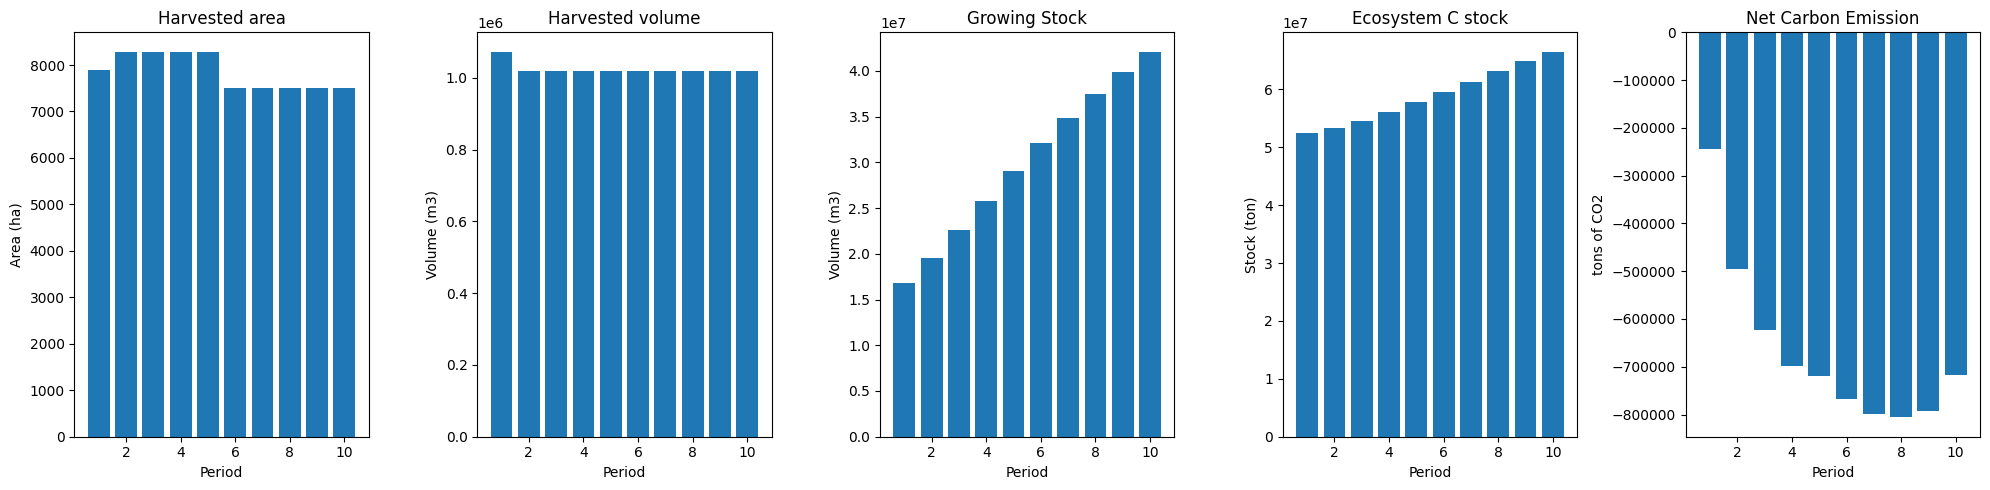

Plot saved to ./outputs/fig/redchris/redchris_min_em_bau_redchrs_scheduling_minemission.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  10831
The economic indicator (the provincial government revenues) is:  369393
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


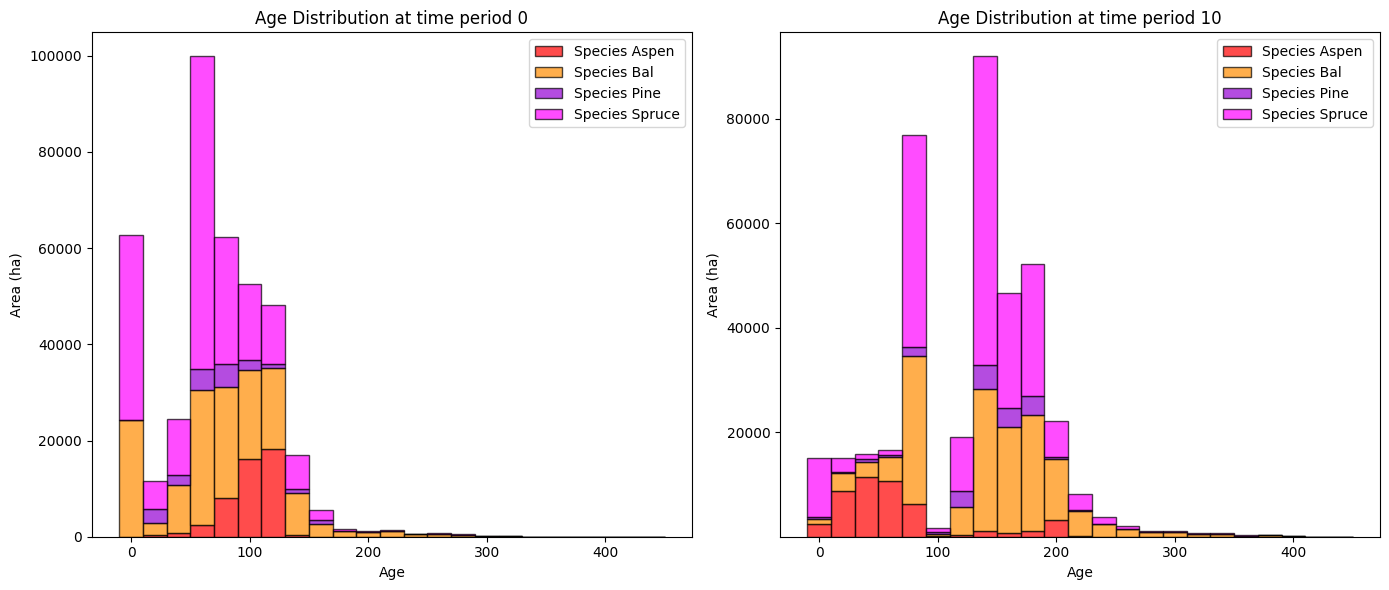

Plot saved to ./outputs/fig/redchris/redchris_min_em_bau_redchrs_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688   5435.179883   4489.866195
Pine     602.782616   6472.028996   5869.246380
Bal     4315.588546  38717.863313  34402.274766
Spruce  1072.814408  26003.989976  24931.175569

Old growth has **increased** by 69692.56 hectares from time period 0 to time period 10.


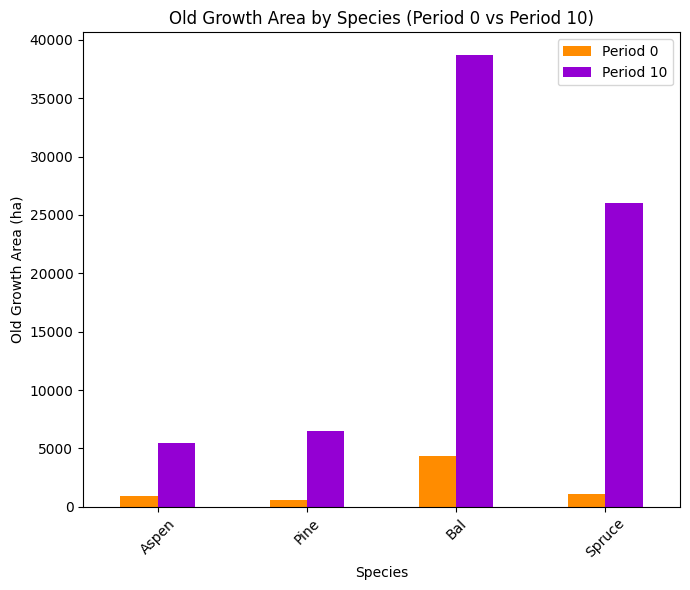

Clustered column plot saved to ./outputs/fig/redchris/redchris_min_em_bau_redchrs_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.7207

Diversity has **decreased** by 16.41% from time 0 to time 10.


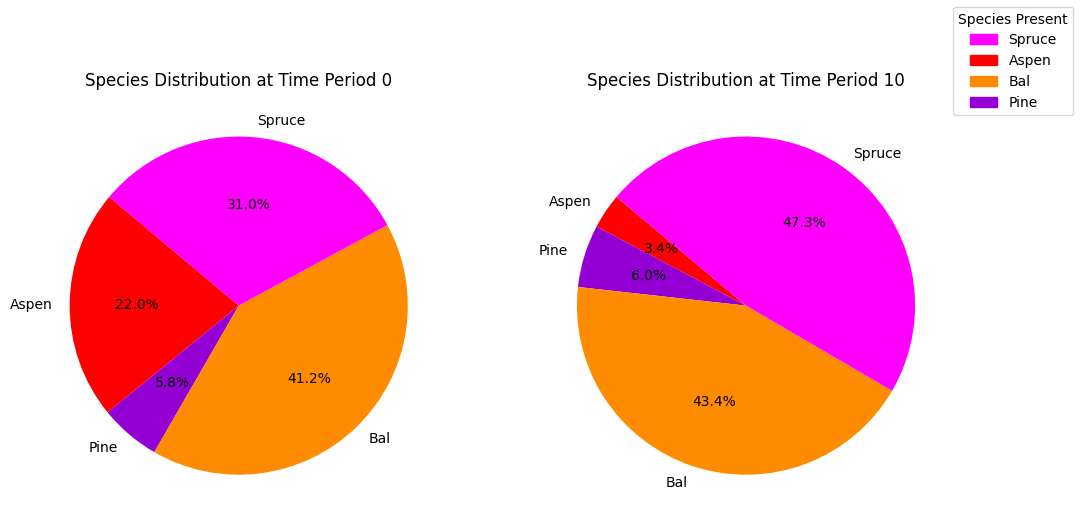

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_em_bau_redchrs_species_pie.pdf


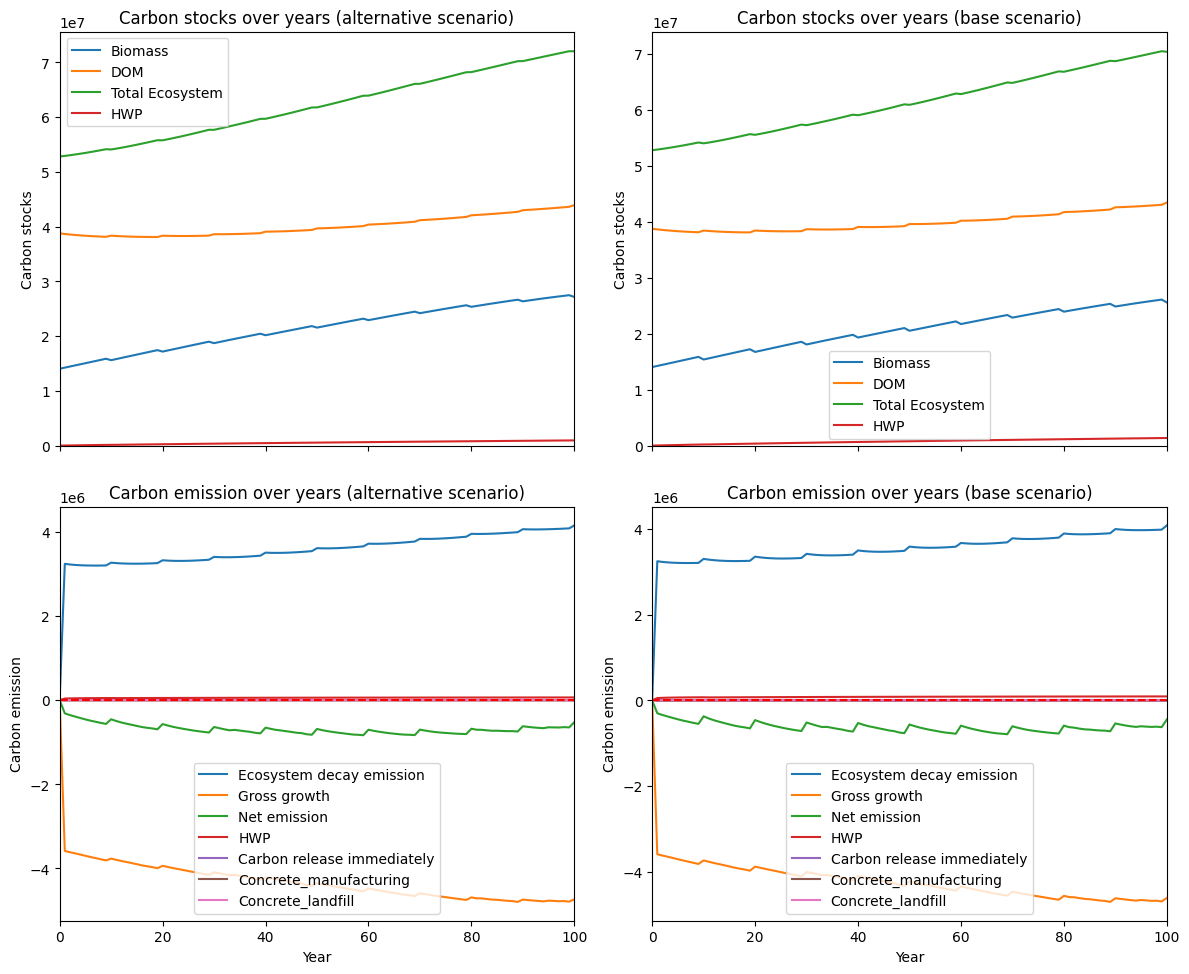

---------------------------------------------------------------------------------------
Net emission difference -6568881.4191986015
Net emission base scenario -62345424.357902035
Net emission alternative scenario -68914305.77710064
dollar_per_ton is:  1.5223292006418945
Comparison of Old Growth Areas (Alternative - Base)
          0            10    Difference
Aspen   0.0  11593.909372  11593.909372
Pine    0.0    882.524586    882.524586
Bal     0.0   5396.145445   5396.145445
Spruce  0.0   5023.096138   5023.096138

Overall, the old growth area has **increased** by 22895.68 hectares in the alternative scenario compared to the base scenario.


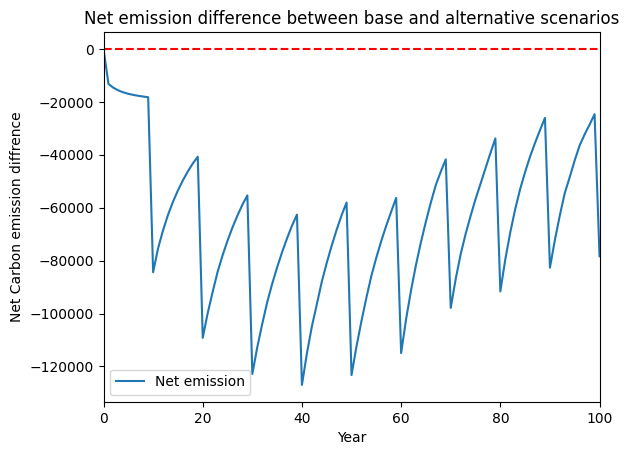

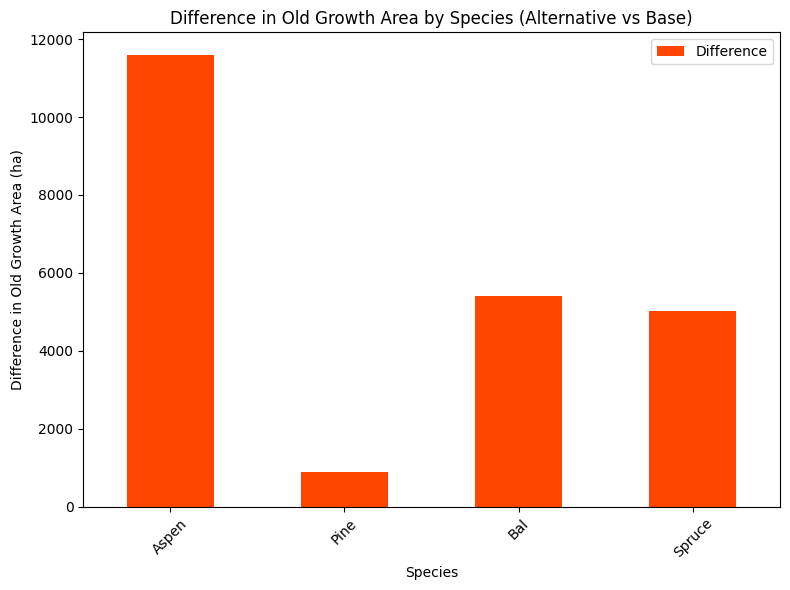

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/redchris/redchris_min_em_kpi_age_difference.pdf


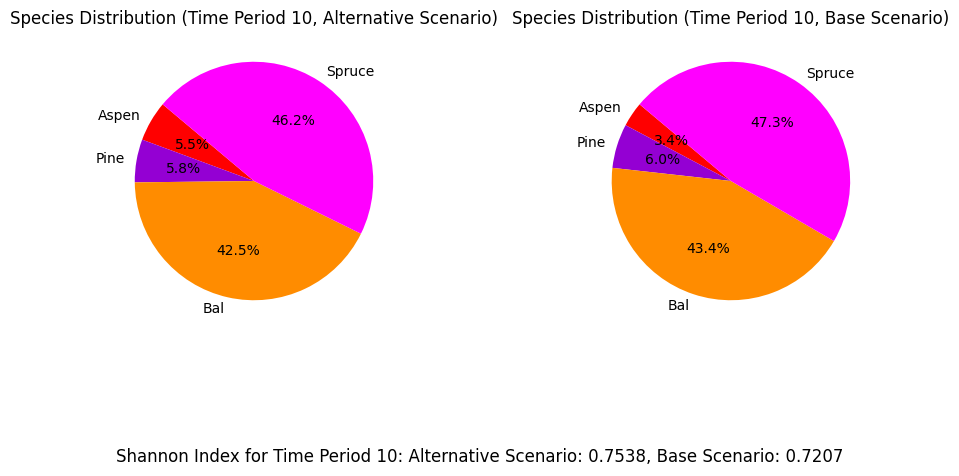

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_em_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for redchris_min_em_redchrs_AAC_60%...
running the scenario for the Red Chris mining site (60%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0x2bd291b9
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [2e-02, 1e+07]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 2005 columns
Presolve time: 0.18s
Presolved: 1699 rows, 32529 column

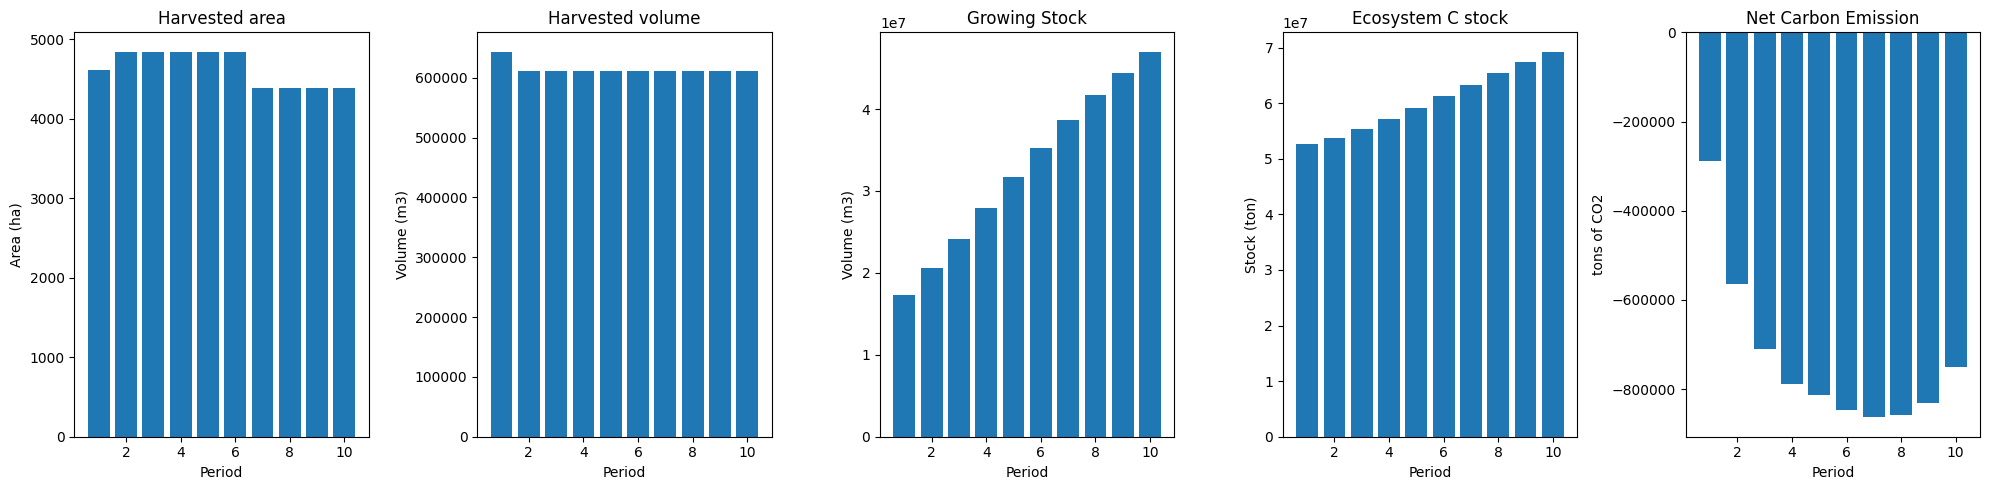

Plot saved to ./outputs/fig/redchris/redchris_min_em_redchrs_AAC_60%_scheduling_minemission.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  6499
The economic indicator (the provincial government revenues) is:  221636
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


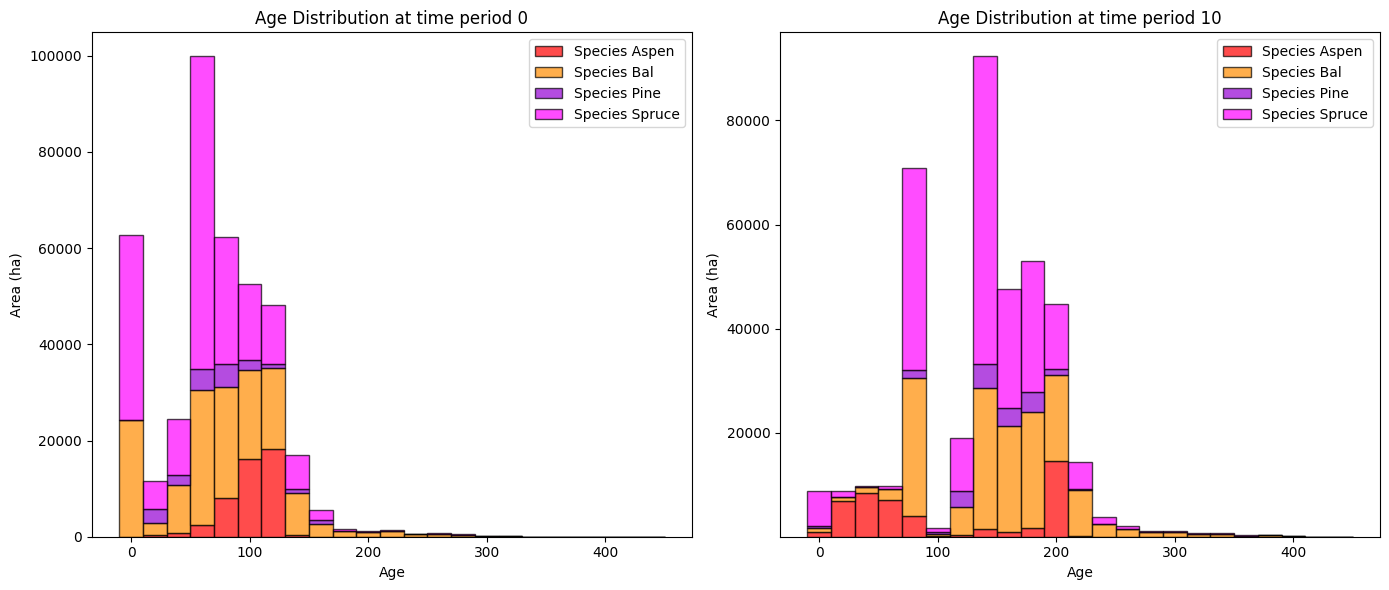

Plot saved to ./outputs/fig/redchris/redchris_min_em_redchrs_AAC_60%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  17843.077109  16897.763421
Pine     602.782616   7589.639377   6986.856761
Bal     4315.588546  46924.378319  42608.789773
Spruce  1072.814408  33290.033407  32217.218999

Old growth has **increased** by 98710.63 hectares from time period 0 to time period 10.


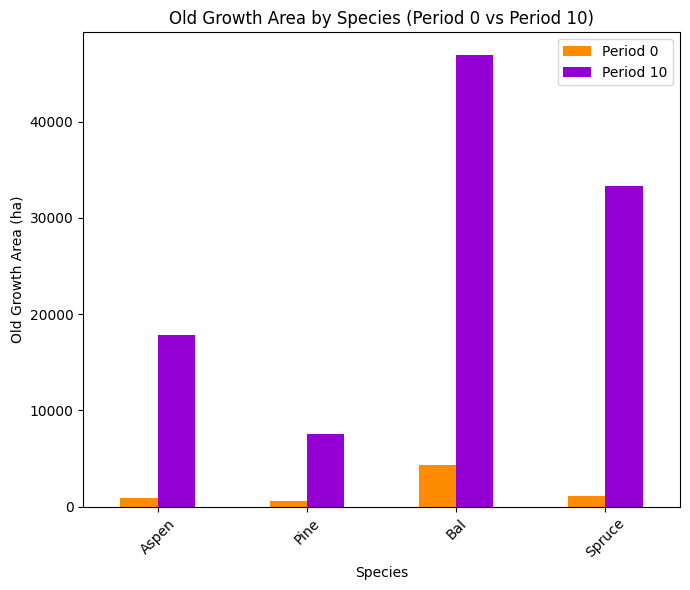

Clustered column plot saved to ./outputs/fig/redchris/redchris_min_em_redchrs_AAC_60%_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.7541

Diversity has **decreased** by 13.08% from time 0 to time 10.


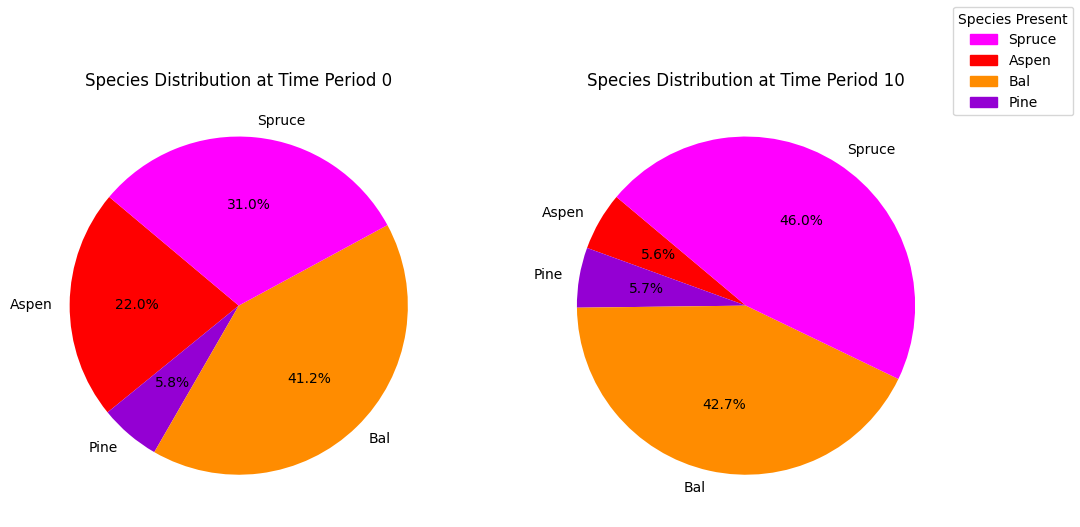

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_em_redchrs_AAC_60%_species_pie.pdf
running business as usual scenario for the Red Chris mining site,
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0x50c64669
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [2e-02, 1e+07]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 2005 columns
Presolve time: 0.18s
Presolved: 1699 rows, 32528 columns, 422291 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time:

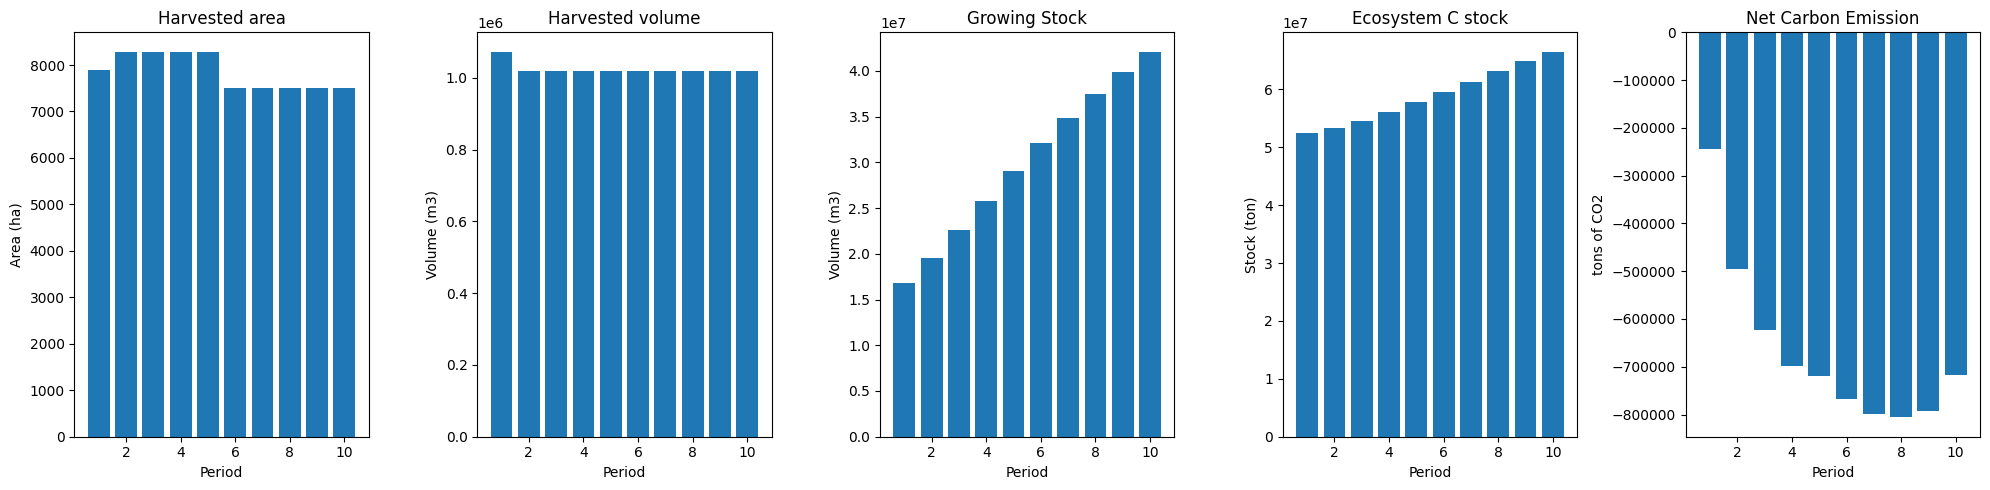

Plot saved to ./outputs/fig/redchris/redchris_min_em_bau_redchrs_scheduling_minemission.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  10831
The economic indicator (the provincial government revenues) is:  369393
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


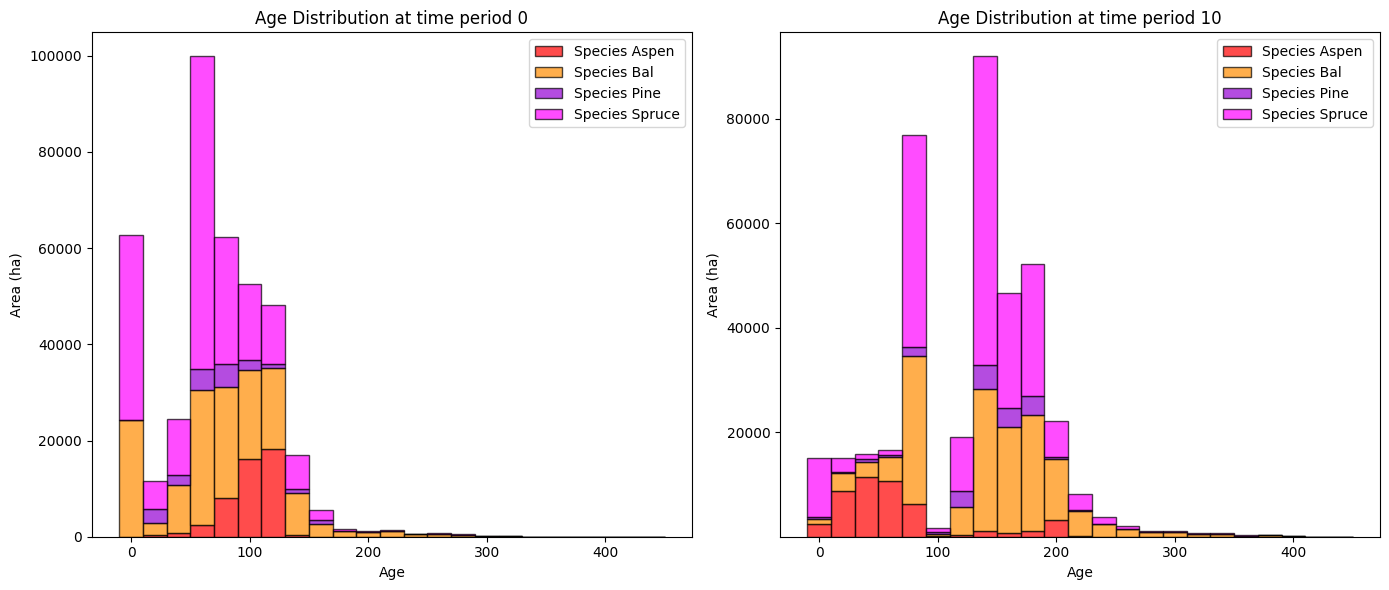

Plot saved to ./outputs/fig/redchris/redchris_min_em_bau_redchrs_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688   5435.179883   4489.866195
Pine     602.782616   6472.028996   5869.246380
Bal     4315.588546  38717.863313  34402.274766
Spruce  1072.814408  26003.989976  24931.175569

Old growth has **increased** by 69692.56 hectares from time period 0 to time period 10.


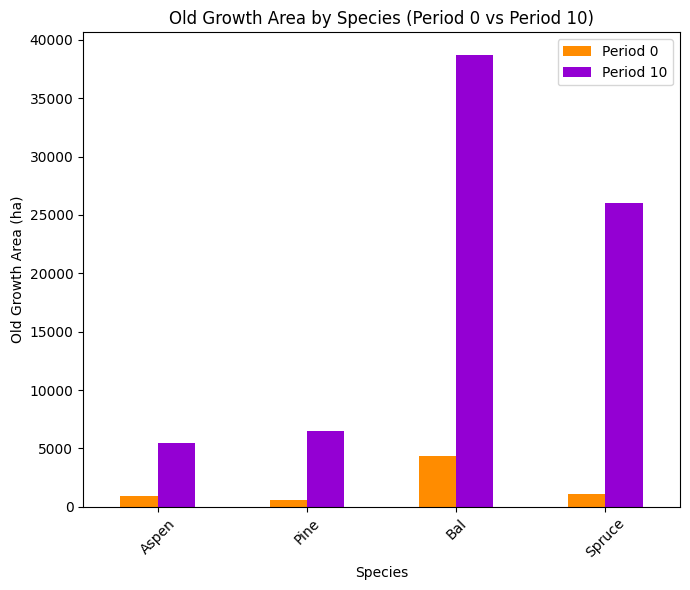

Clustered column plot saved to ./outputs/fig/redchris/redchris_min_em_bau_redchrs_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.7207

Diversity has **decreased** by 16.41% from time 0 to time 10.


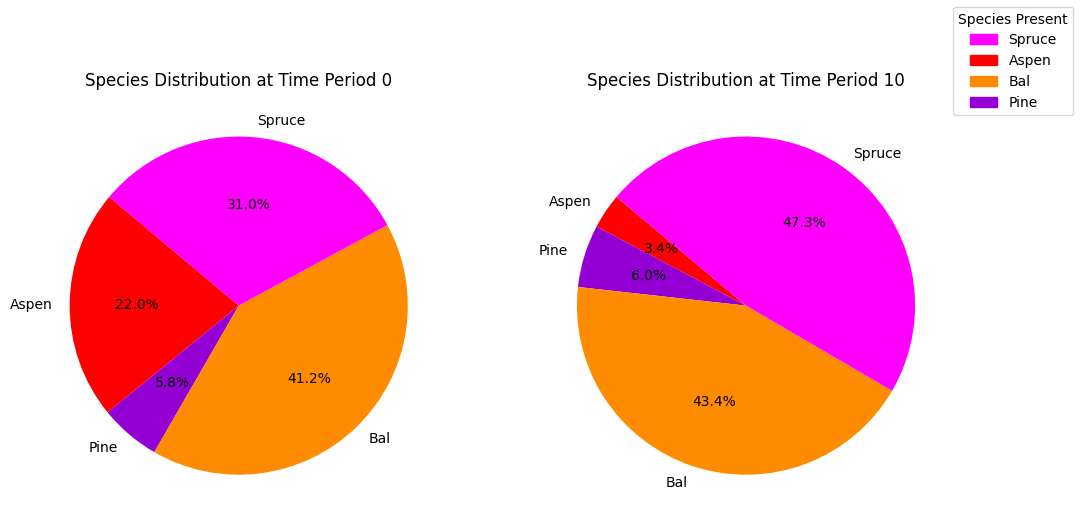

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_em_bau_redchrs_species_pie.pdf


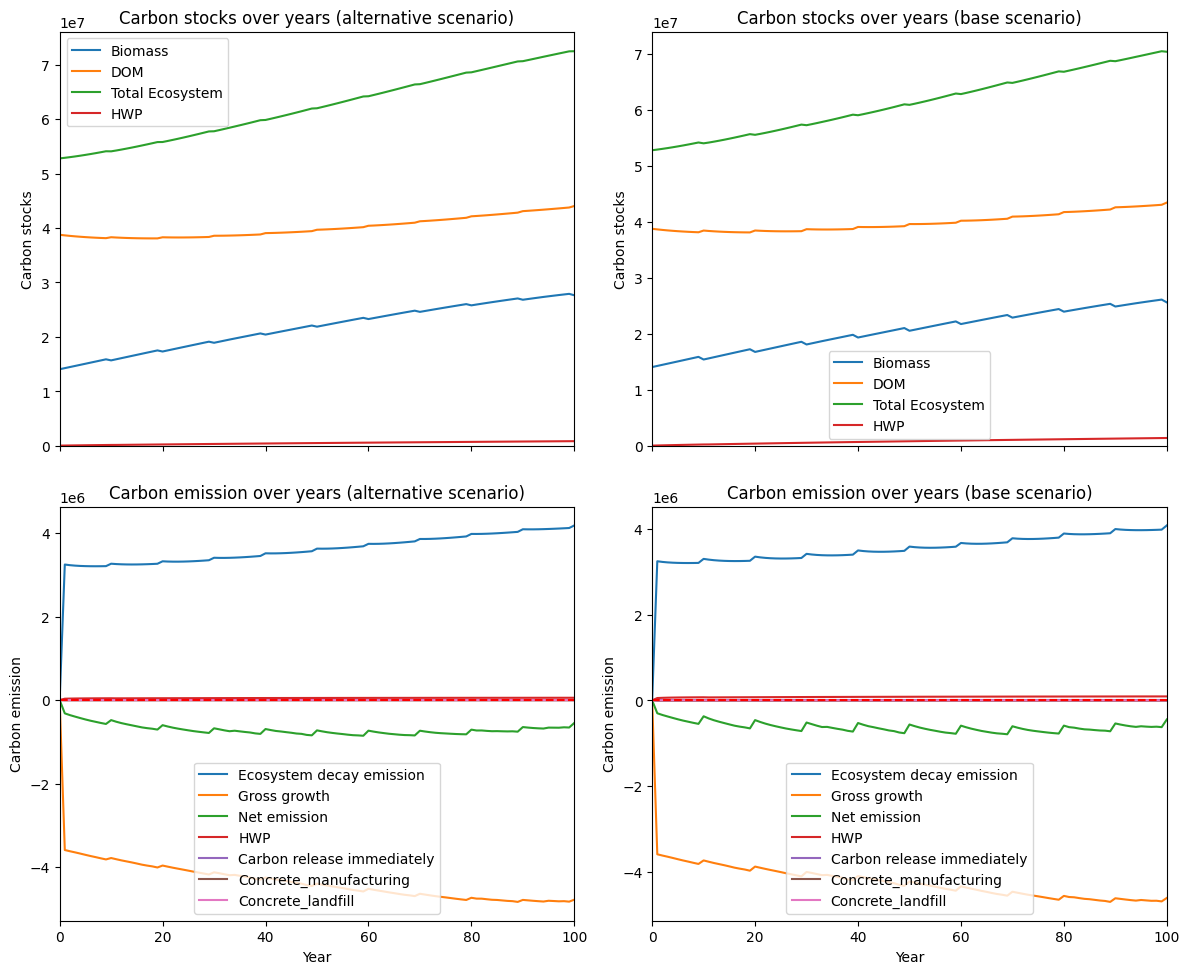

---------------------------------------------------------------------------------------
Net emission difference -8613889.742780378
Net emission base scenario -62345424.357902035
Net emission alternative scenario -70959314.10068241
dollar_per_ton is:  1.1609157185209356
Comparison of Old Growth Areas (Alternative - Base)
          0            10    Difference
Aspen   0.0  12407.897226  12407.897226
Pine    0.0   1117.610381   1117.610381
Bal     0.0   8206.515006   8206.515006
Spruce  0.0   7286.043431   7286.043431

Overall, the old growth area has **increased** by 29018.07 hectares in the alternative scenario compared to the base scenario.


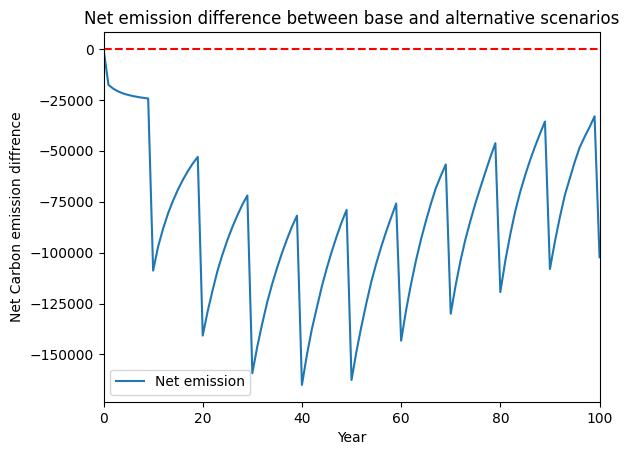

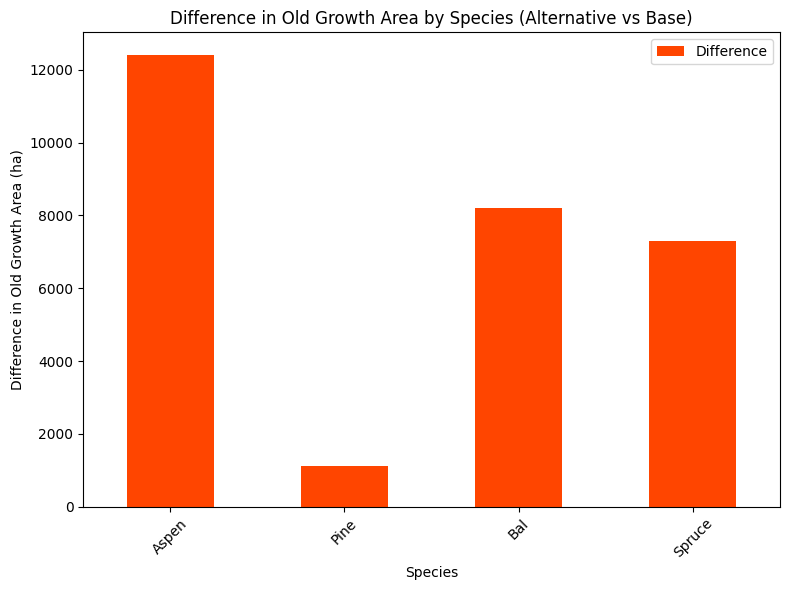

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/redchris/redchris_min_em_kpi_age_difference.pdf


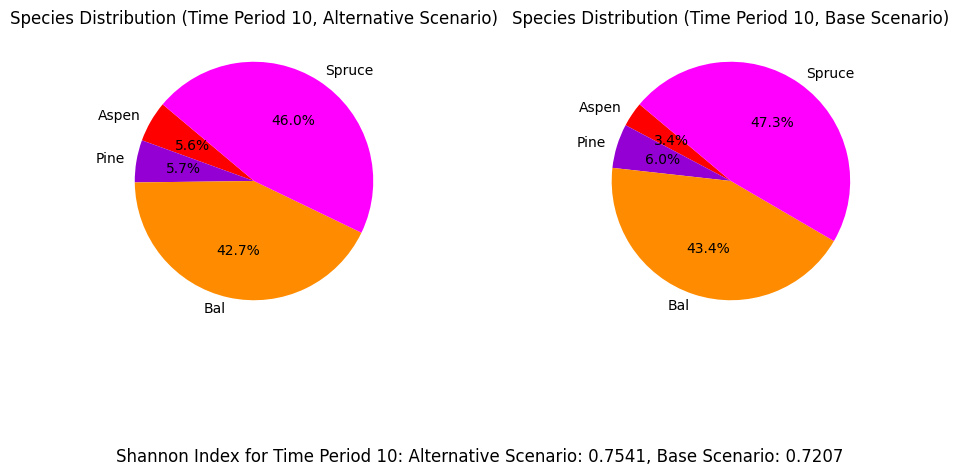

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_em_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for redchris_min_em_redchrs_AAC_50%...
running the scenario for the Red Chris mining site (50%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0x3d596850
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [2e-02, 1e+07]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 2005 columns
Presolve time: 0.18s
Presolved: 1699 rows, 32529 column

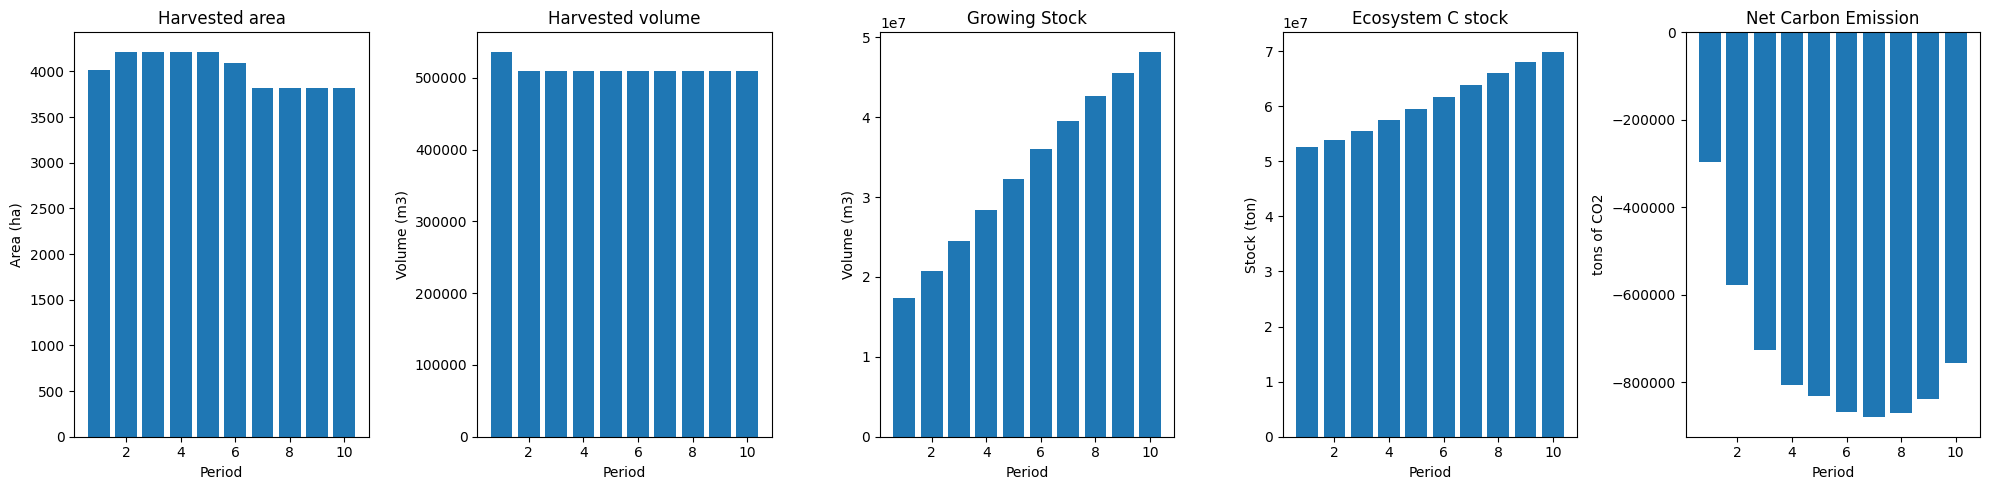

Plot saved to ./outputs/fig/redchris/redchris_min_em_redchrs_AAC_50%_scheduling_minemission.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  5415
The economic indicator (the provincial government revenues) is:  184696
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


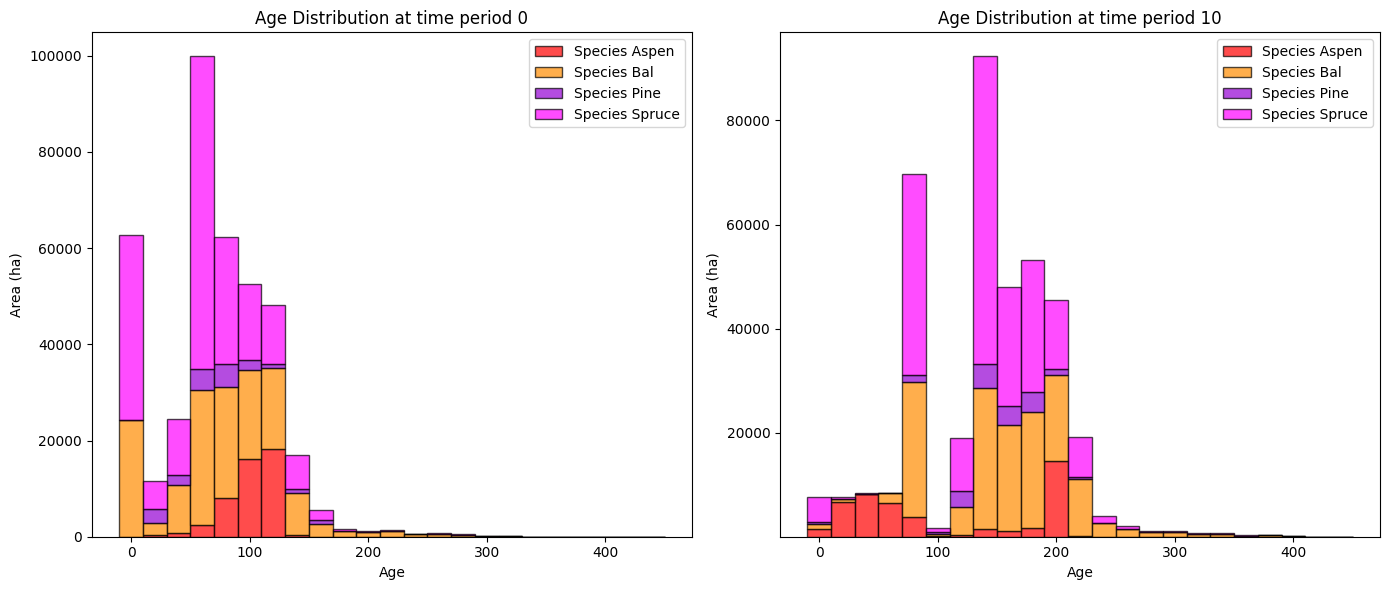

Plot saved to ./outputs/fig/redchris/redchris_min_em_redchrs_AAC_50%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  18121.408326  17176.094638
Pine     602.782616   7716.087974   7113.305357
Bal     4315.588546  49312.971228  44997.382682
Spruce  1072.814408  36194.265251  35121.450843

Old growth has **increased** by 104408.23 hectares from time period 0 to time period 10.


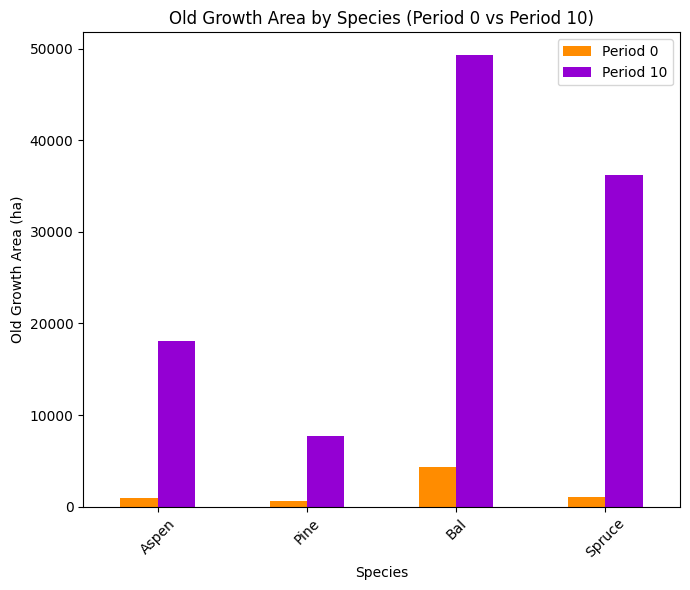

Clustered column plot saved to ./outputs/fig/redchris/redchris_min_em_redchrs_AAC_50%_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.7507

Diversity has **decreased** by 13.41% from time 0 to time 10.


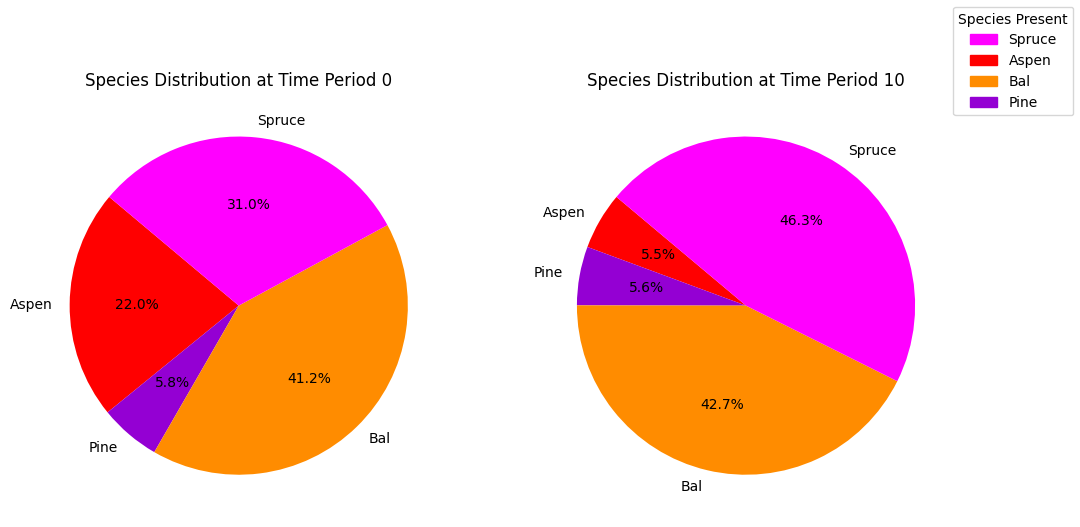

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_em_redchrs_AAC_50%_species_pie.pdf
running business as usual scenario for the Red Chris mining site,
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0x50c64669
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [2e-02, 1e+07]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 2005 columns
Presolve time: 0.12s
Presolved: 1699 rows, 32528 columns, 422291 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time:

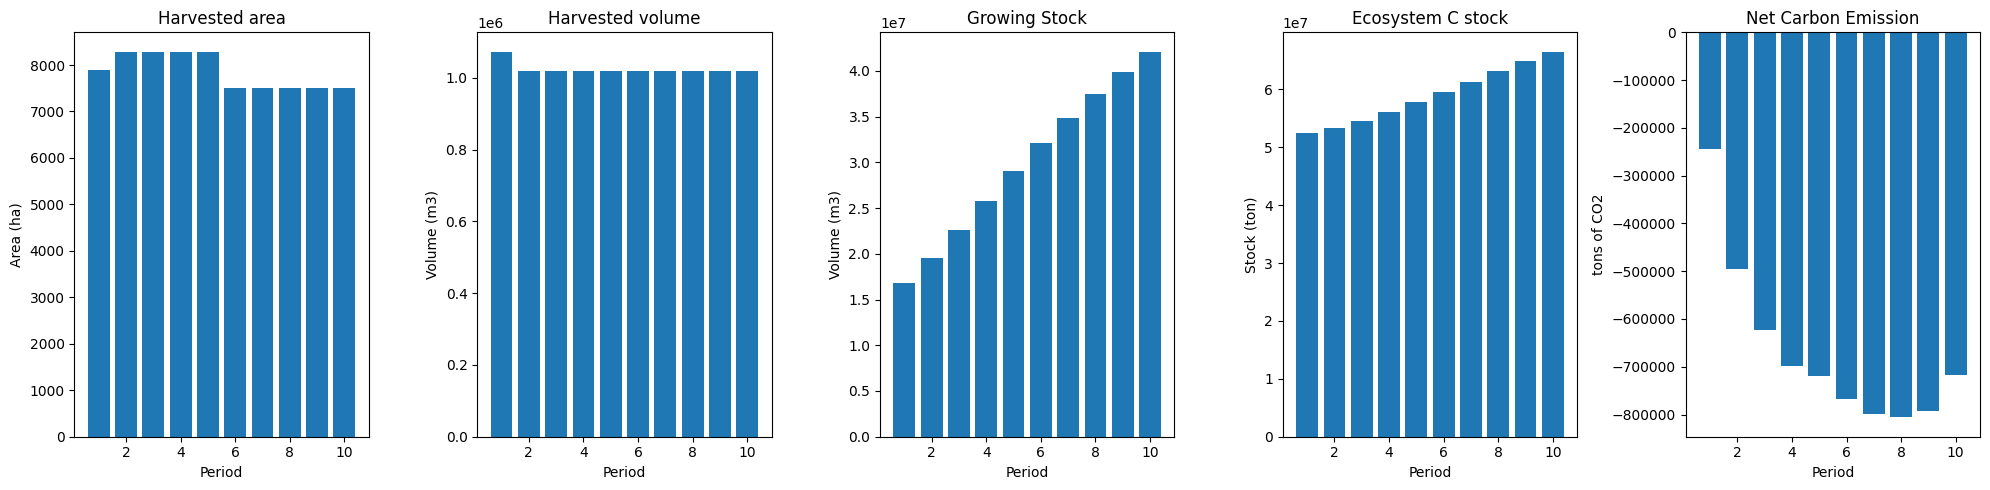

Plot saved to ./outputs/fig/redchris/redchris_min_em_bau_redchrs_scheduling_minemission.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  10831
The economic indicator (the provincial government revenues) is:  369393
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


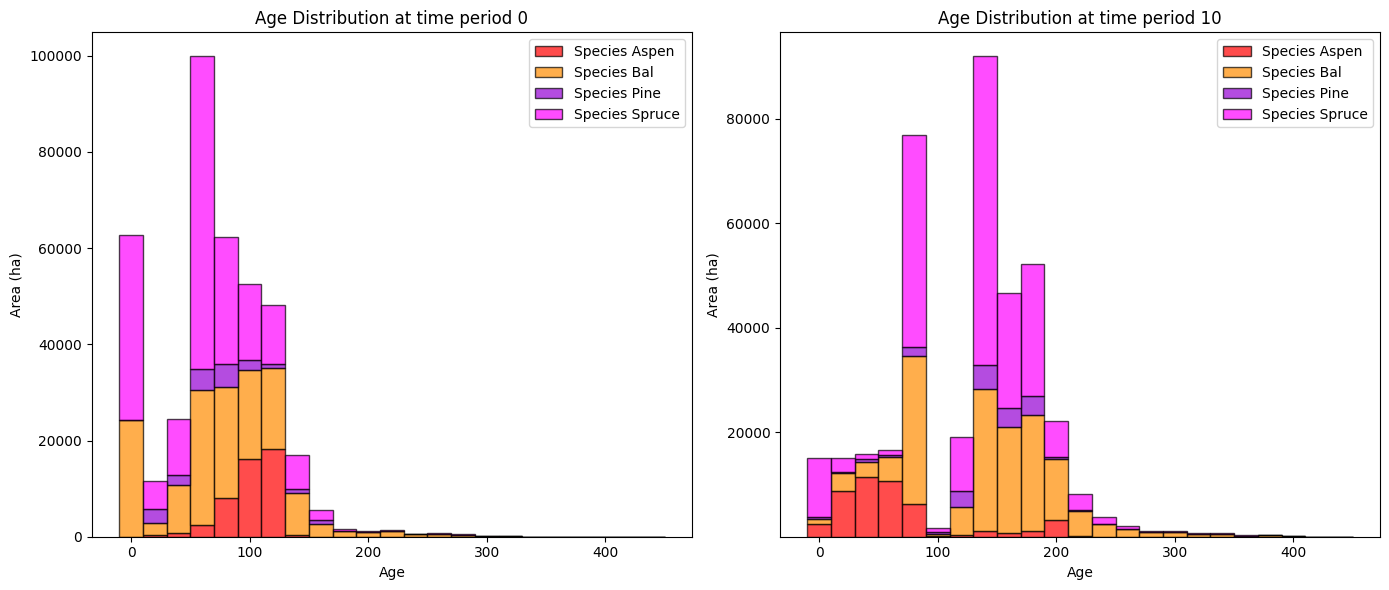

Plot saved to ./outputs/fig/redchris/redchris_min_em_bau_redchrs_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688   5435.179883   4489.866195
Pine     602.782616   6472.028996   5869.246380
Bal     4315.588546  38717.863313  34402.274766
Spruce  1072.814408  26003.989976  24931.175569

Old growth has **increased** by 69692.56 hectares from time period 0 to time period 10.


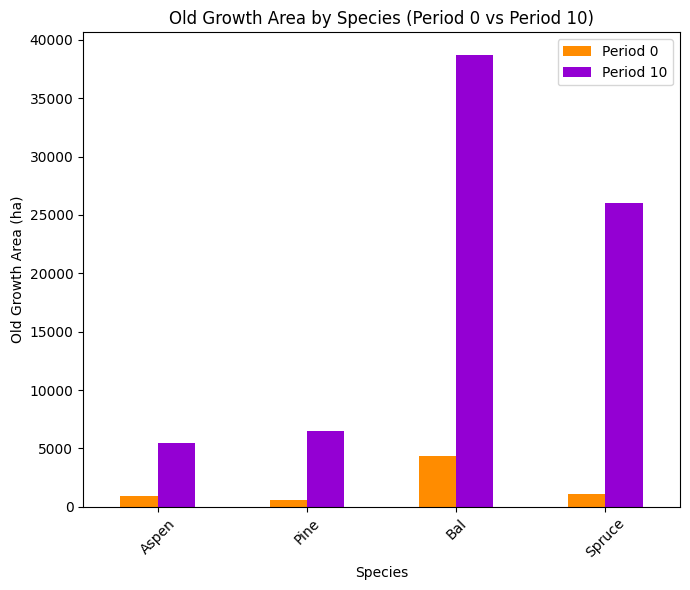

Clustered column plot saved to ./outputs/fig/redchris/redchris_min_em_bau_redchrs_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.7207

Diversity has **decreased** by 16.41% from time 0 to time 10.


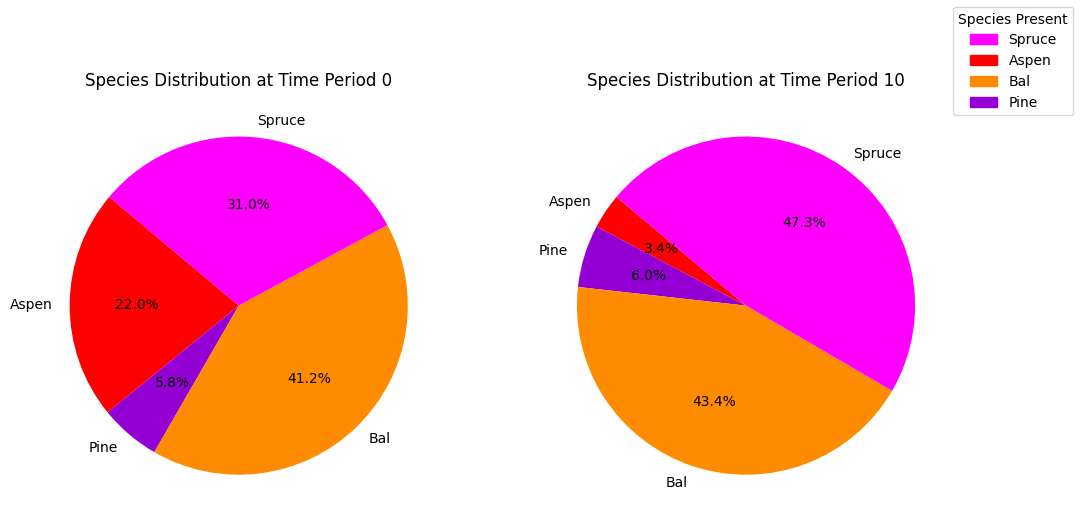

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_em_bau_redchrs_species_pie.pdf


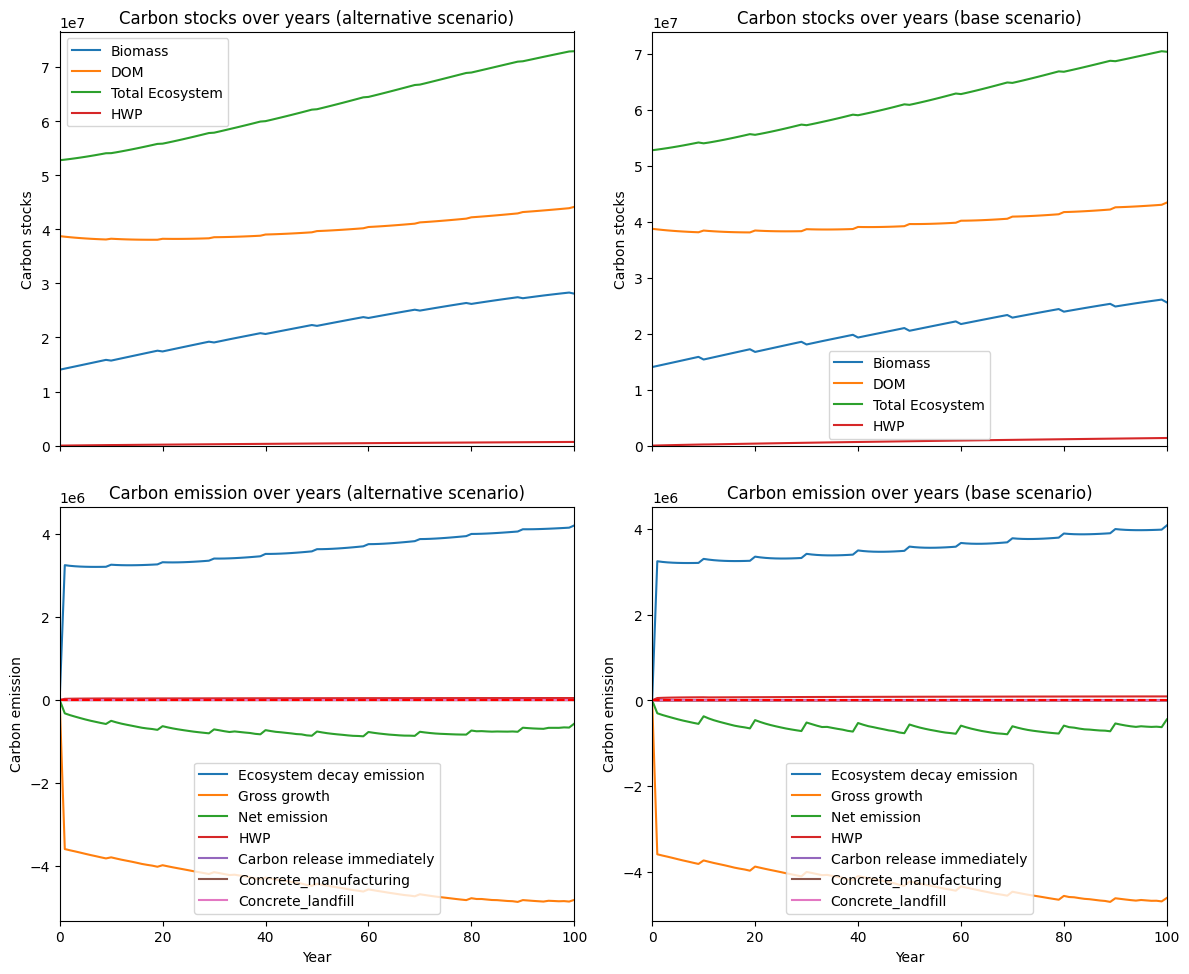

---------------------------------------------------------------------------------------
Net emission difference -10618484.685647355
Net emission base scenario -62345424.357902035
Net emission alternative scenario -72963909.04354937
dollar_per_ton is:  0.9417539598203367
Comparison of Old Growth Areas (Alternative - Base)
          0            10    Difference
Aspen   0.0  12686.228443  12686.228443
Pine    0.0   1244.058977   1244.058977
Bal     0.0  10595.107915  10595.107915
Spruce  0.0  10190.275274  10190.275274

Overall, the old growth area has **increased** by 34715.67 hectares in the alternative scenario compared to the base scenario.


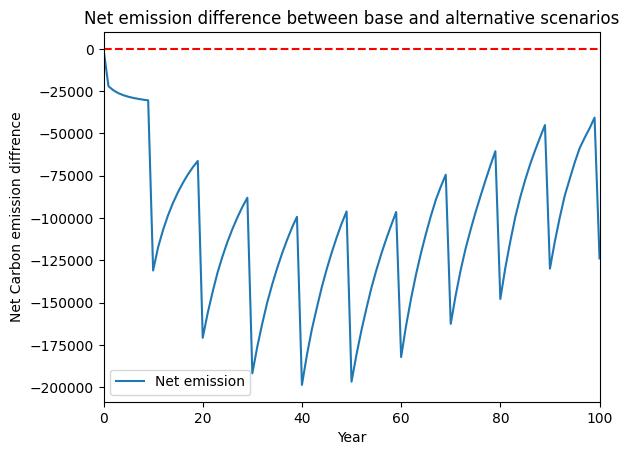

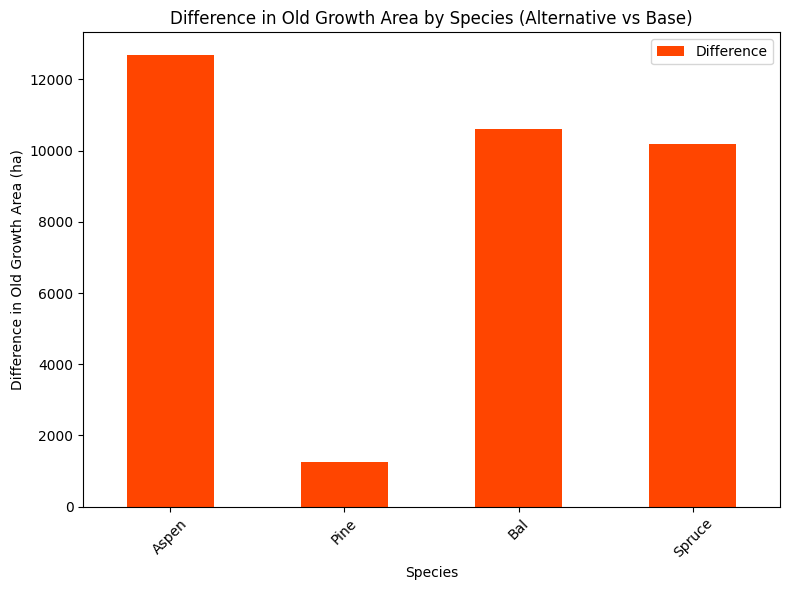

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/redchris/redchris_min_em_kpi_age_difference.pdf


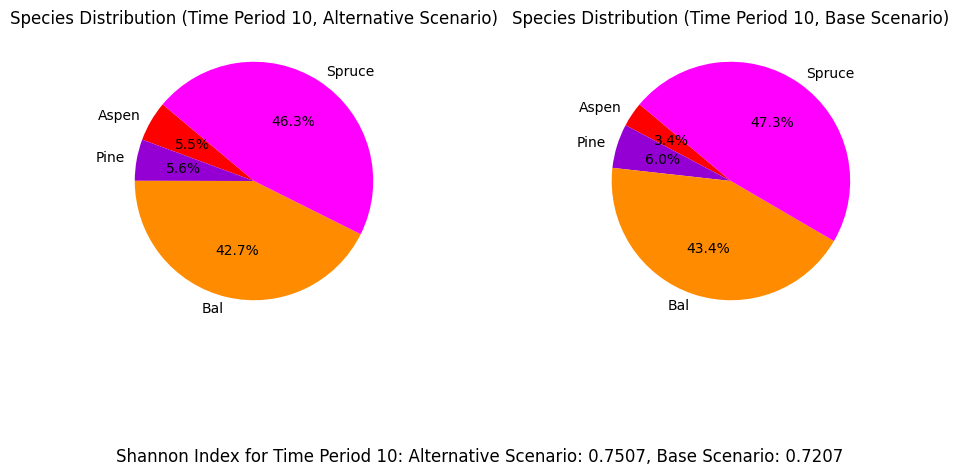

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_em_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for redchris_min_em_redchrs_AAC_40%...
running the scenario for the Red Chris mining site (40%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0x559643dd
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [2e-02, 1e+07]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 2005 columns
Presolve time: 0.14s
Presolved: 1699 rows, 32529 column

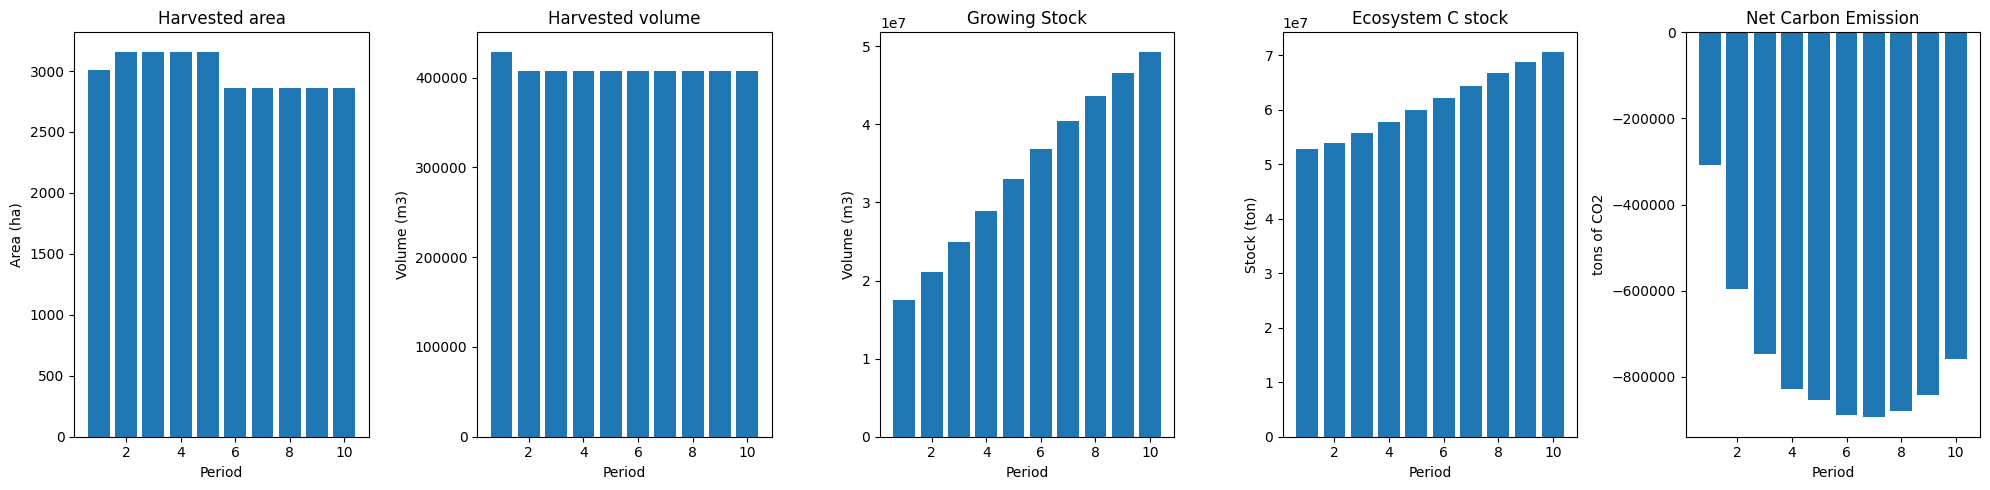

Plot saved to ./outputs/fig/redchris/redchris_min_em_redchrs_AAC_40%_scheduling_minemission.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  4332
The economic indicator (the provincial government revenues) is:  147757
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


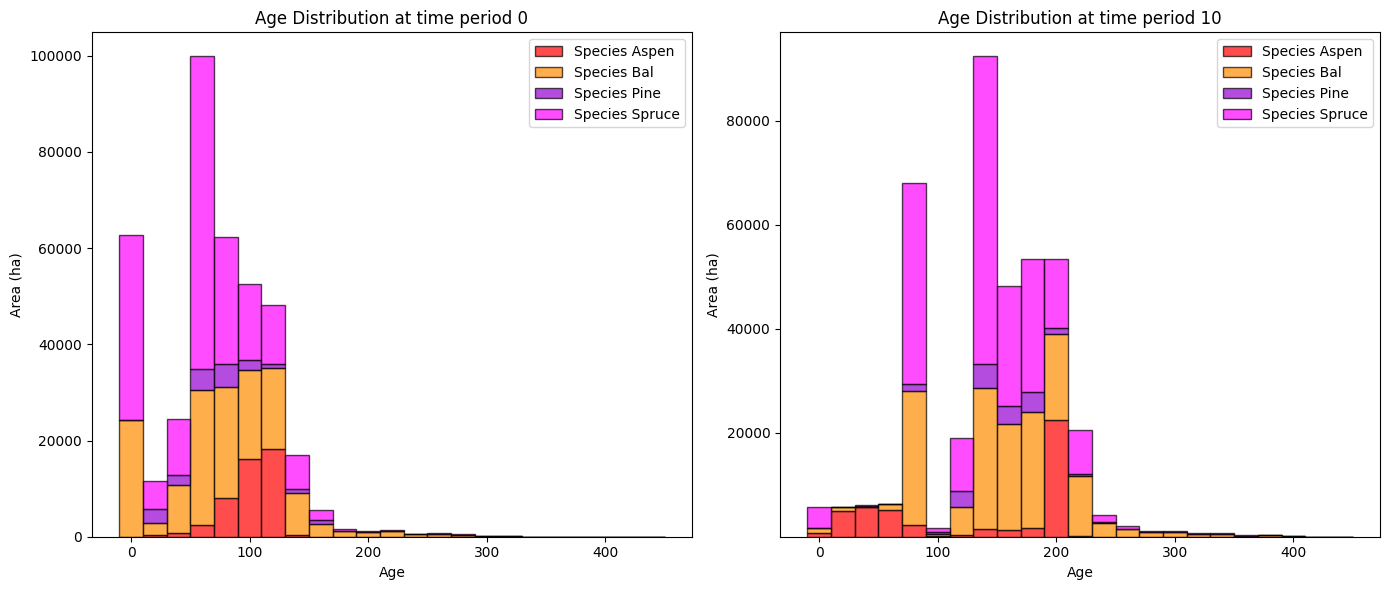

Plot saved to ./outputs/fig/redchris/redchris_min_em_redchrs_AAC_40%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  26043.320518  25098.006830
Pine     602.782616   7854.441464   7251.658847
Bal     4315.588546  49910.884666  45595.296120
Spruce  1072.814408  37281.676763  36208.862356

Old growth has **increased** by 114153.82 hectares from time period 0 to time period 10.


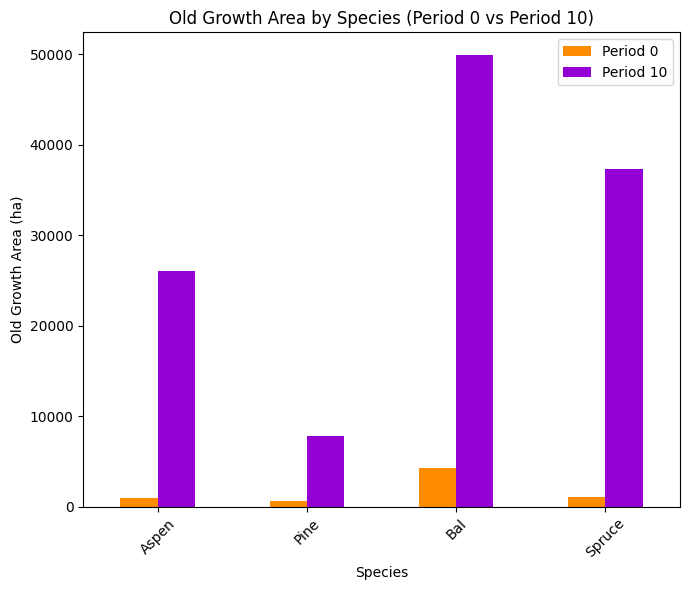

Clustered column plot saved to ./outputs/fig/redchris/redchris_min_em_redchrs_AAC_40%_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.7685

Diversity has **decreased** by 11.64% from time 0 to time 10.


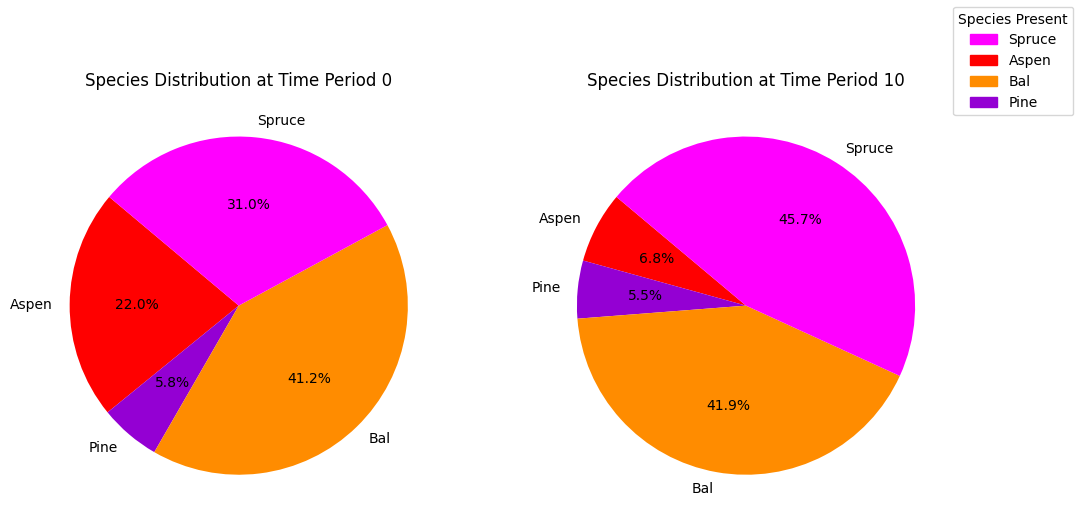

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_em_redchrs_AAC_40%_species_pie.pdf
running business as usual scenario for the Red Chris mining site,
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0x50c64669
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [2e-02, 1e+07]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 2005 columns
Presolve time: 0.14s
Presolved: 1699 rows, 32528 columns, 422291 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time:

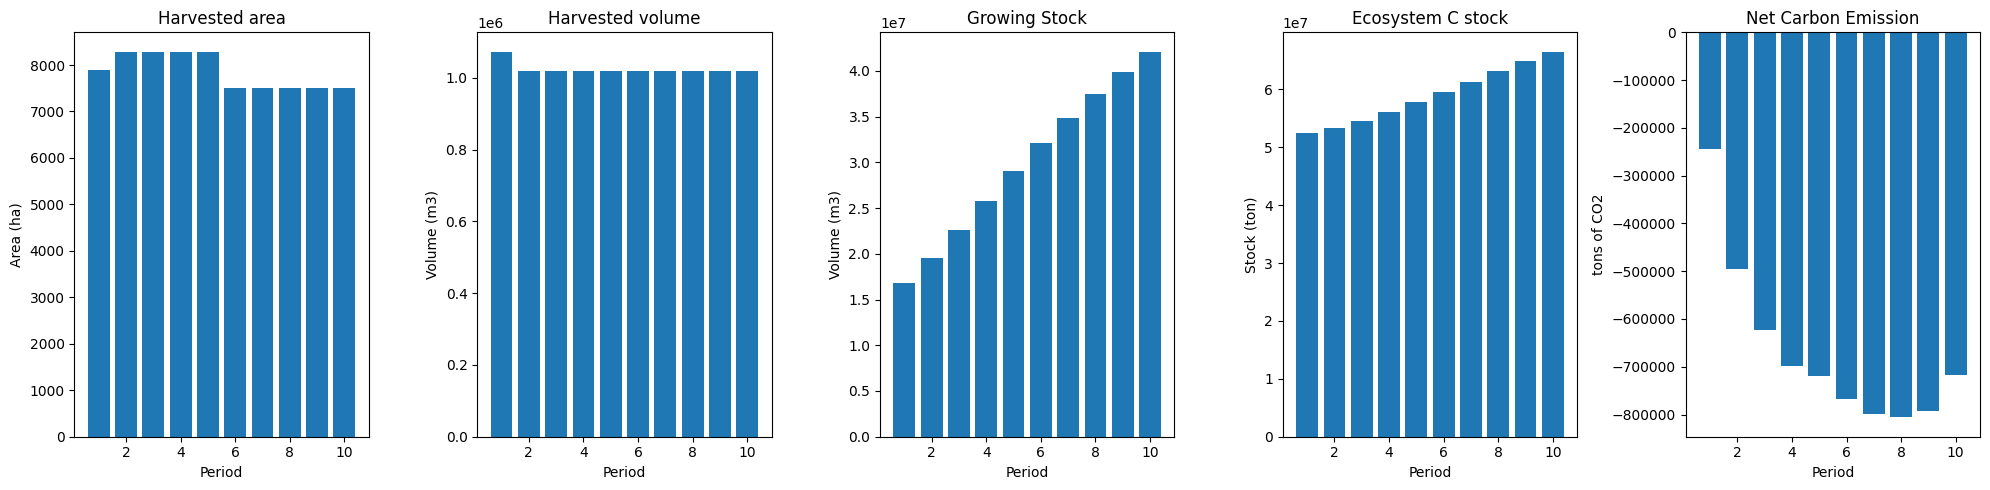

Plot saved to ./outputs/fig/redchris/redchris_min_em_bau_redchrs_scheduling_minemission.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  10831
The economic indicator (the provincial government revenues) is:  369393
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


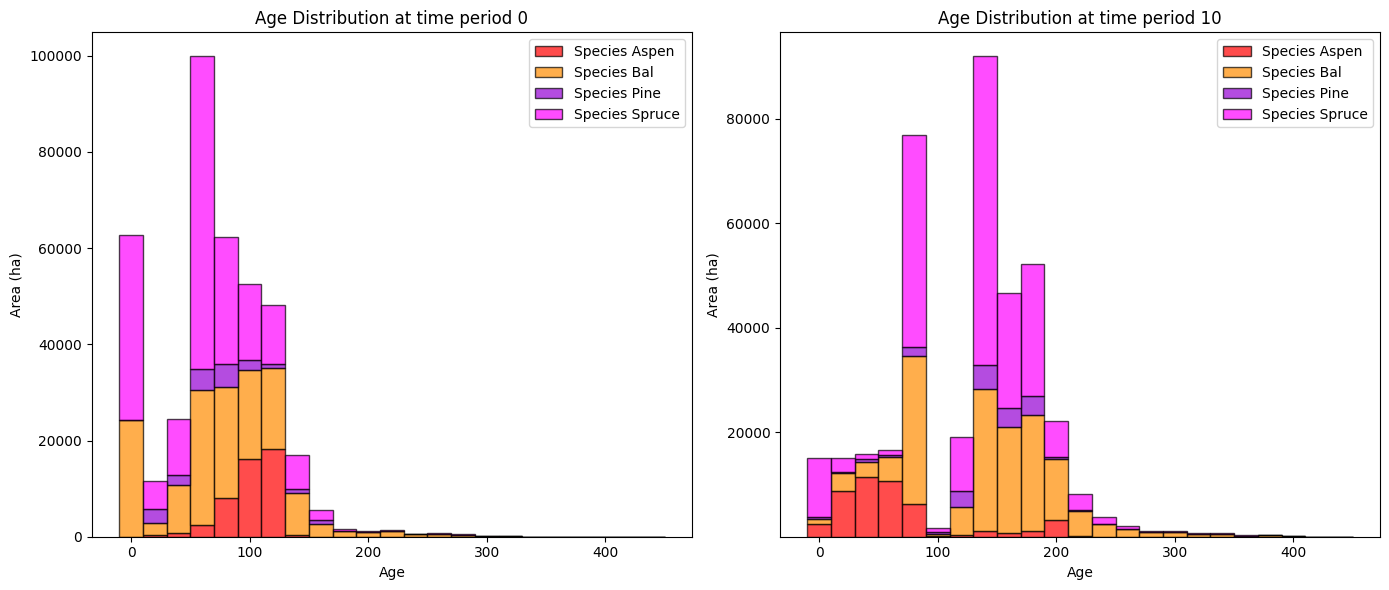

Plot saved to ./outputs/fig/redchris/redchris_min_em_bau_redchrs_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688   5435.179883   4489.866195
Pine     602.782616   6472.028996   5869.246380
Bal     4315.588546  38717.863313  34402.274766
Spruce  1072.814408  26003.989976  24931.175569

Old growth has **increased** by 69692.56 hectares from time period 0 to time period 10.


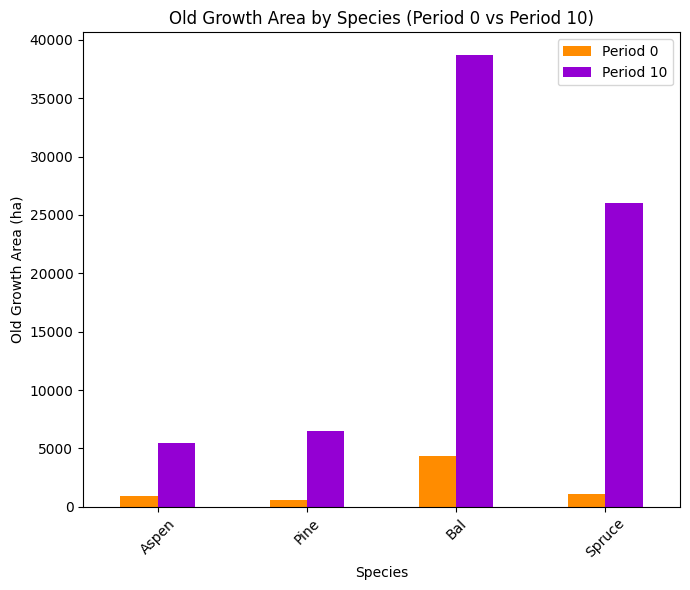

Clustered column plot saved to ./outputs/fig/redchris/redchris_min_em_bau_redchrs_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.7207

Diversity has **decreased** by 16.41% from time 0 to time 10.


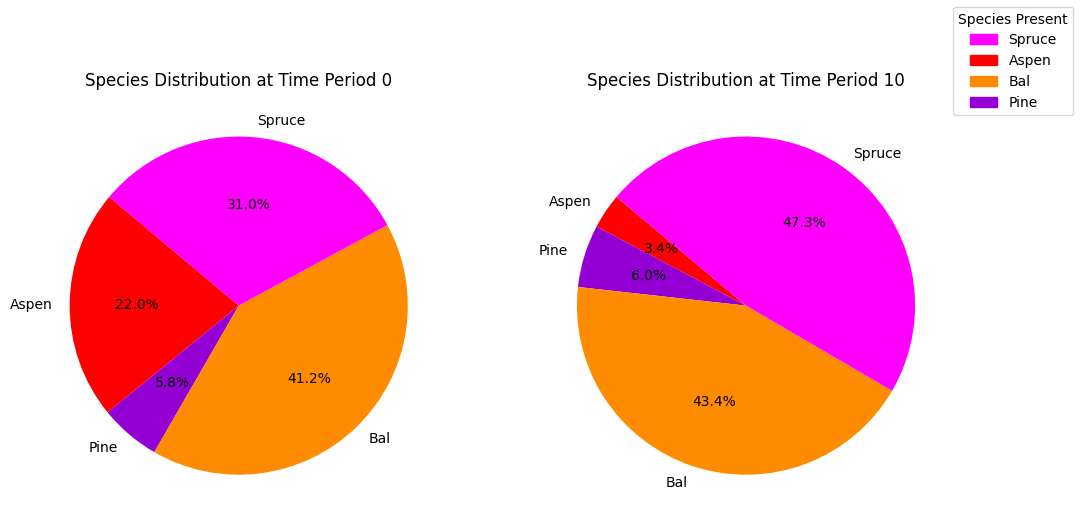

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_em_bau_redchrs_species_pie.pdf


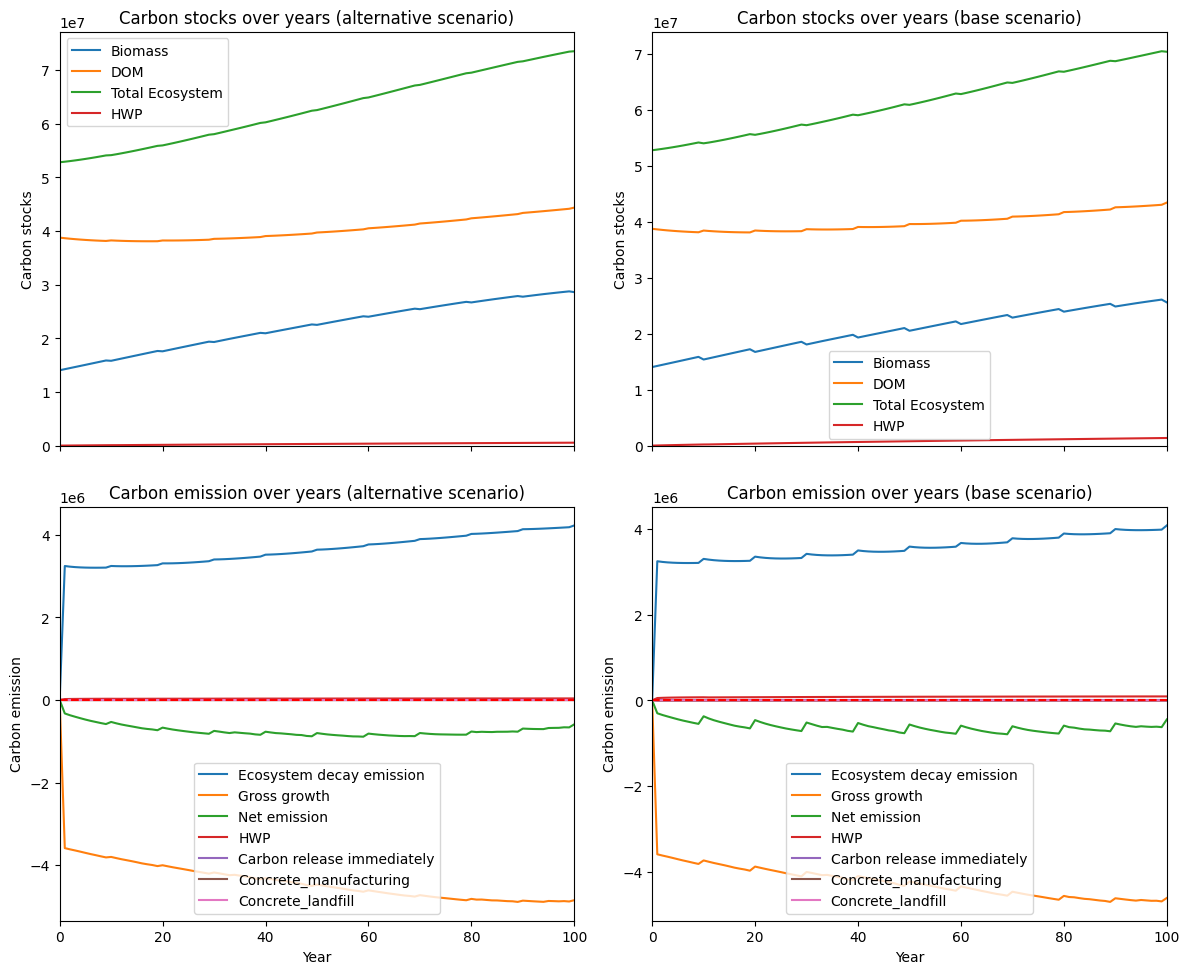

---------------------------------------------------------------------------------------
Net emission difference -12695294.7755258
Net emission base scenario -62345424.357902035
Net emission alternative scenario -75040719.13342783
dollar_per_ton is:  0.787693407425101
Comparison of Old Growth Areas (Alternative - Base)
          0            10    Difference
Aspen   0.0  20608.140635  20608.140635
Pine    0.0   1382.412467   1382.412467
Bal     0.0  11193.021353  11193.021353
Spruce  0.0  11277.686787  11277.686787

Overall, the old growth area has **increased** by 44461.26 hectares in the alternative scenario compared to the base scenario.


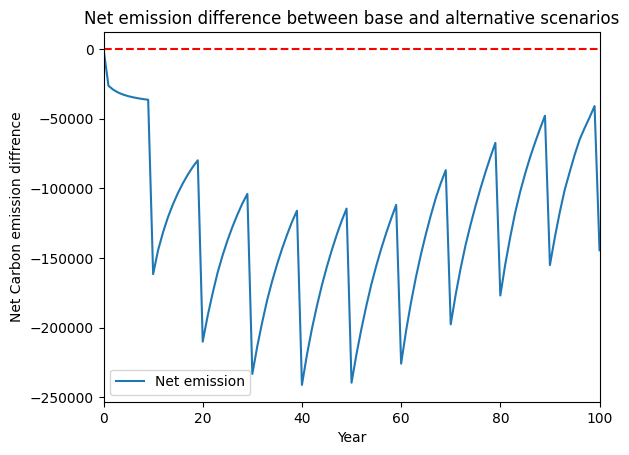

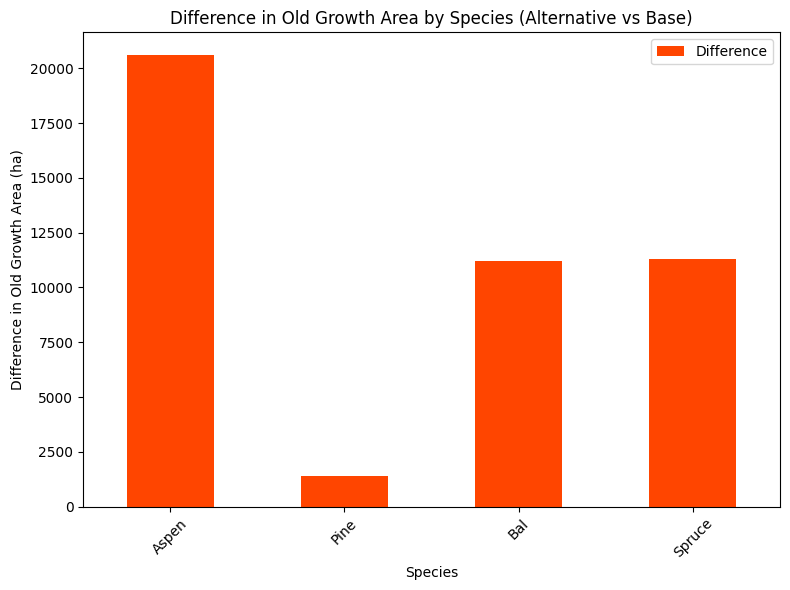

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/redchris/redchris_min_em_kpi_age_difference.pdf


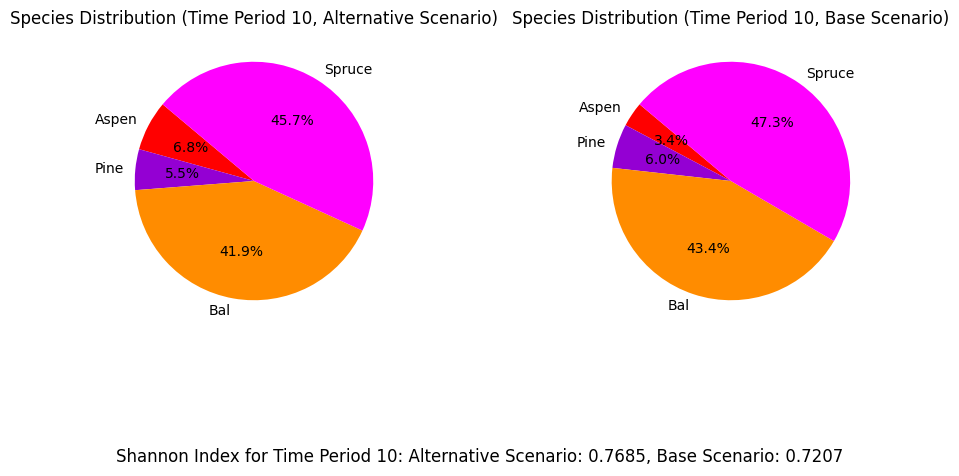

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_em_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for redchris_min_em_redchrs_AAC_30%...
running the scenario for the Red Chris mining site (30%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0x0ee3463c
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [2e-02, 1e+07]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 2005 columns
Presolve time: 0.14s
Presolved: 1699 rows, 32529 column

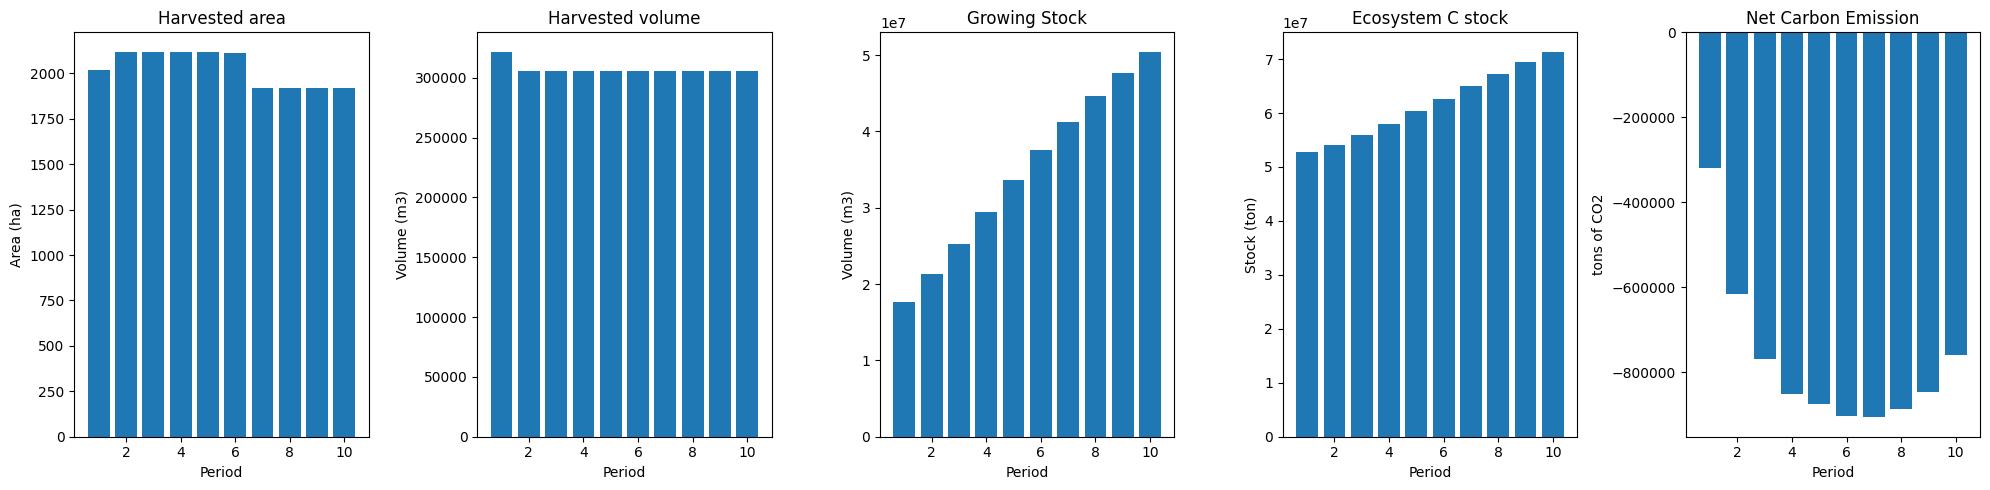

Plot saved to ./outputs/fig/redchris/redchris_min_em_redchrs_AAC_30%_scheduling_minemission.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  3249
The economic indicator (the provincial government revenues) is:  110818
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


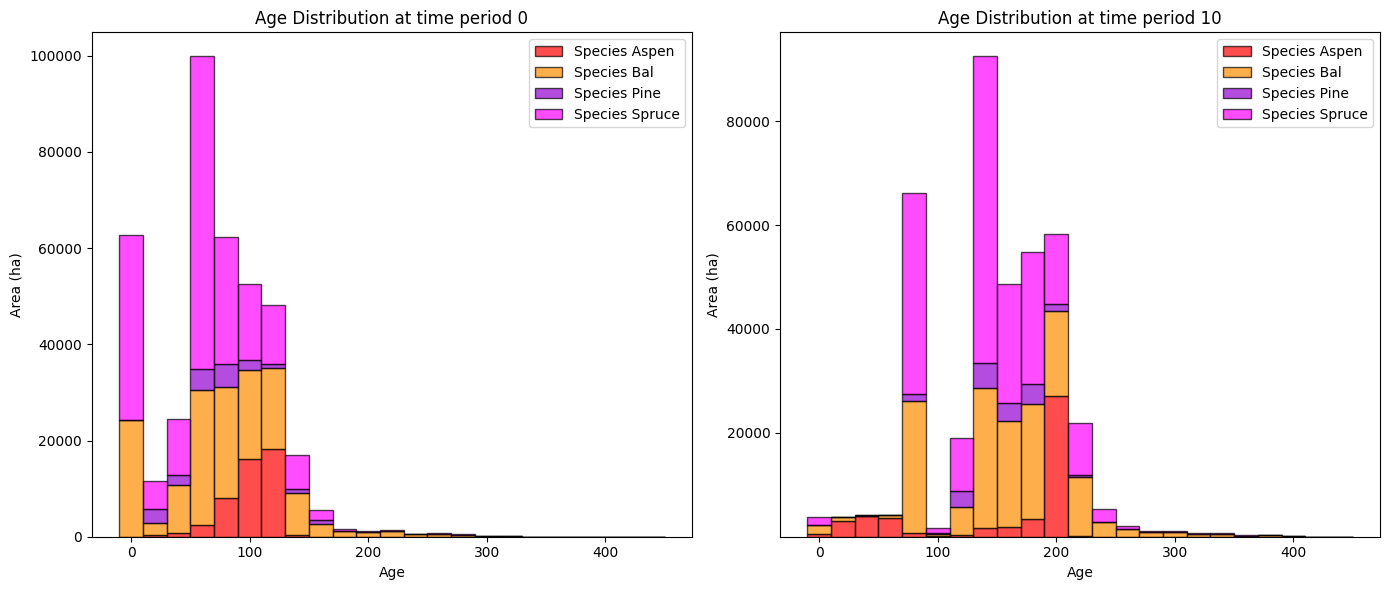

Plot saved to ./outputs/fig/redchris/redchris_min_em_redchrs_AAC_30%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  32950.385880  32005.072192
Pine     602.782616   7868.361734   7265.579118
Bal     4315.588546  49838.817313  45523.228767
Spruce  1072.814408  39947.824757  38875.010349

Old growth has **increased** by 123668.89 hectares from time period 0 to time period 10.


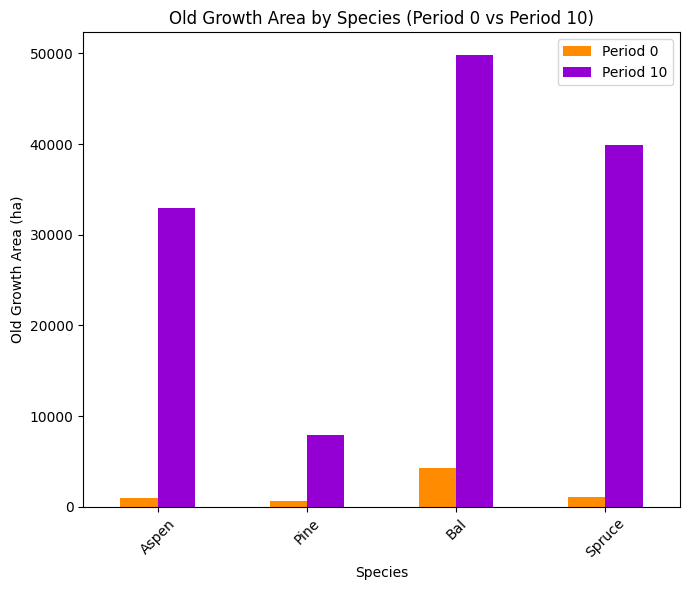

Clustered column plot saved to ./outputs/fig/redchris/redchris_min_em_redchrs_AAC_30%_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.7828

Diversity has **decreased** by 10.20% from time 0 to time 10.


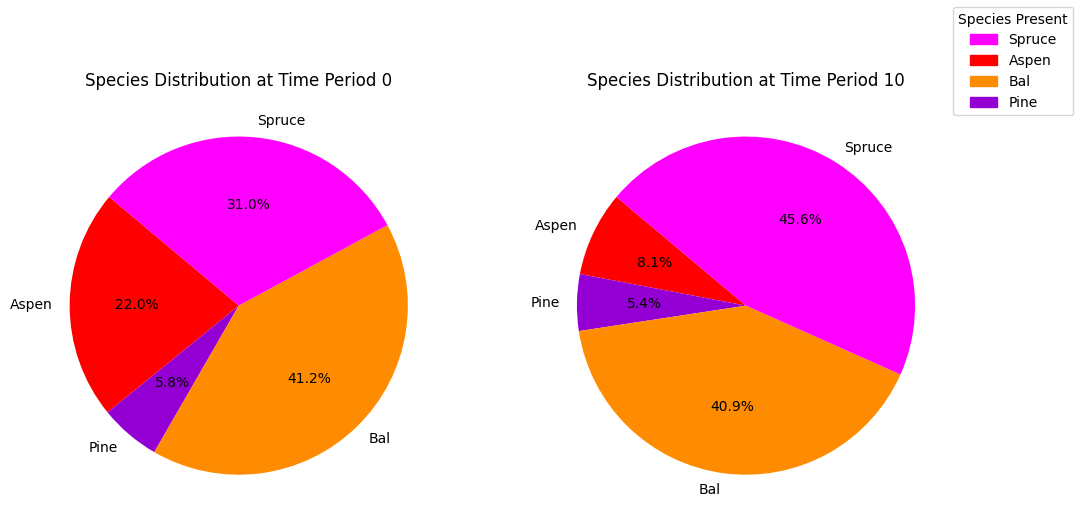

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_em_redchrs_AAC_30%_species_pie.pdf
running business as usual scenario for the Red Chris mining site,
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0x50c64669
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [2e-02, 1e+07]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 2005 columns
Presolve time: 0.15s
Presolved: 1699 rows, 32528 columns, 422291 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time:

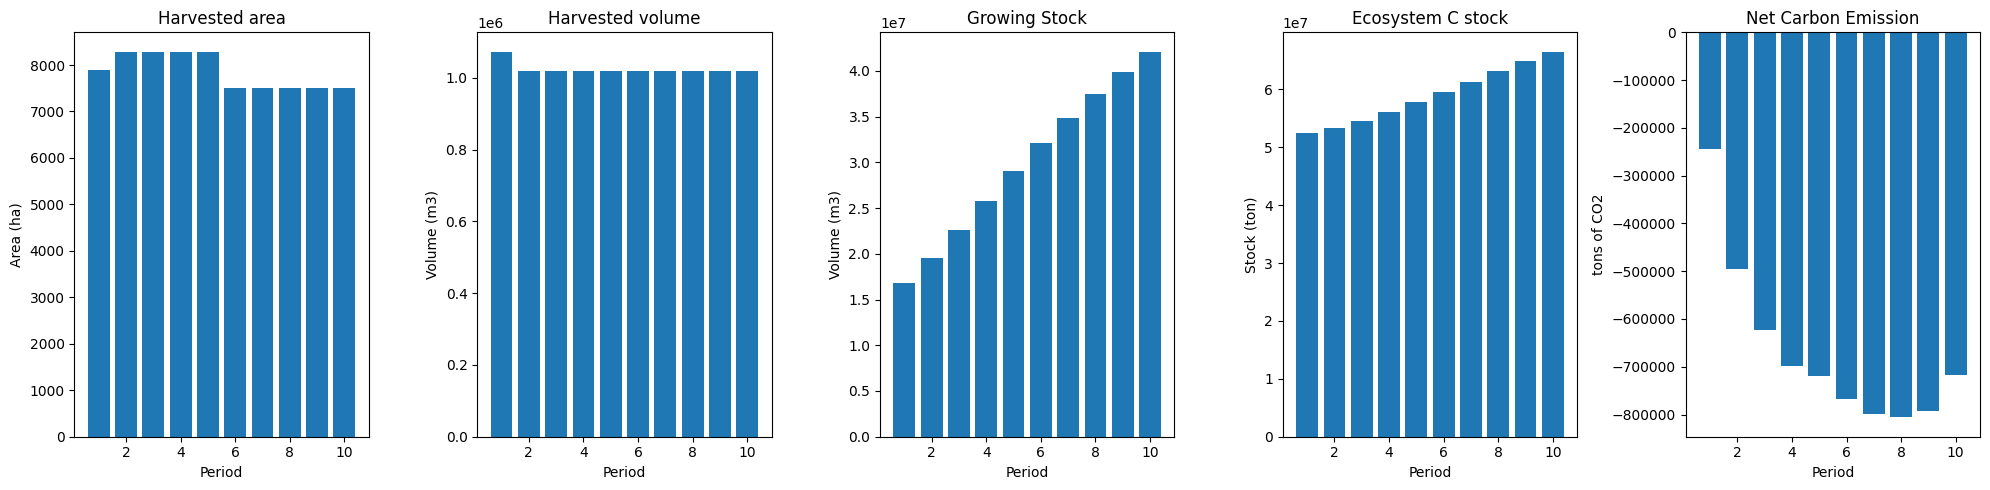

Plot saved to ./outputs/fig/redchris/redchris_min_em_bau_redchrs_scheduling_minemission.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  10831
The economic indicator (the provincial government revenues) is:  369393
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


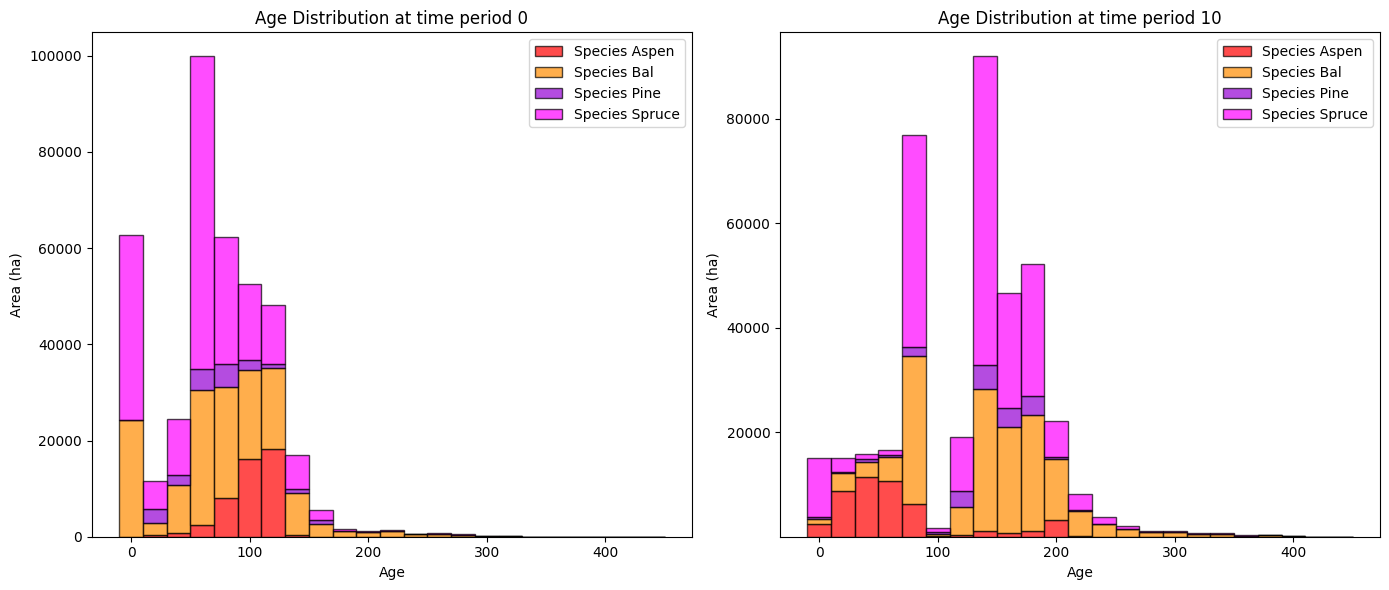

Plot saved to ./outputs/fig/redchris/redchris_min_em_bau_redchrs_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688   5435.179883   4489.866195
Pine     602.782616   6472.028996   5869.246380
Bal     4315.588546  38717.863313  34402.274766
Spruce  1072.814408  26003.989976  24931.175569

Old growth has **increased** by 69692.56 hectares from time period 0 to time period 10.


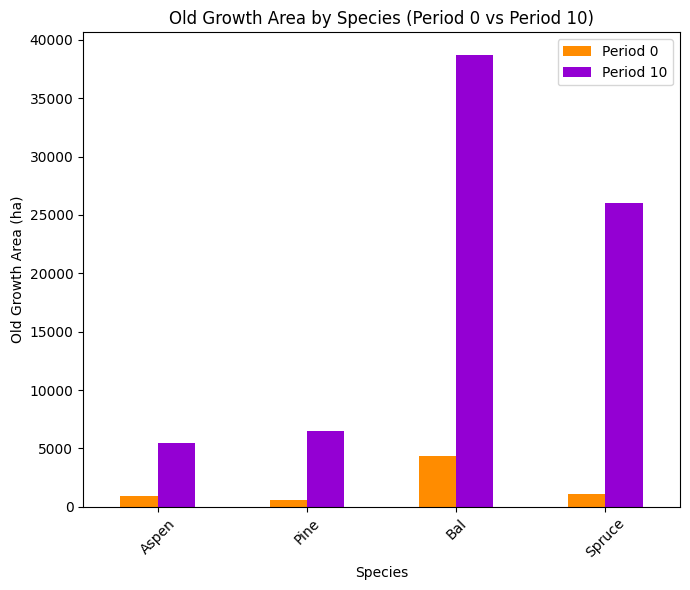

Clustered column plot saved to ./outputs/fig/redchris/redchris_min_em_bau_redchrs_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.7207

Diversity has **decreased** by 16.41% from time 0 to time 10.


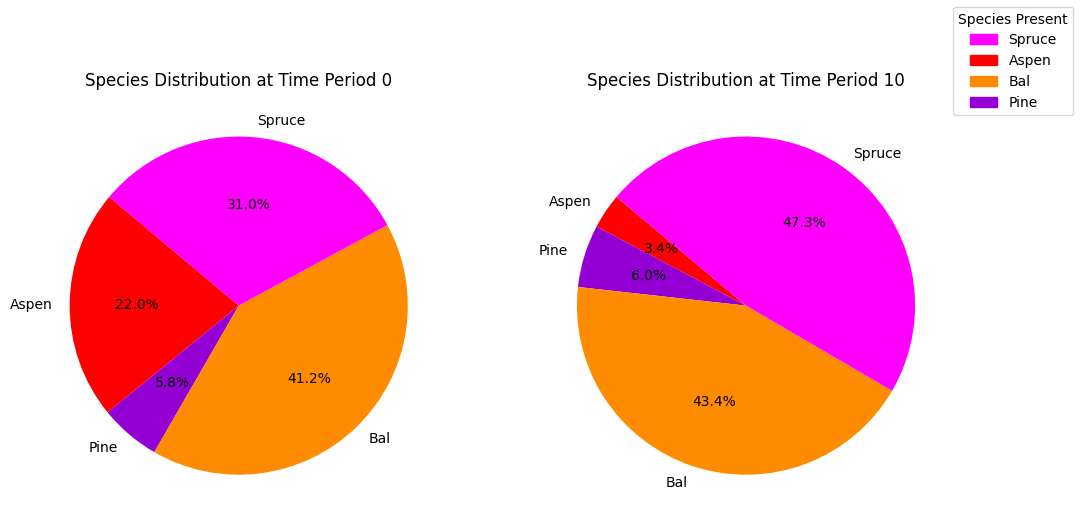

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_em_bau_redchrs_species_pie.pdf


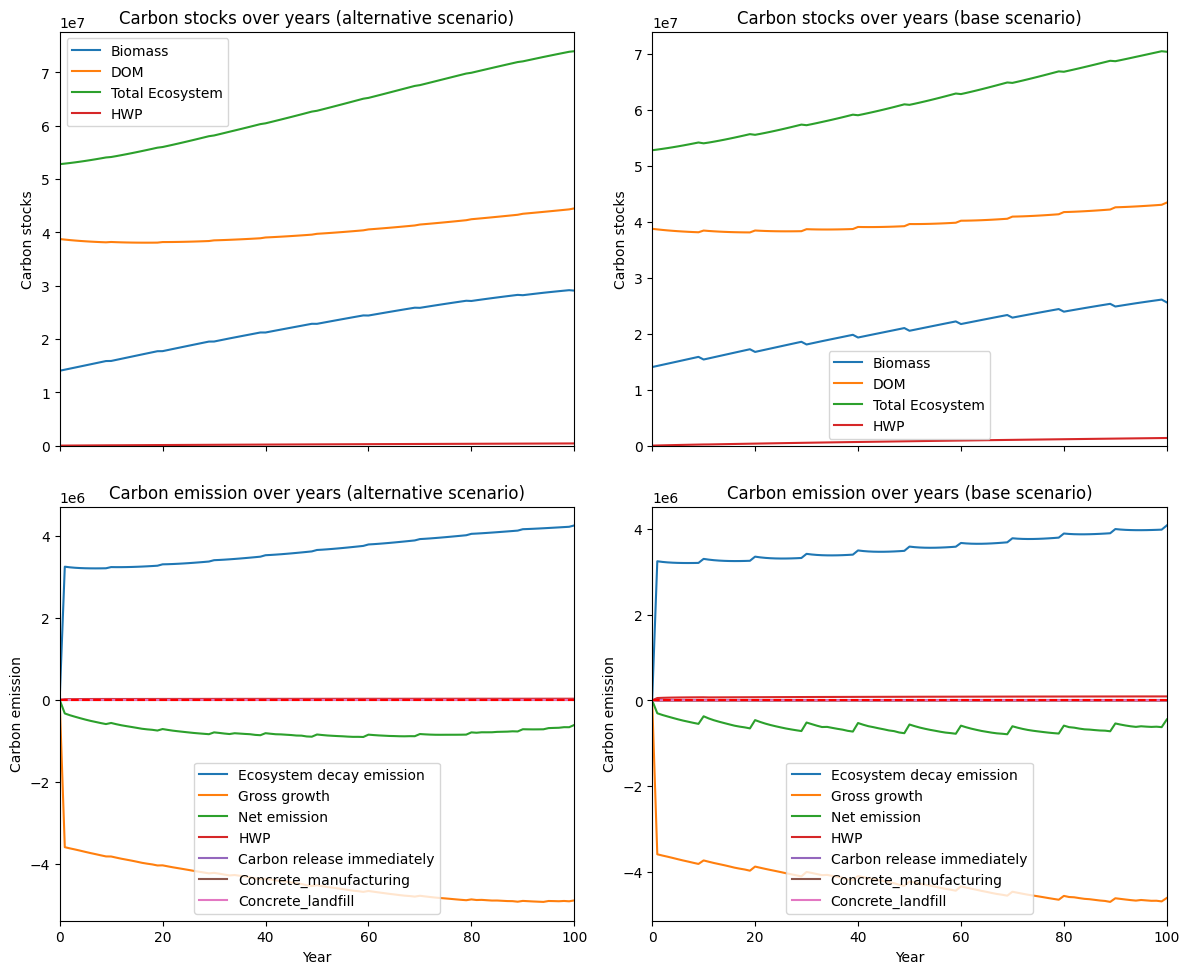

---------------------------------------------------------------------------------------
Net emission difference -14660460.455109943
Net emission base scenario -62345424.357902035
Net emission alternative scenario -77005884.81301197
dollar_per_ton is:  0.6821068158547826
Comparison of Old Growth Areas (Alternative - Base)
          0            10    Difference
Aspen   0.0  27515.205997  27515.205997
Pine    0.0   1396.332738   1396.332738
Bal     0.0  11120.954001  11120.954001
Spruce  0.0  13943.834780  13943.834780

Overall, the old growth area has **increased** by 53976.33 hectares in the alternative scenario compared to the base scenario.


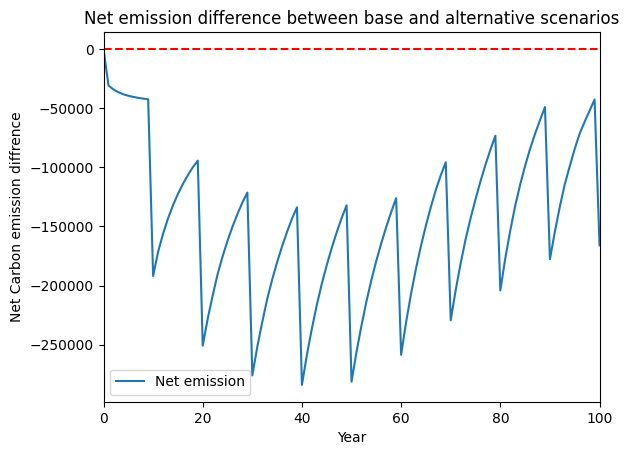

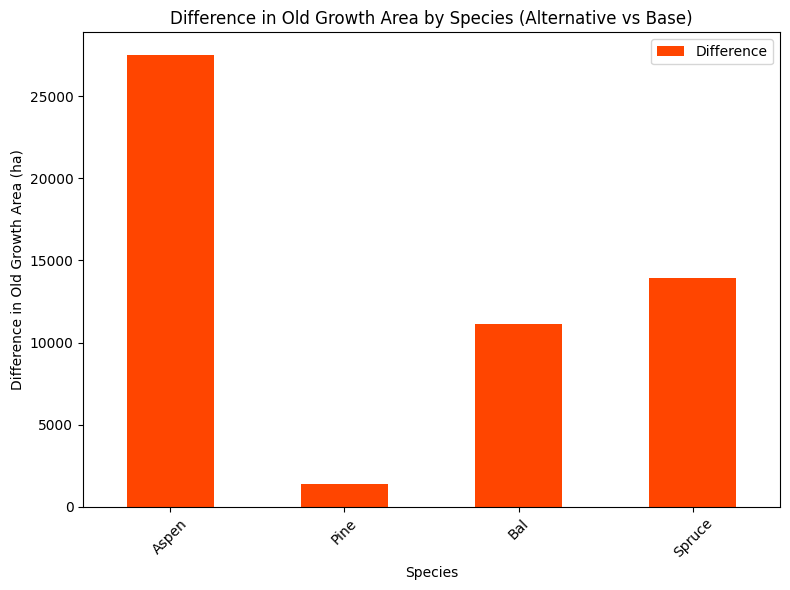

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/redchris/redchris_min_em_kpi_age_difference.pdf


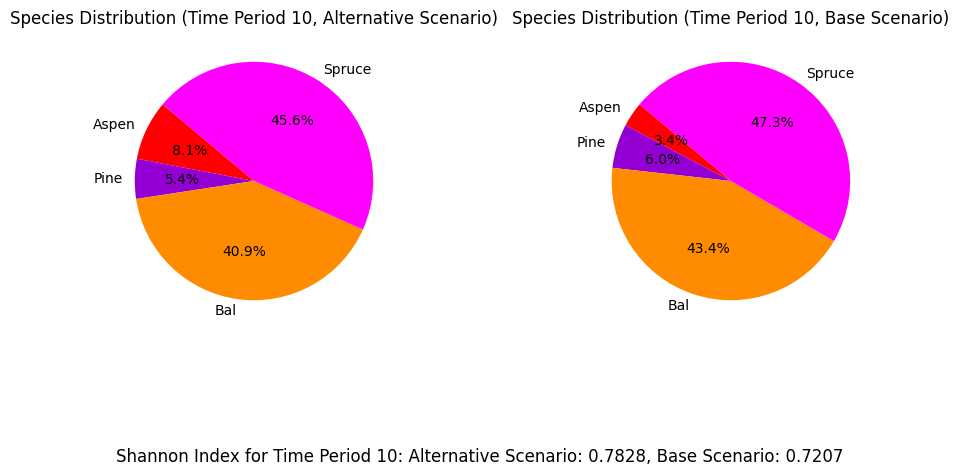

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_em_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for redchris_min_em_redchrs_AAC_20%...
running the scenario for the Red Chris mining site (20%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0x255b42e1
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [2e-02, 1e+07]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 2005 columns
Presolve time: 0.14s
Presolved: 1699 rows, 32529 column

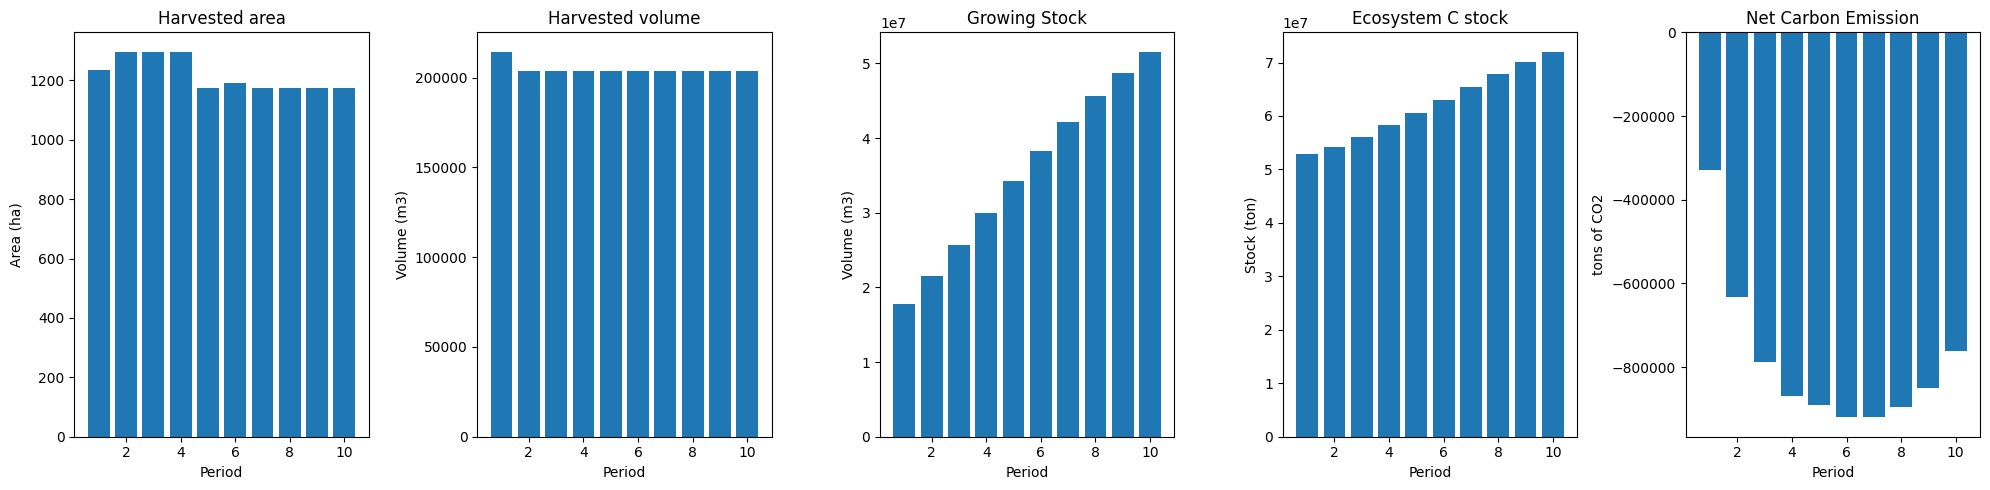

Plot saved to ./outputs/fig/redchris/redchris_min_em_redchrs_AAC_20%_scheduling_minemission.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  2166
The economic indicator (the provincial government revenues) is:  73878
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


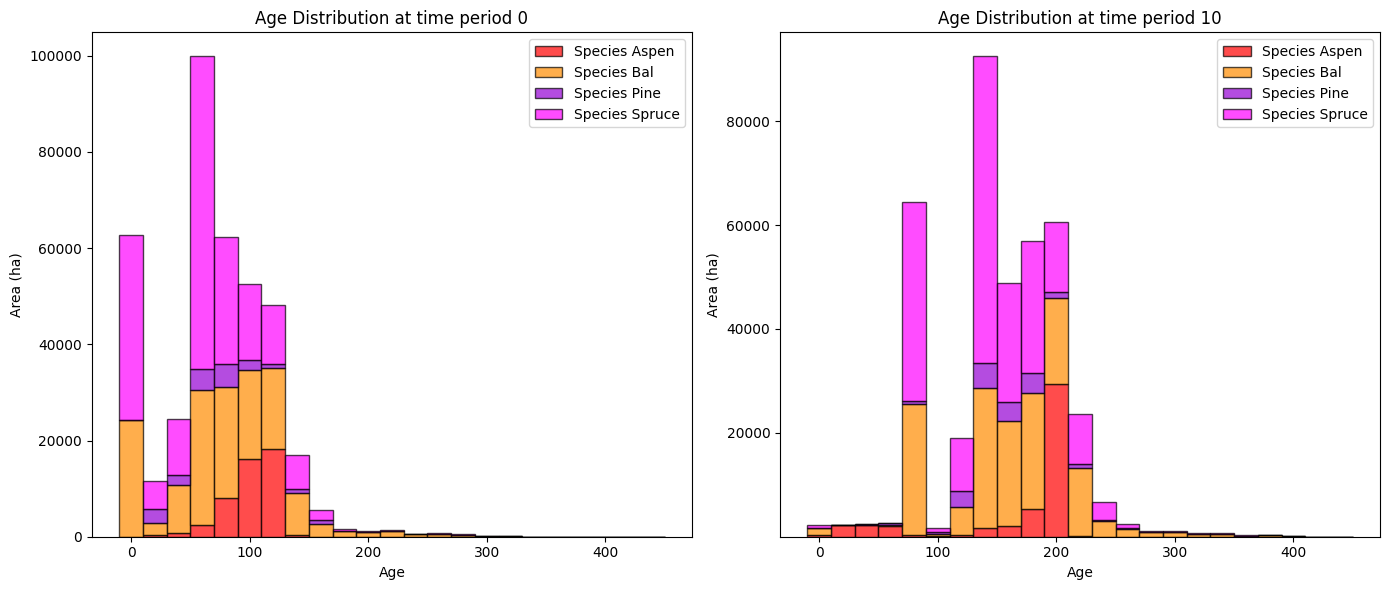

Plot saved to ./outputs/fig/redchris/redchris_min_em_redchrs_AAC_20%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  37443.684088  36498.370400
Pine     602.782616   8356.160274   7753.377658
Bal     4315.588546  51858.427939  47542.839393
Spruce  1072.814408  41020.373482  39947.559074

Old growth has **increased** by 131742.15 hectares from time period 0 to time period 10.


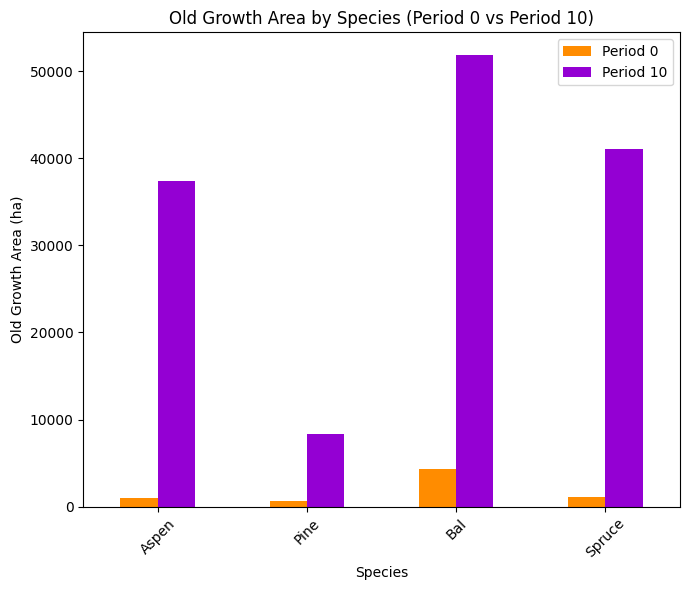

Clustered column plot saved to ./outputs/fig/redchris/redchris_min_em_redchrs_AAC_20%_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.7918

Diversity has **decreased** by 9.30% from time 0 to time 10.


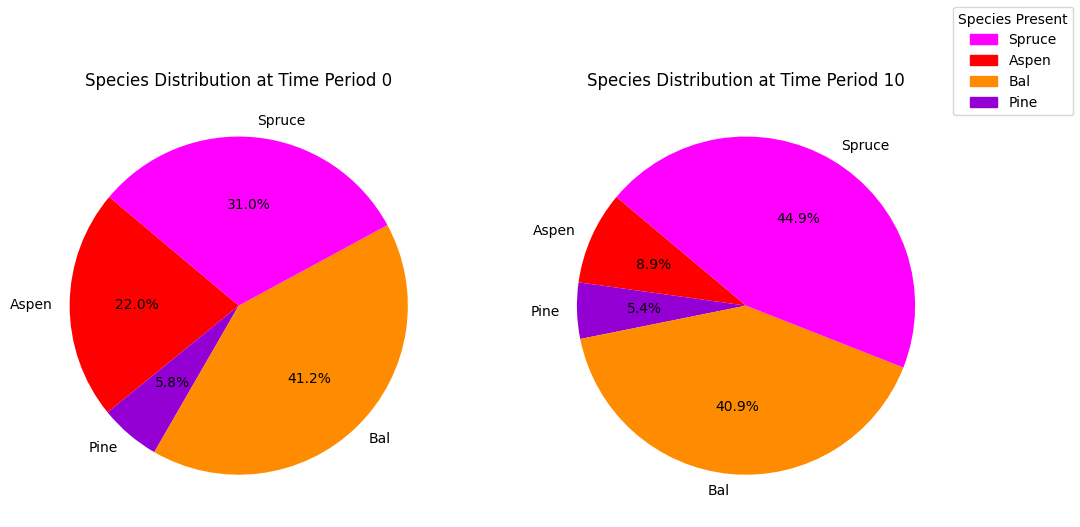

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_em_redchrs_AAC_20%_species_pie.pdf
running business as usual scenario for the Red Chris mining site,
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0x50c64669
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [2e-02, 1e+07]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 2005 columns
Presolve time: 0.19s
Presolved: 1699 rows, 32528 columns, 422291 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time:

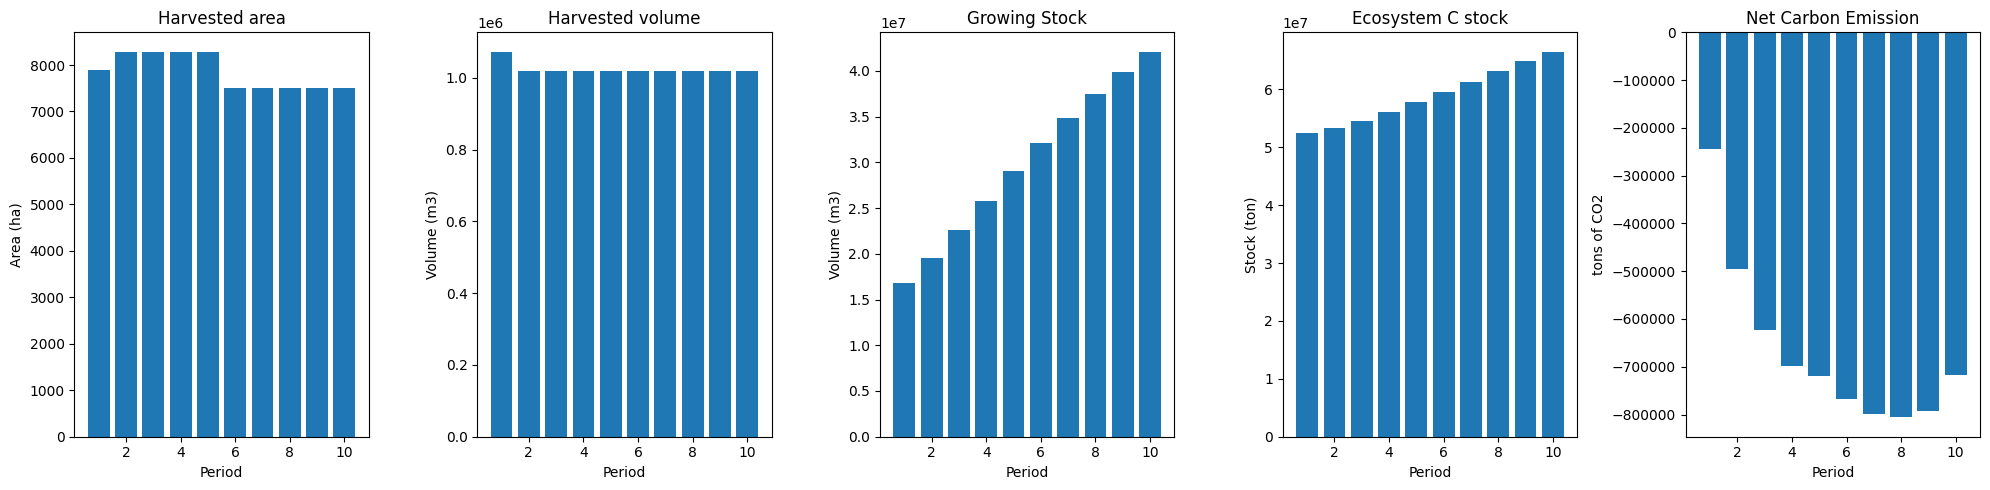

Plot saved to ./outputs/fig/redchris/redchris_min_em_bau_redchrs_scheduling_minemission.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  10831
The economic indicator (the provincial government revenues) is:  369393
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


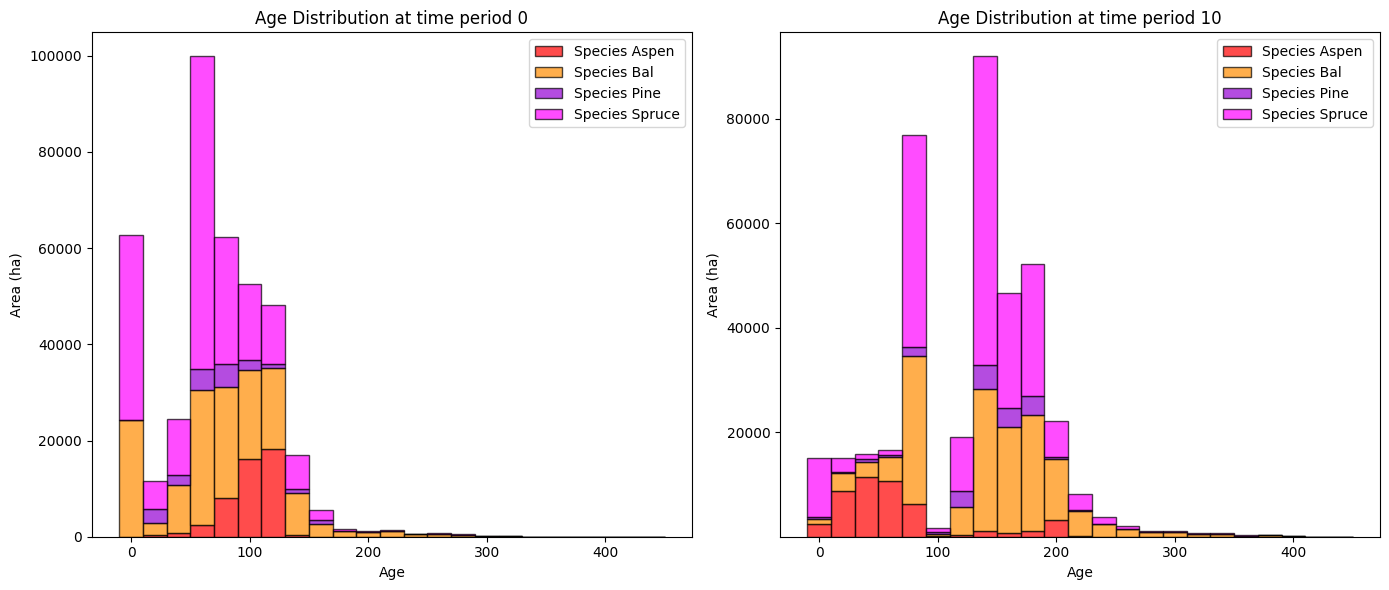

Plot saved to ./outputs/fig/redchris/redchris_min_em_bau_redchrs_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688   5435.179883   4489.866195
Pine     602.782616   6472.028996   5869.246380
Bal     4315.588546  38717.863313  34402.274766
Spruce  1072.814408  26003.989976  24931.175569

Old growth has **increased** by 69692.56 hectares from time period 0 to time period 10.


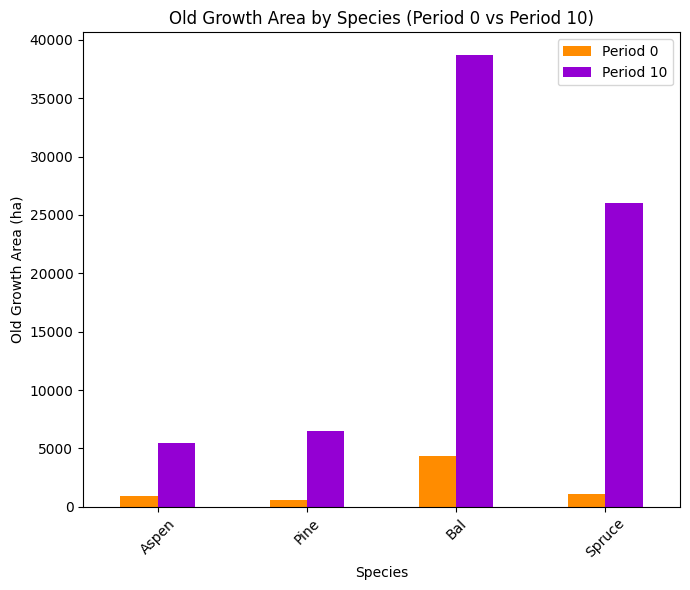

Clustered column plot saved to ./outputs/fig/redchris/redchris_min_em_bau_redchrs_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.7207

Diversity has **decreased** by 16.41% from time 0 to time 10.


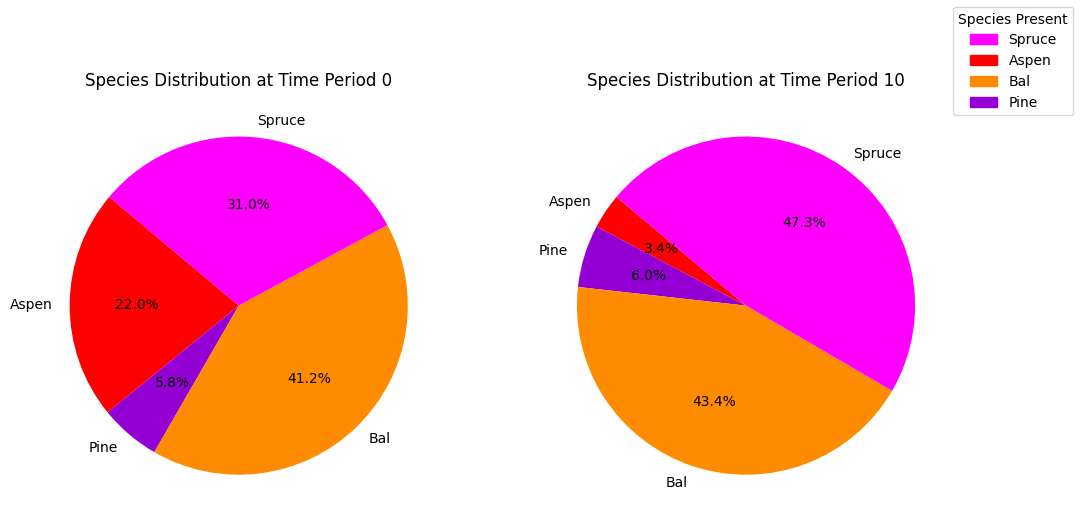

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_em_bau_redchrs_species_pie.pdf


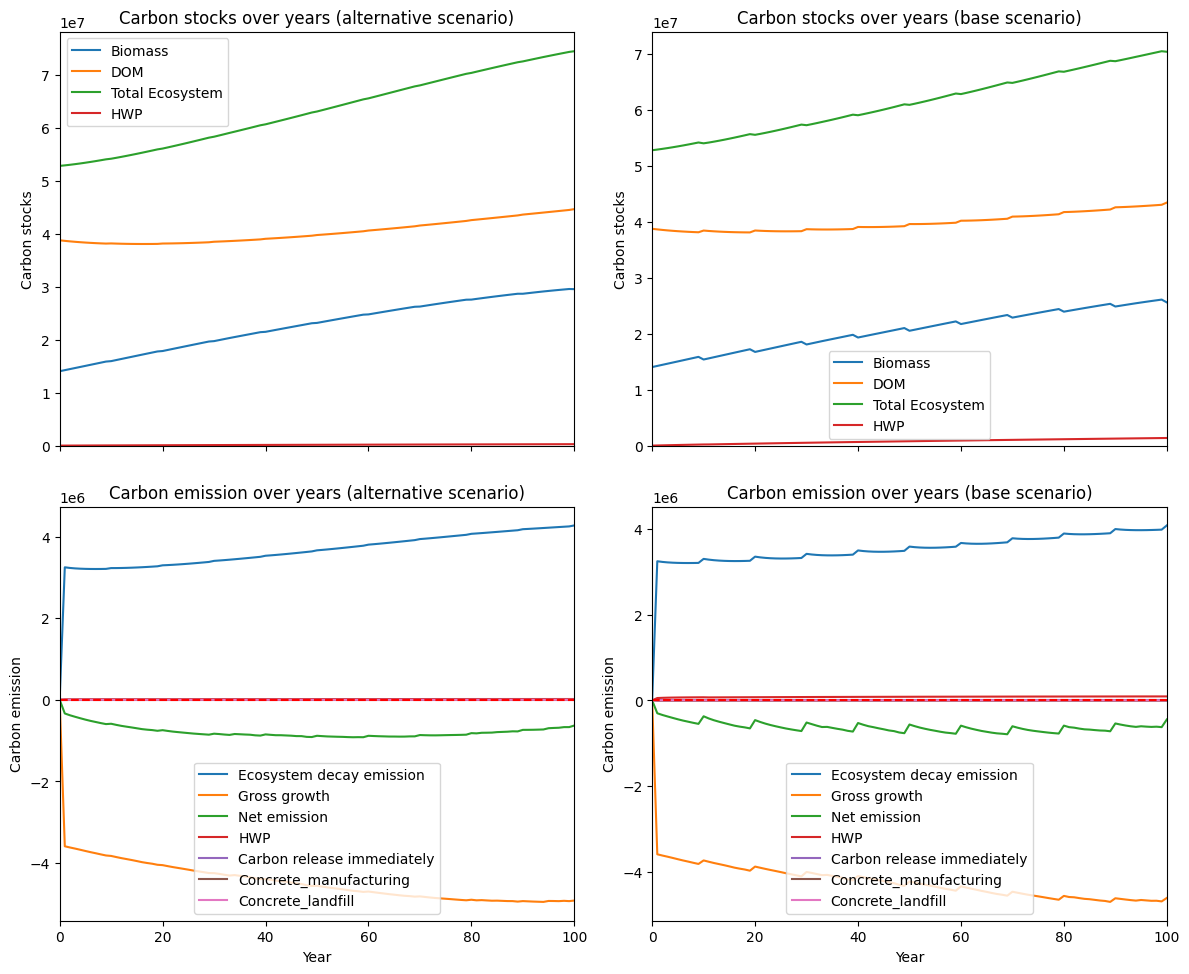

---------------------------------------------------------------------------------------
Net emission difference -16550869.574103286
Net emission base scenario -62345424.357902035
Net emission alternative scenario -78896293.9320053
dollar_per_ton is:  0.6041978613405751
Comparison of Old Growth Areas (Alternative - Base)
          0            10    Difference
Aspen   0.0  32008.504205  32008.504205
Pine    0.0   1884.131278   1884.131278
Bal     0.0  13140.564627  13140.564627
Spruce  0.0  15016.383505  15016.383505

Overall, the old growth area has **increased** by 62049.58 hectares in the alternative scenario compared to the base scenario.


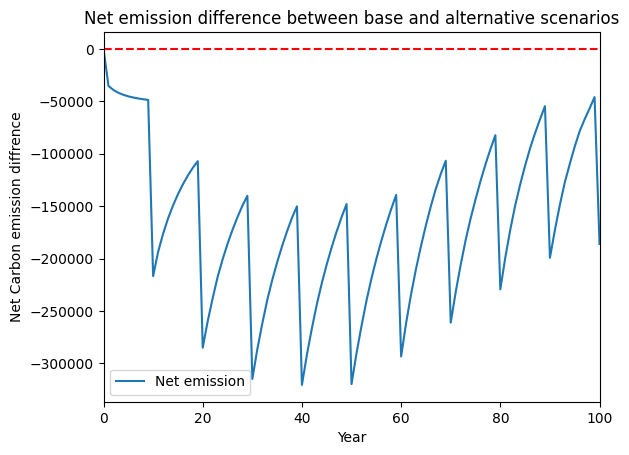

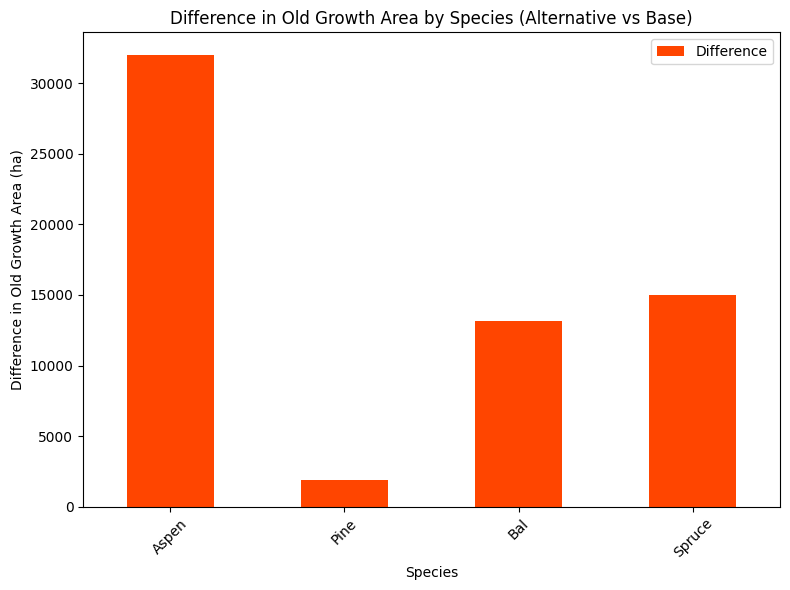

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/redchris/redchris_min_em_kpi_age_difference.pdf


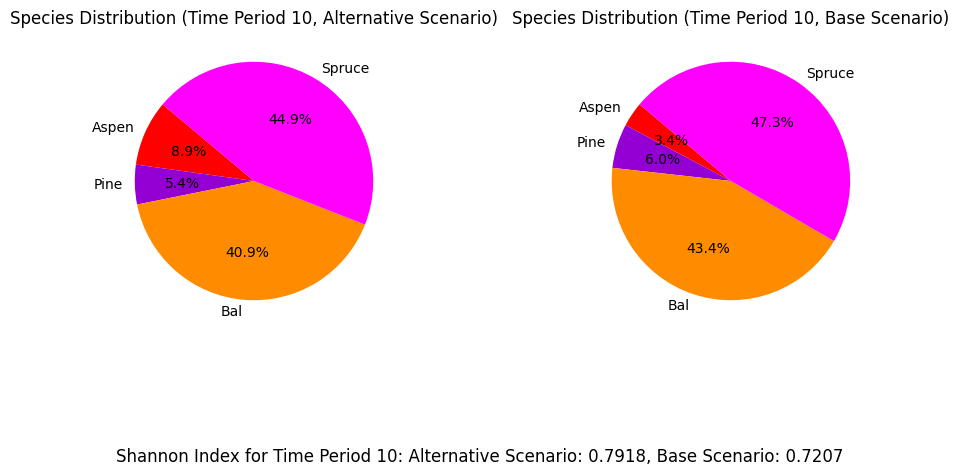

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_em_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for redchris_min_em_redchrs_AAC_10%...
running the scenario for the Red Chris mining site (10%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0x5ef5ea55
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [2e-02, 1e+07]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 2005 columns
Presolve time: 0.12s
Presolved: 1699 rows, 32529 column

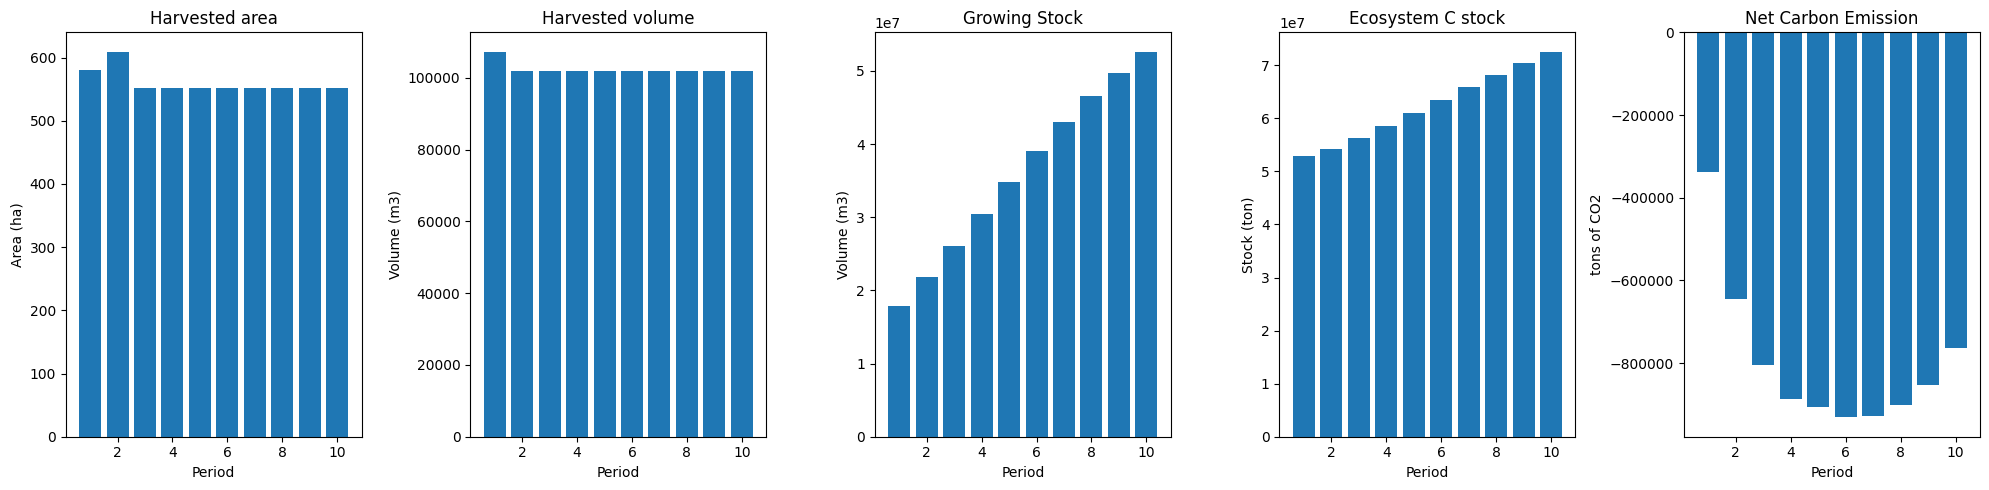

Plot saved to ./outputs/fig/redchris/redchris_min_em_redchrs_AAC_10%_scheduling_minemission.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  1083
The economic indicator (the provincial government revenues) is:  36939
------------------------------------------------


In [ ]:
Start = time.time()
scenario_names = scenario_options.get(case_study, [])
for scenario_name in scenario_names:
    print(f"Running for {case_study}_{obj_mode}_{scenario_name}...")
    results_scenarios(fm, 
                      clt_percentage, 
                      credibility, 
                      budget_input, 
                      n_steps, 
                      max_harvest, 
                      scenario_name, 
                      displacement_effect, 
                      hwp_pool_effect_value, 
                      release_immediately_value, 
                      case_study, 
                      obj_mode,                   
                      pickle_output_base=False, 
                      pickle_output_alter=False)
print('It took', round((time.time() - Start) / 60, 1), "minutes to run all scenarios.")

Running for redchris_min_em_redchrs_AAC_10%...
running the scenario for the Red Chris mining site (10%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0x5ef5ea55
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [2e-02, 1e+07]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 2005 columns
Presolve time: 0.13s
Presolved: 1699 rows, 32529 columns, 422292 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 6.066e+04
 Factor NZ  : 8.155e+0

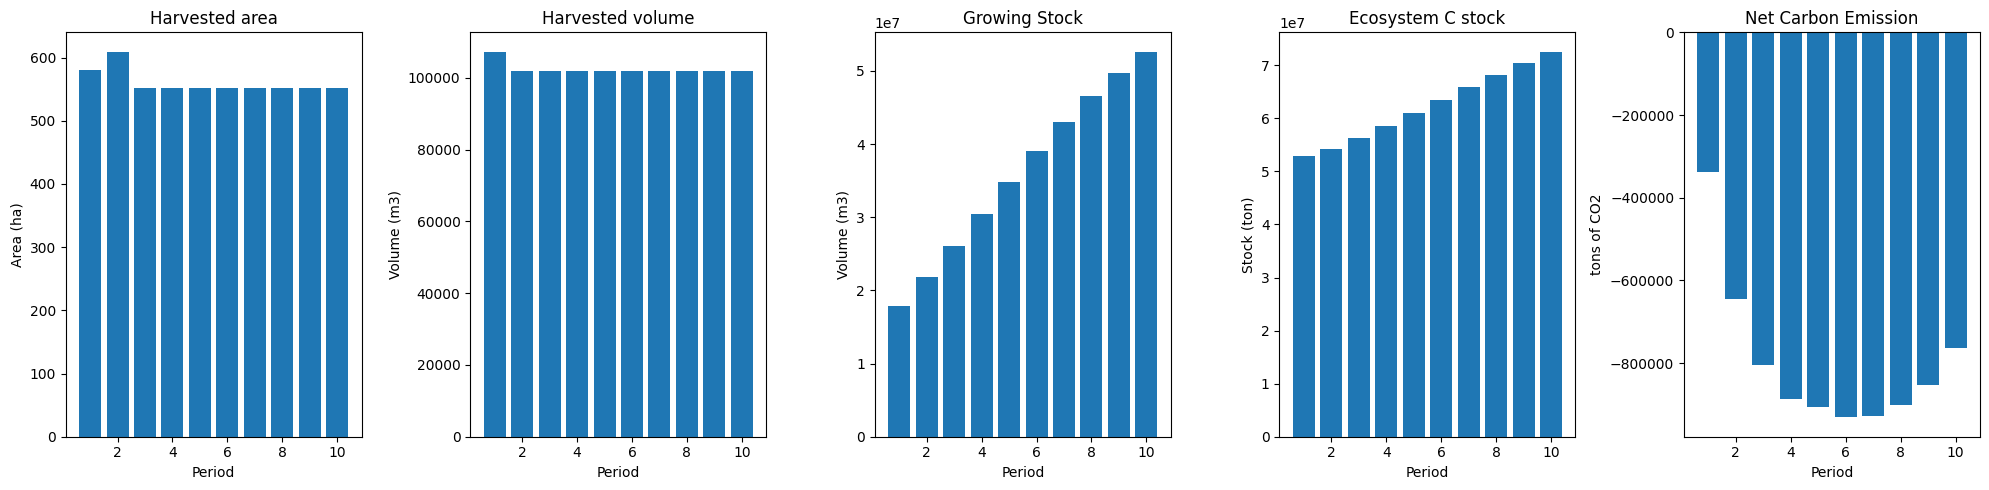

Plot saved to ./outputs/fig/redchris/redchris_min_em_redchrs_AAC_10%_scheduling_minemission.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  1083
The economic indicator (the provincial government revenues) is:  36939
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


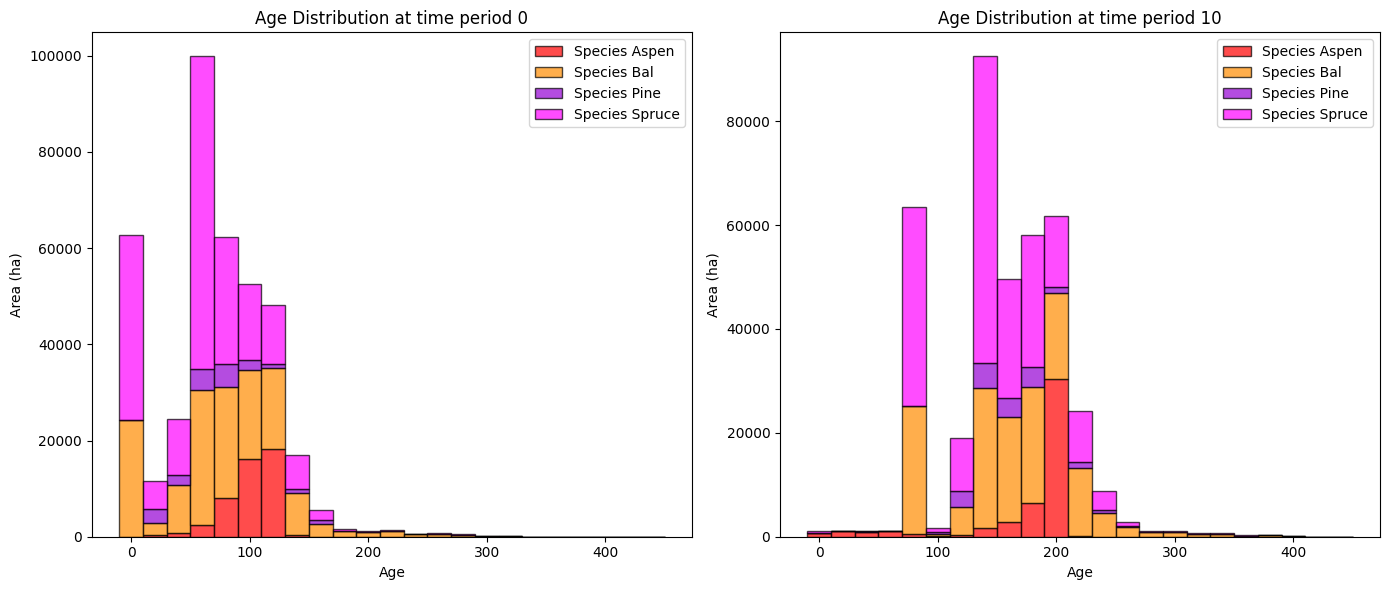

Plot saved to ./outputs/fig/redchris/redchris_min_em_redchrs_AAC_10%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688  40480.213702  39534.900014
Pine     602.782616   9089.243919   8486.461303
Bal     4315.588546  53838.172872  49522.584326
Spruce  1072.814408  41621.243807  40548.429399

Old growth has **increased** by 138092.38 hectares from time period 0 to time period 10.


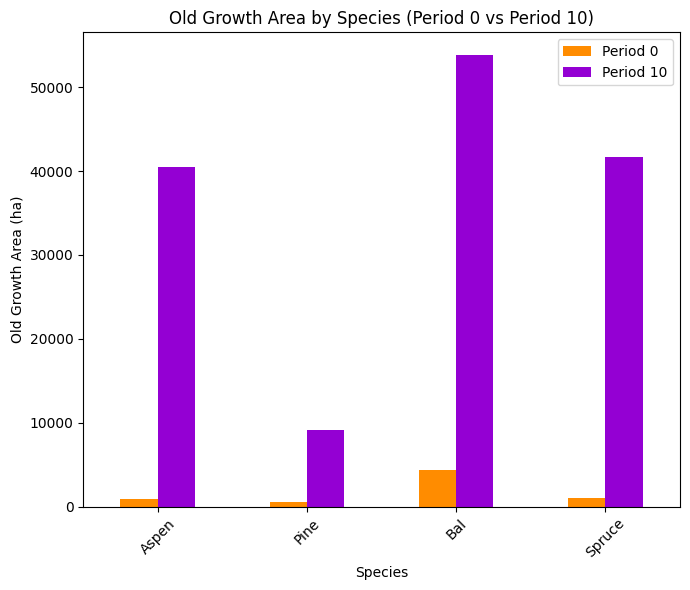

Clustered column plot saved to ./outputs/fig/redchris/redchris_min_em_redchrs_AAC_10%_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.8011

Diversity has **decreased** by 8.38% from time 0 to time 10.


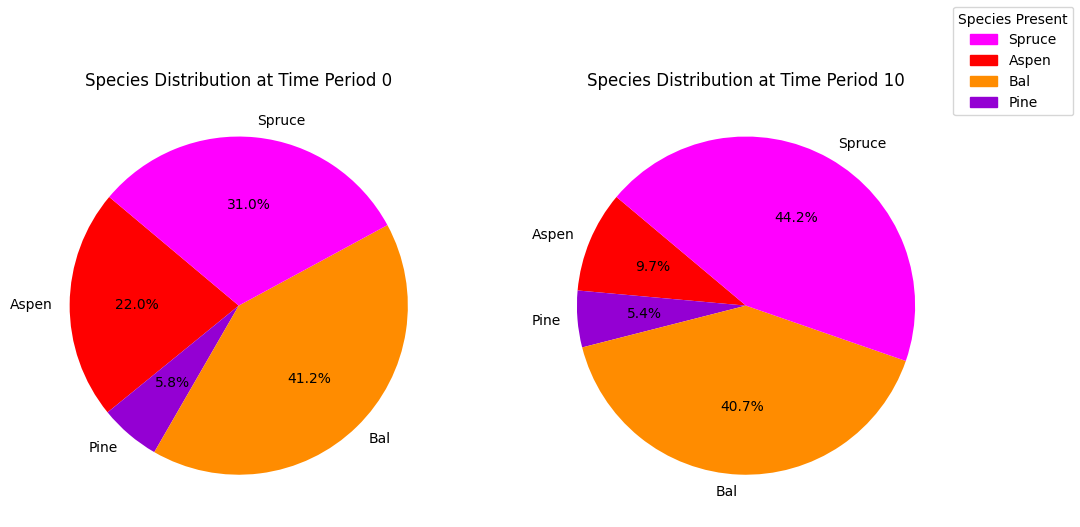

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_em_redchrs_AAC_10%_species_pie.pdf
running business as usual scenario for the Red Chris mining site,
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3711 rows, 34533 columns and 483527 nonzeros
Model fingerprint: 0x50c64669
Coefficient statistics:
  Matrix range     [1e-02, 4e+06]
  Objective range  [2e-02, 1e+07]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2012 rows and 2005 columns
Presolve time: 0.14s
Presolved: 1699 rows, 32528 columns, 422291 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time:

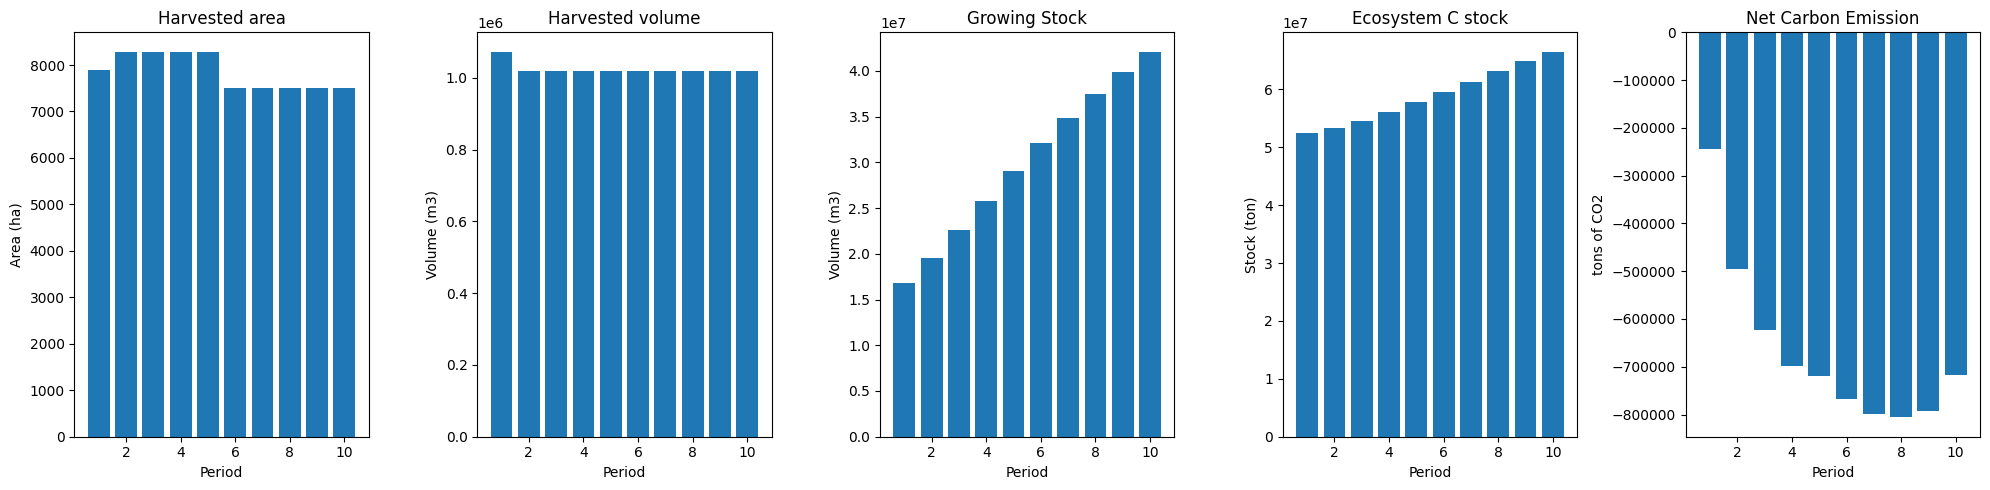

Plot saved to ./outputs/fig/redchris/redchris_min_em_bau_redchrs_scheduling_minemission.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  10831
The economic indicator (the provincial government revenues) is:  369393
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


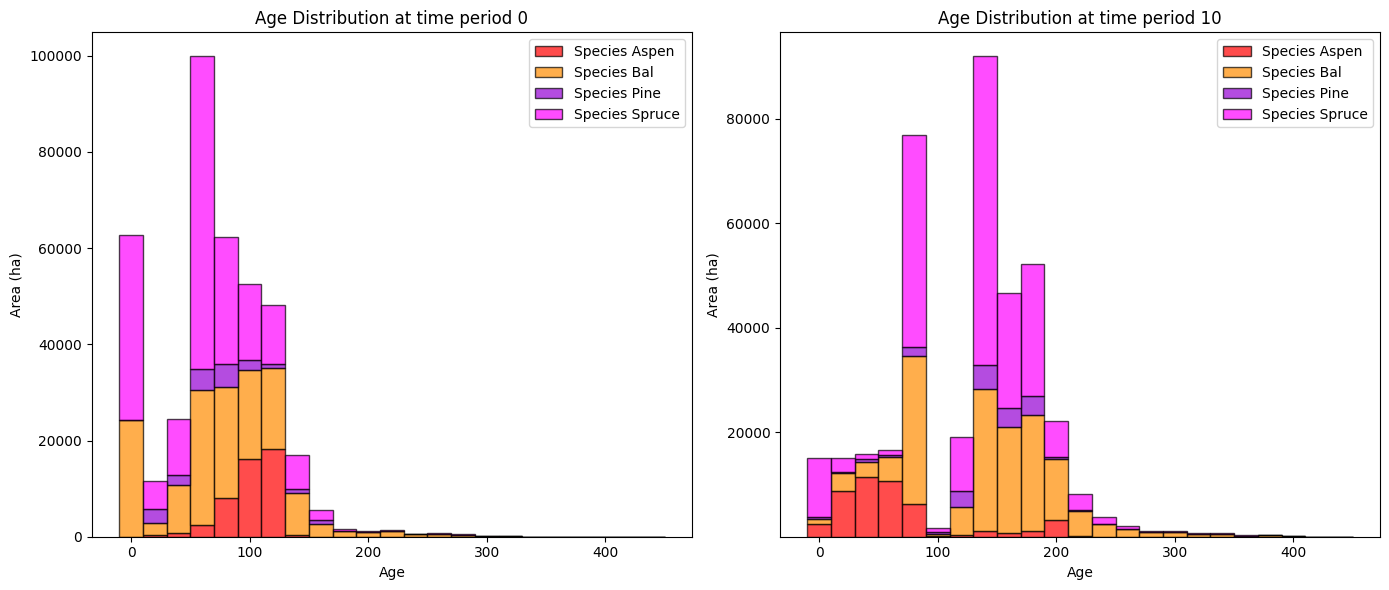

Plot saved to ./outputs/fig/redchris/redchris_min_em_bau_redchrs_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                  0            10    Difference
Aspen    945.313688   5435.179883   4489.866195
Pine     602.782616   6472.028996   5869.246380
Bal     4315.588546  38717.863313  34402.274766
Spruce  1072.814408  26003.989976  24931.175569

Old growth has **increased** by 69692.56 hectares from time period 0 to time period 10.


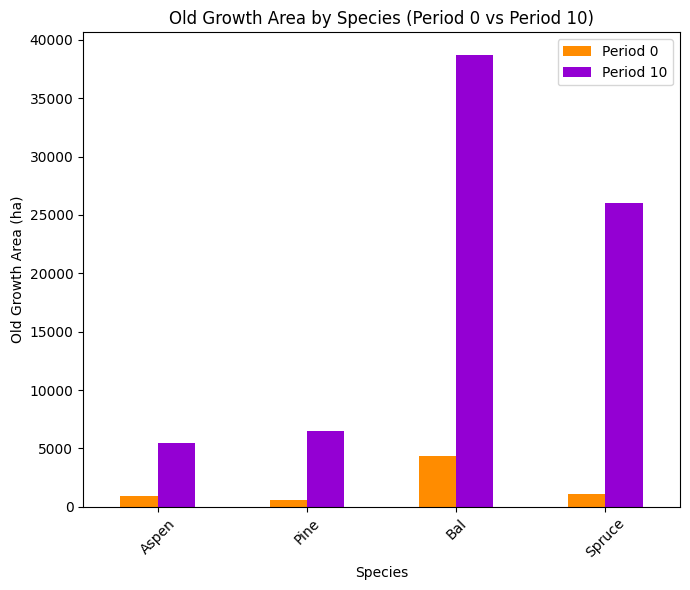

Clustered column plot saved to ./outputs/fig/redchris/redchris_min_em_bau_redchrs_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.8848
Shannon Evenness Index for time period 10: 0.7207

Diversity has **decreased** by 16.41% from time 0 to time 10.


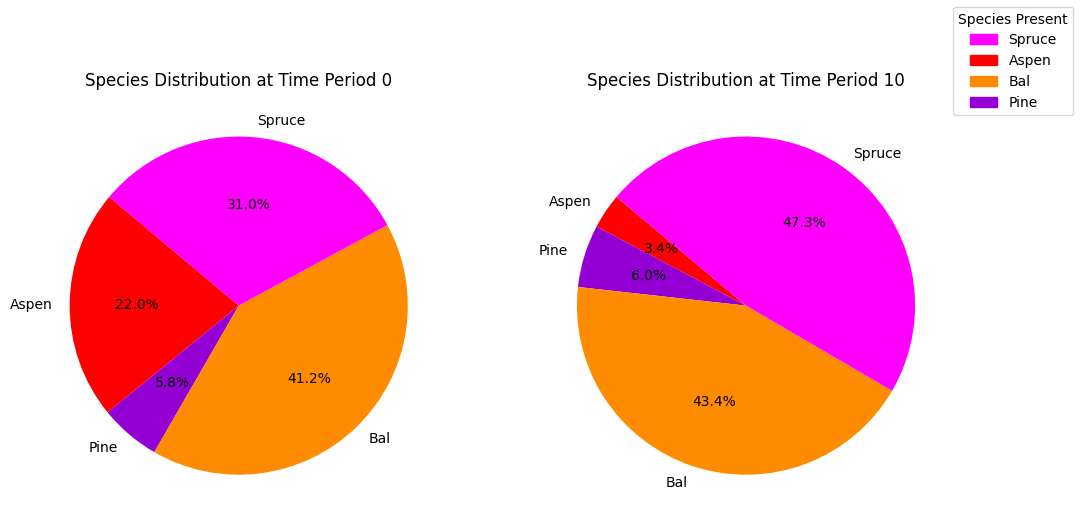

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_em_bau_redchrs_species_pie.pdf


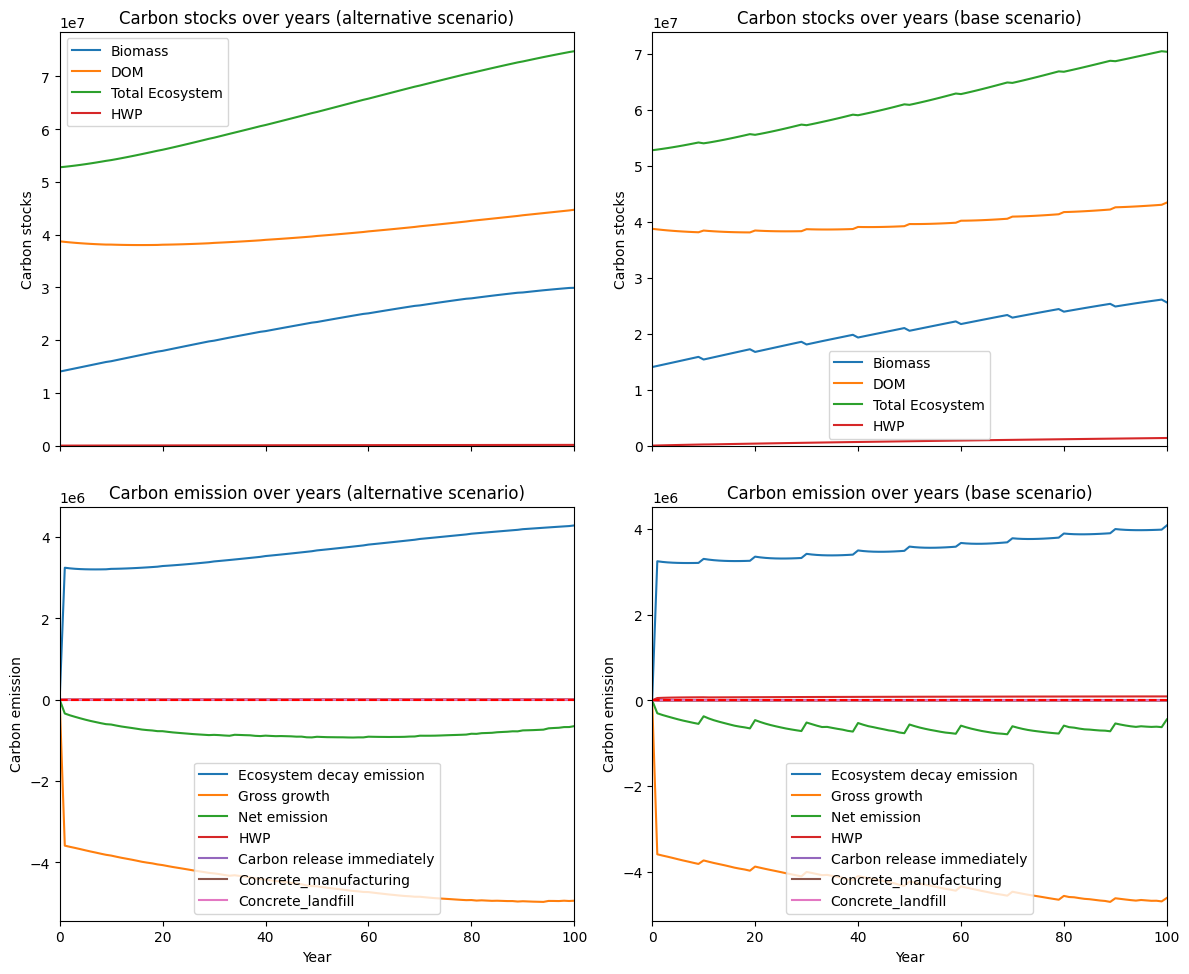

---------------------------------------------------------------------------------------
Net emission difference -18146586.637609366
Net emission base scenario -62345424.357902035
Net emission alternative scenario -80492010.99551137
dollar_per_ton is:  0.5510678233709633
Comparison of Old Growth Areas (Alternative - Base)
          0            10    Difference
Aspen   0.0  35045.033819  35045.033819
Pine    0.0   2617.214923   2617.214923
Bal     0.0  15120.309559  15120.309559
Spruce  0.0  15617.253830  15617.253830

Overall, the old growth area has **increased** by 68399.81 hectares in the alternative scenario compared to the base scenario.


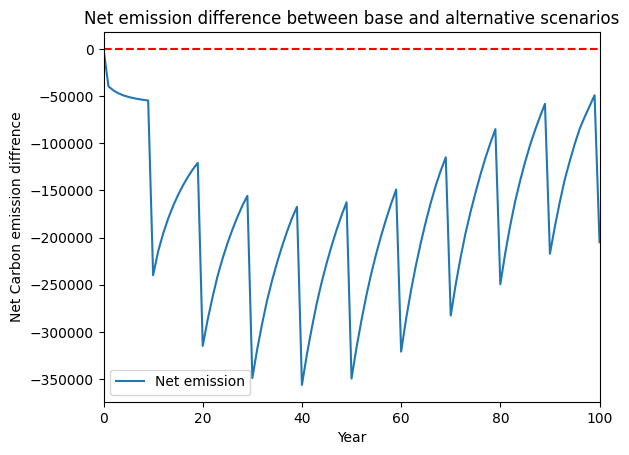

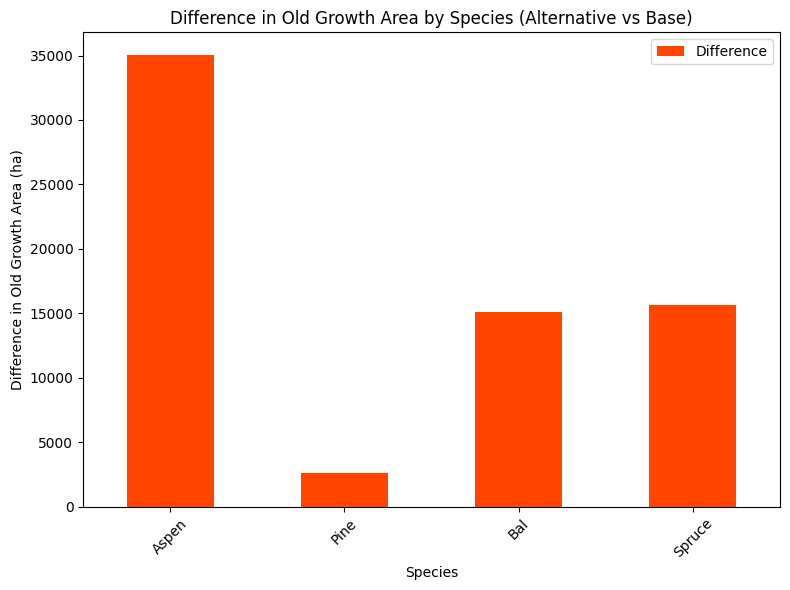

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/redchris/redchris_min_em_kpi_age_difference.pdf


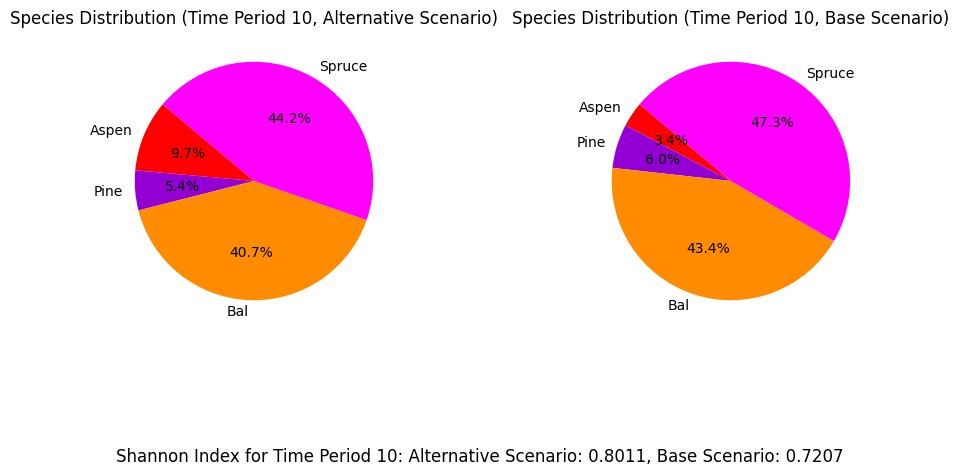

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/redchris/redchris_min_em_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
It took 5.6 minutes to run all scenarios.


In [14]:
Start = time.time()
scenario_names = ['redchrs_AAC_10%']
for scenario_name in scenario_names:
    print(f"Running for {case_study}_{obj_mode}_{scenario_name}...")
    results_scenarios(fm, 
                      clt_percentage, 
                      credibility, 
                      budget_input, 
                      n_steps, 
                      max_harvest, 
                      scenario_name, 
                      displacement_effect, 
                      hwp_pool_effect_value, 
                      release_immediately_value, 
                      case_study, 
                      obj_mode,                   
                      pickle_output_base=False, 
                      pickle_output_alter=False)
print('It took', round((time.time() - Start) / 60, 1), "minutes to run all scenarios.")

In [ ]:
print('It took', round((time.time() - Start) / 60, 1), "minutes to run this script.")